In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split as tts
import airbnb_project_functions as apf
import itertools
import csv
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score

df=pd.read_csv("airbnbHawaii_clean6.csv")


# Project Objective: 
## &emsp;Create a model that can predict the price of an airbnb unit based on the time of year and listing characteristics.

# Notebook Objective: Analyze the residuals produced by the best model (xgBoost 350 estimators)
## &emsp;-Look for patterns in the residuals and determine if they are associated with any particular level of any of the features.  
## &emsp;-Anaylze the affect of adding certain features, features that originally were not considered.
## &emsp;-Permutation feture importance for best model.

In [3]:
non_features=['price','inResort','number_of_reviews','geometry','week','listing_id','log_price','listing_url','missing_rating','price_per_accommodation','price_per_bedroom','price_per_review','property_type','geometry','anomaly_score','price_per_accommodation','price_per_bedroom','price_per_review','amenities_length']
features=[col for col in df.columns if col not in non_features]
df[features].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306254 entries, 0 to 306253
Data columns (total 44 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   latitude                             306254 non-null  float64
 1   longitude                            306254 non-null  float64
 2   accommodates                         306254 non-null  int64  
 3   bathrooms                            306254 non-null  float64
 4   bedrooms                             306254 non-null  float64
 5   review_scores_location               306254 non-null  float64
 6   review_scores_rating                 306254 non-null  float64
 7   review_scores_cleanliness            306254 non-null  float64
 8   room_type_Private room               306254 non-null  int64  
 9   room_type_Hotel room                 306254 non-null  int64  
 10  room_type_Shared room                306254 non-null  int64  
 11  isShared_bath

In [5]:
train, test=apf.train_test_split_airbnb(df,0.8)
X_train=train[features]
y_train=train['price']
X_test=test[features]
y_test=test['price']

# Best model at the time of this analysis

In [7]:

xgb_model = xgb.XGBRegressor(n_estimators=100,          # Number of trees in the forest
                    max_depth=7,              # Maximum depth of the tree
                    learning_rate=0.1,          # Step size shrinkage used in update to prevent overfitting
                    subsample=0.7,              # Proportion of samples to use for training each tree
                    colsample_bytree=0.8,       # Proportion of features to use for training each tree
                    gamma=0,                 # Minimum loss reduction required to make a further partition
                    random_state=42
                            )
xgb_model.fit(X_train, y_train)  

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [9]:
y_pred_train_xgb = xgb_model.predict(X_train)
y_pred_test_xgb = xgb_model.predict(X_test)
# Fit the model

# Calculate metrics
rmse_train_xgb = np.sqrt(mean_squared_error(y_train, y_pred_train_xgb))
rmse_test_xgb = np.sqrt(mean_squared_error(y_test, y_pred_test_xgb))
r2_train_xgb = r2_score(y_train, y_pred_train_xgb)
r2_test_xgb = r2_score(y_test, y_pred_test_xgb)

print("XGBoost Results:")
print(f"Train RMSE: {rmse_train_xgb}")
print(f"Test RMSE: {rmse_test_xgb}")
print(f"Train R2: {r2_train_xgb}")
print(f"Test R2: {r2_test_xgb}")

XGBoost Results:
Train RMSE: 71.125687255537
Test RMSE: 109.28570735963619
Train R2: 0.9160527078459726
Test R2: 0.7954658929913839


# Residuals Analysis

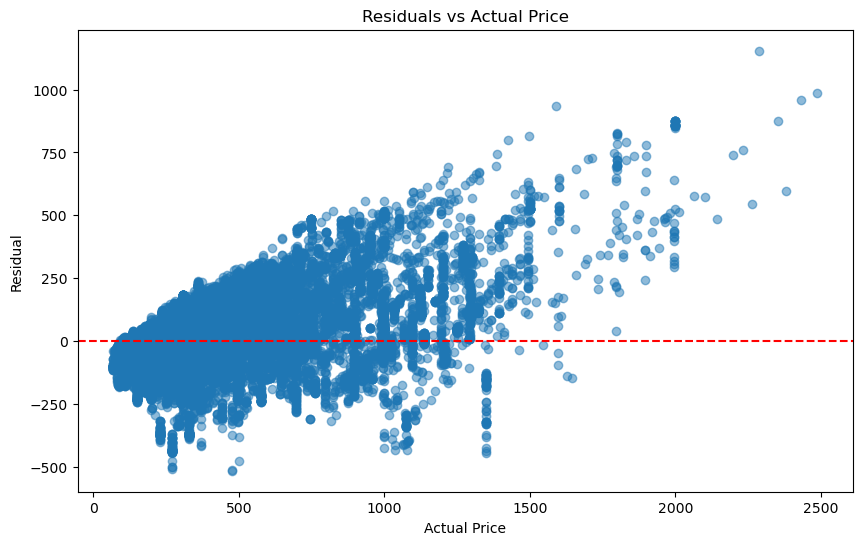

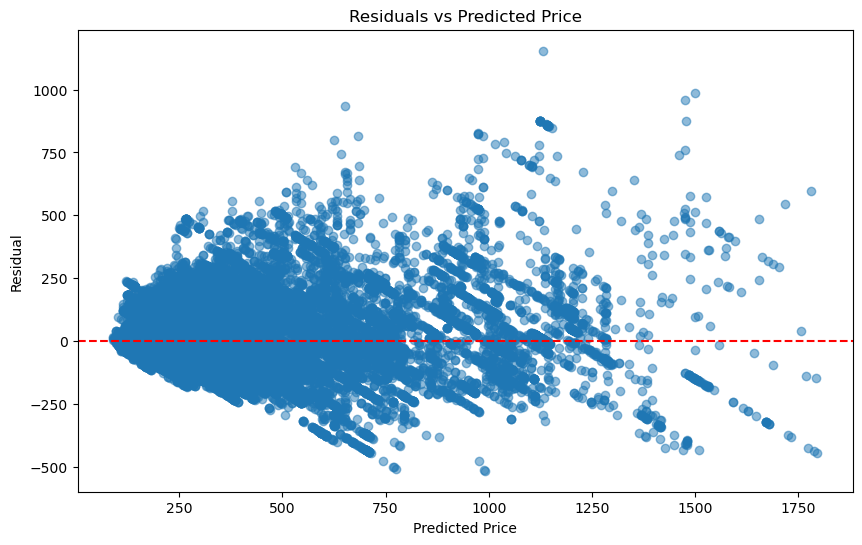

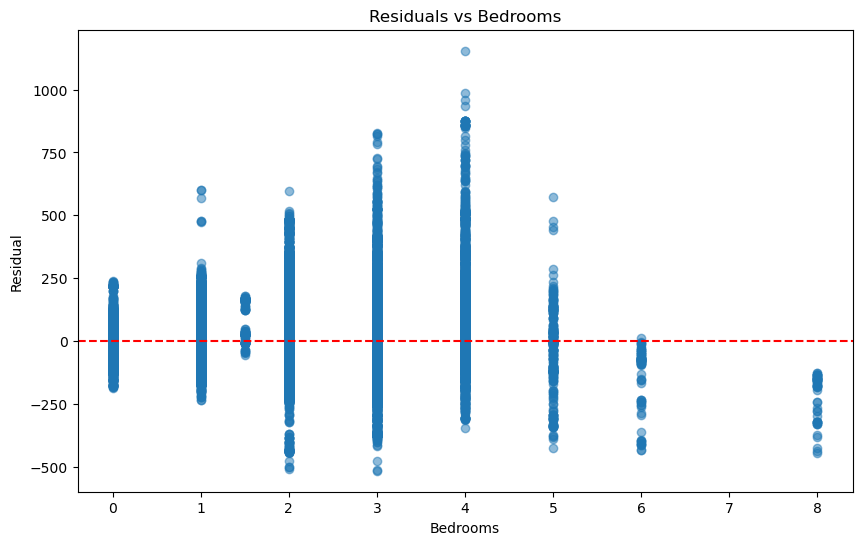

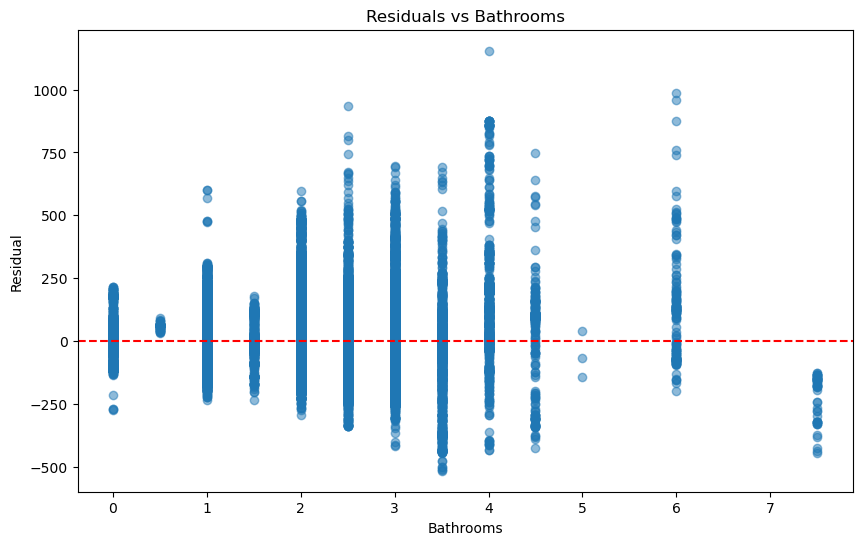

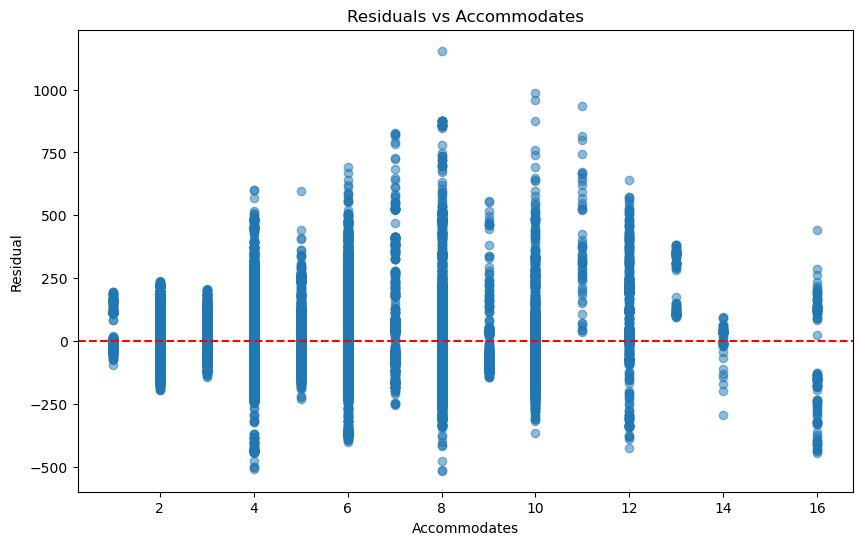

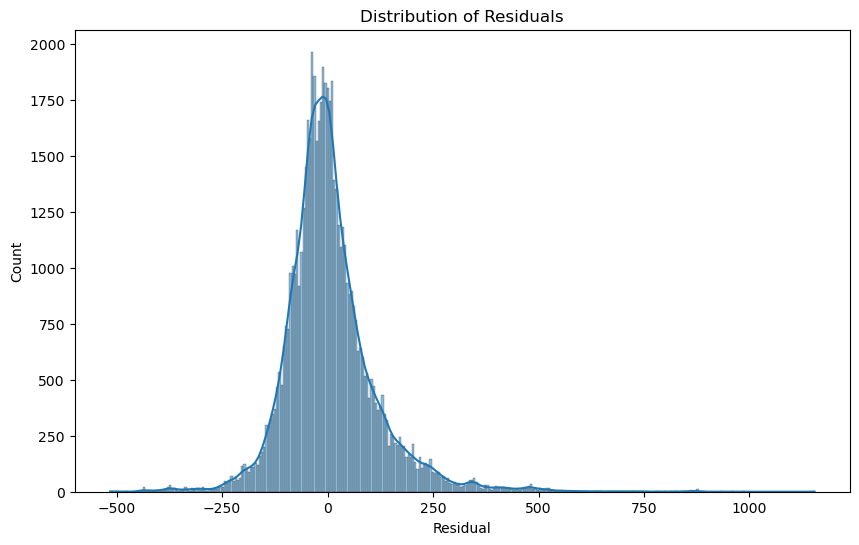

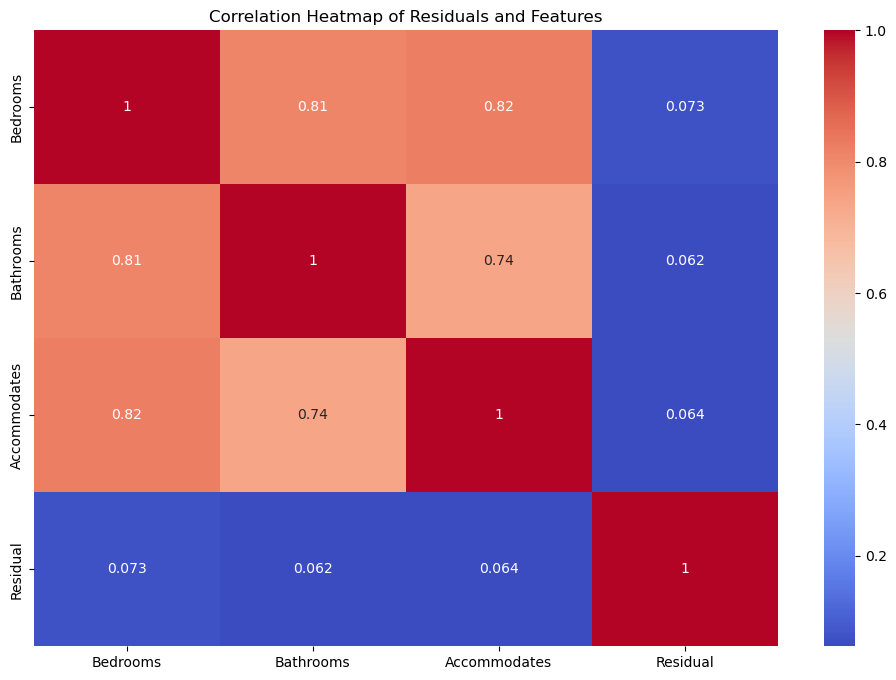

In [11]:


# Calculate residuals
test_residuals = y_test - y_pred_test_xgb

# Create a DataFrame with test data, predictions, and residuals
residual_df = pd.DataFrame({
    'Actual Price': y_test,
    'Predicted Price': y_pred_test_xgb,
    'Residual': test_residuals,
    'Bedrooms': test['bedrooms'],
    'Bathrooms': test['bathrooms'],
    'Accommodates': test['accommodates']
})

# Function to create residual plots
def plot_residuals(x, y, xlabel, ylabel, title):
    plt.figure(figsize=(10, 6))
    plt.scatter(x, y, alpha=0.5)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()

# 1. Residuals vs Actual Price
plot_residuals(residual_df['Actual Price'], residual_df['Residual'], 
               'Actual Price', 'Residual', 'Residuals vs Actual Price')

# 2. Residuals vs Predicted Price
plot_residuals(residual_df['Predicted Price'], residual_df['Residual'], 
               'Predicted Price', 'Residual', 'Residuals vs Predicted Price')

# 3. Residuals vs Bedrooms
plot_residuals(residual_df['Bedrooms'], residual_df['Residual'], 
               'Bedrooms', 'Residual', 'Residuals vs Bedrooms')

# 4. Residuals vs Bathrooms
plot_residuals(residual_df['Bathrooms'], residual_df['Residual'], 
               'Bathrooms', 'Residual', 'Residuals vs Bathrooms')

# 5. Residuals vs Accommodates
plot_residuals(residual_df['Accommodates'], residual_df['Residual'], 
               'Accommodates', 'Residual', 'Residuals vs Accommodates')

# 6. Distribution of Residuals
plt.figure(figsize=(10, 6))
sns.histplot(residual_df['Residual'], kde=True)
plt.title('Distribution of Residuals')
plt.xlabel('Residual')
plt.show()

# 7. Heatmap of Residuals
plt.figure(figsize=(12, 8))
sns.heatmap(residual_df[['Bedrooms', 'Bathrooms', 'Accommodates', 'Residual']].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap of Residuals and Features')
plt.show()


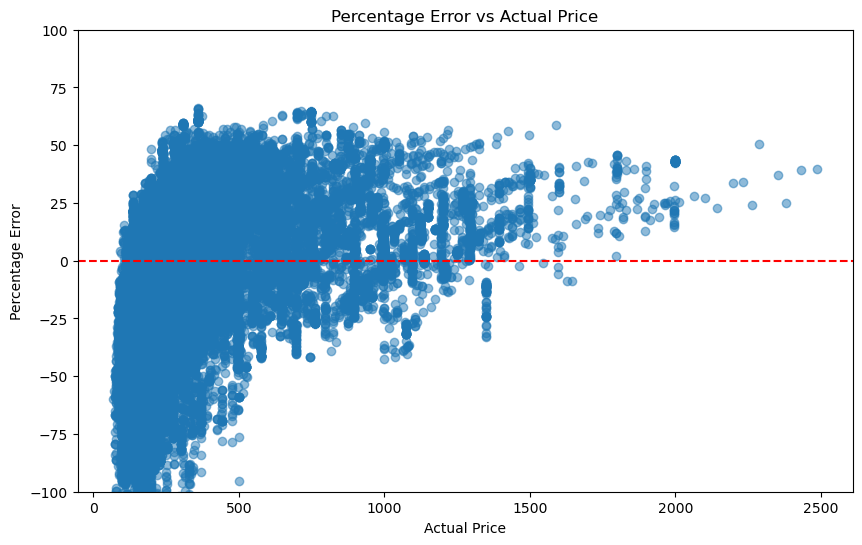

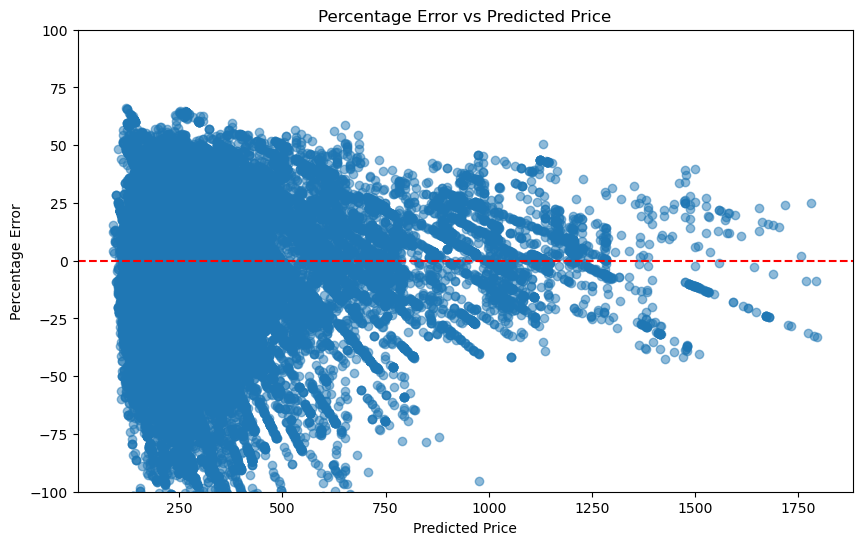

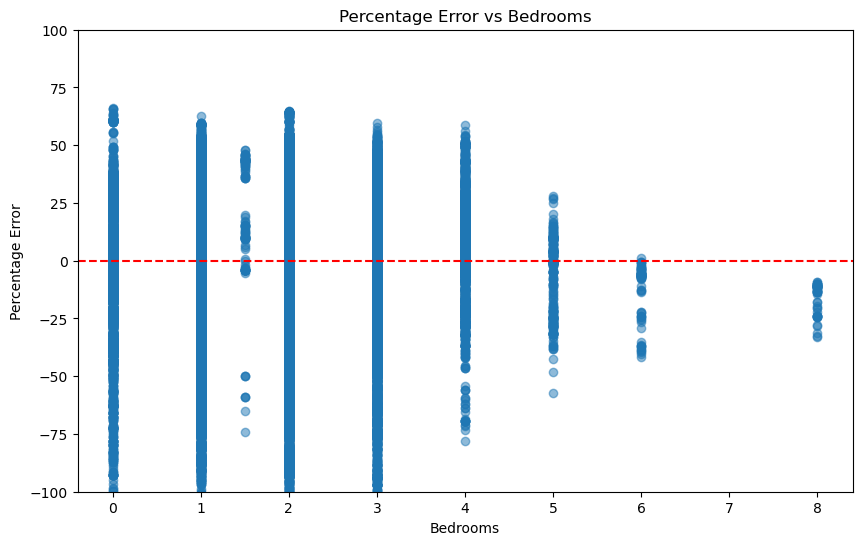

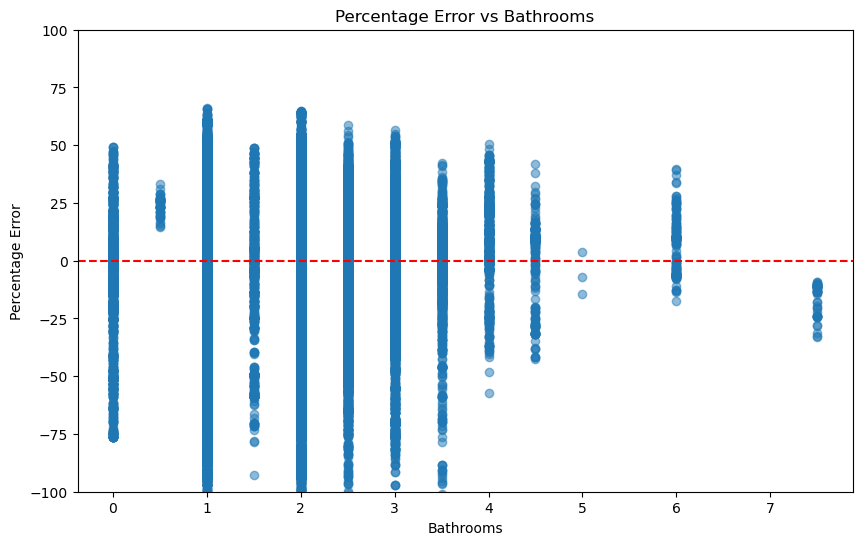

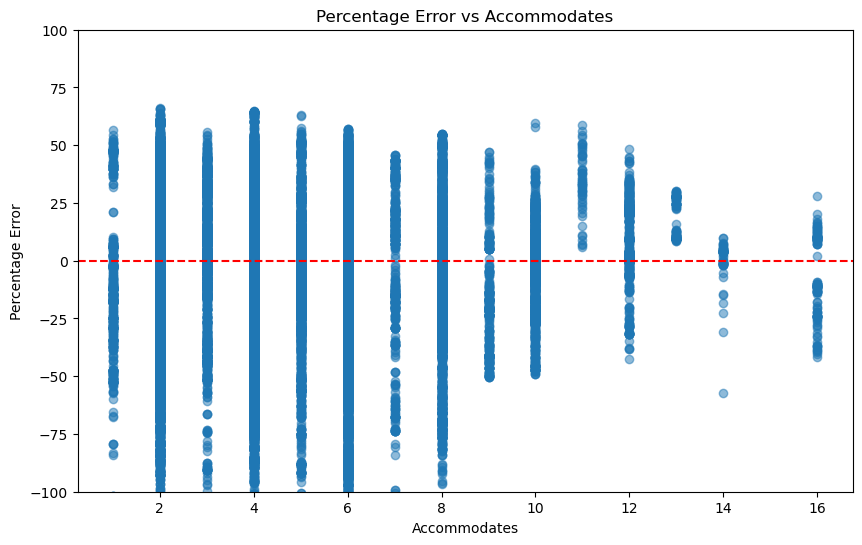

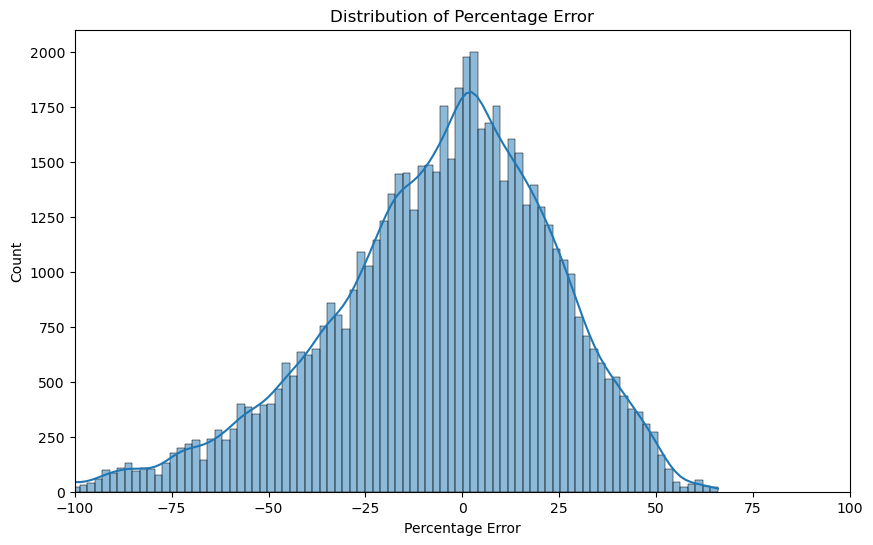

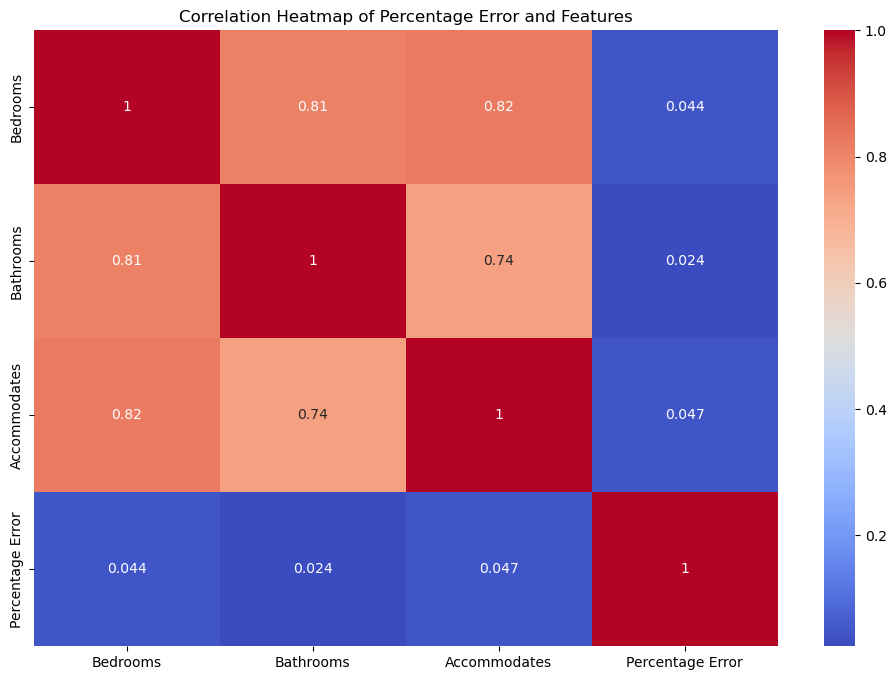

In [13]:


# Calculate percentage error
percentage_error = ((y_test - y_pred_test_xgb) / y_test) * 100

# Create a DataFrame with test data, predictions, and percentage error
error_df = pd.DataFrame({
    'Actual Price': y_test,
    'Predicted Price': y_pred_test_xgb,
    'Percentage Error': percentage_error,
    'Bedrooms': test['bedrooms'],
    'Bathrooms': test['bathrooms'],
    'Accommodates': test['accommodates']
})

# Function to create percentage error plots
def plot_percentage_error(x, y, xlabel, ylabel, title):
    plt.figure(figsize=(10, 6))
    plt.scatter(x, y, alpha=0.5)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.ylim(-100, 100)  # Limit y-axis to -100% to 100% for better visibility
    plt.show()

# 1. Percentage Error vs Actual Price
plot_percentage_error(error_df['Actual Price'], error_df['Percentage Error'], 
                      'Actual Price', 'Percentage Error', 'Percentage Error vs Actual Price')

# 2. Percentage Error vs Predicted Price
plot_percentage_error(error_df['Predicted Price'], error_df['Percentage Error'], 
                      'Predicted Price', 'Percentage Error', 'Percentage Error vs Predicted Price')

# 3. Percentage Error vs Bedrooms
plot_percentage_error(error_df['Bedrooms'], error_df['Percentage Error'], 
                      'Bedrooms', 'Percentage Error', 'Percentage Error vs Bedrooms')

# 4. Percentage Error vs Bathrooms
plot_percentage_error(error_df['Bathrooms'], error_df['Percentage Error'], 
                      'Bathrooms', 'Percentage Error', 'Percentage Error vs Bathrooms')

# 5. Percentage Error vs Accommodates
plot_percentage_error(error_df['Accommodates'], error_df['Percentage Error'], 
                      'Accommodates', 'Percentage Error', 'Percentage Error vs Accommodates')

# 6. Distribution of Percentage Error
plt.figure(figsize=(10, 6))
sns.histplot(error_df['Percentage Error'], kde=True)
plt.title('Distribution of Percentage Error')
plt.xlabel('Percentage Error')
plt.xlim(-100, 100)  # Limit x-axis to -100% to 100% for better visibility
plt.show()

# 7. Heatmap of Percentage Error
plt.figure(figsize=(12, 8))
sns.heatmap(error_df[['Bedrooms', 'Bathrooms', 'Accommodates', 'Percentage Error']].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap of Percentage Error and Features')
plt.show()

# 8. Mean Absolute


**It is a good that there is low correlation between the features and the residual.**

# A look at predictions

In [15]:
test['prediction_xg']=y_pred_test_xgb
test[['price','prediction_xg','bedrooms','bathrooms','distanceToOcean', 'week','listing_url']].sample(20)

/var/folders/y_/zdr3xmx13qz3pq6ct9kglm7h0000gn/T/ipykernel_30864/3206469960.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['prediction_xg']=y_pred_test_xgb


price  prediction_xg  bedrooms  bathrooms  distanceToOcean  \
194378   999.000000     604.601196       2.0        2.5         0.577342   
24820    398.000000     312.946228       2.0        2.0         0.206389   
162475   600.000000     391.889282       3.0        3.0         0.644783   
83388    157.000000     268.371704       1.0        1.0         0.216052   
244834   389.000000     359.095825       2.0        2.0         0.337749   
245143   225.000000     230.656570       1.0        1.0         0.190157   
90728    330.000000     622.407654       3.0        3.5         6.234764   
180490   217.000000     193.324463       0.0        1.0         0.540152   
92976    785.571429     486.873932       3.0        2.0         2.112092   
262398   254.142857     173.663528       1.0        1.0         7.412221   
193181   156.000000     209.720825       1.0        1.0         0.207947   
256163  1285.714286    1034.821167       2.0        2.0         0.299371   
32590    377.000000     243.560043       2.0        2.0         0.457298   
133672   178.000000     295.361450       2.0        2.0         0.215128   
132601   398.714286     333.105988       1.0        1.0         0.413412   
296781   653.857143     451.373138       3.0        3.0         0.535424   
21877    254.000000     209.639114       2.0        1.0         0.247873   
37295    472.000000     374.027313       2.0        2.0         0.095212   
172768   456.000000     407.349152       2.0        2.0         0.356646   
304466   141.000000     231.347000       1.0        1.0         0.146654   

        week                                      listing_url  
194378    29  https://www.airbnb.com/rooms/665781740148847797  
24820      1            https://www.airbnb.com/rooms/12590564  
162475    21            https://www.airbnb.com/rooms/53665730  
83388      6            https://www.airbnb.com/rooms/35666711  
244834    49  https://www.airbnb.com/rooms/799909748528637227  
245143    14  https://www.airbnb.com/rooms/799925477208577375  
90728     39            https://www.airbnb.com/rooms/38958772  
180490    41  https://www.airbnb.com/rooms/603663451488062296  
92976     16            https://www.airbnb.com/rooms/39561772  
262398    11  https://www.airbnb.com/rooms/845841906232749071  
193181    21  https://www.airbnb.com/rooms/660783121075535987  
256163     4  https://www.airbnb.com/rooms/815328218009064251  
32590     21            https://www.airbnb.com/rooms/16393475  
133672    36            https://www.airbnb.com/rooms/49099077  
132601    52            https://www.airbnb.com/rooms/48943792  
296781     9  https://www.airbnb.com/rooms/939794498748173348  
21877     12            https://www.airbnb.com/rooms/11715756  
37295     13            https://www.airbnb.com/rooms/18333301  
172768    43  https://www.airbnb.com/rooms/563770151116374273  
304466     6  https://www.airbnb.com/rooms/969460955722384636

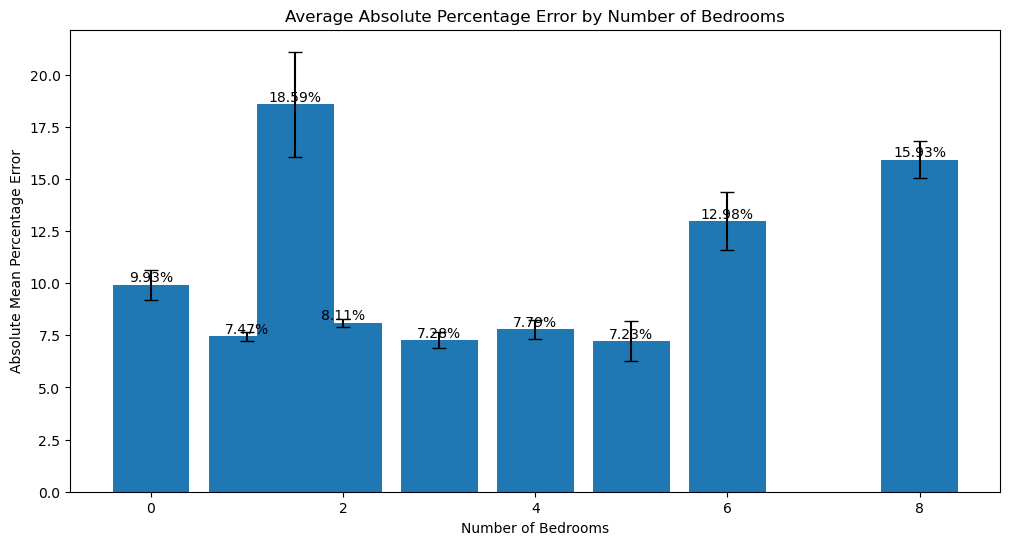


Summary for Bedrooms:
   Bedrooms       mean  count        std  Abs Mean Error  Std Error
2       1.5  18.594450    120  27.531042       18.594450   2.513229
8       8.0 -15.932492     58   6.754229       15.932492   0.886874
7       6.0 -12.981293     81  12.630321       12.981293   1.403369
0       0.0  -9.928646   3090  39.473640        9.928646   0.710114
3       2.0  -8.105722  25301  31.872599        8.105722   0.200377
5       4.0   7.786218   2257  21.296333        7.786218   0.448269
1       1.0  -7.467913  21397  31.830281        7.467913   0.217603
4       3.0  -7.277300   8393  33.691463        7.277300   0.367757
6       5.0  -7.225922    293  16.572722        7.225922   0.968189


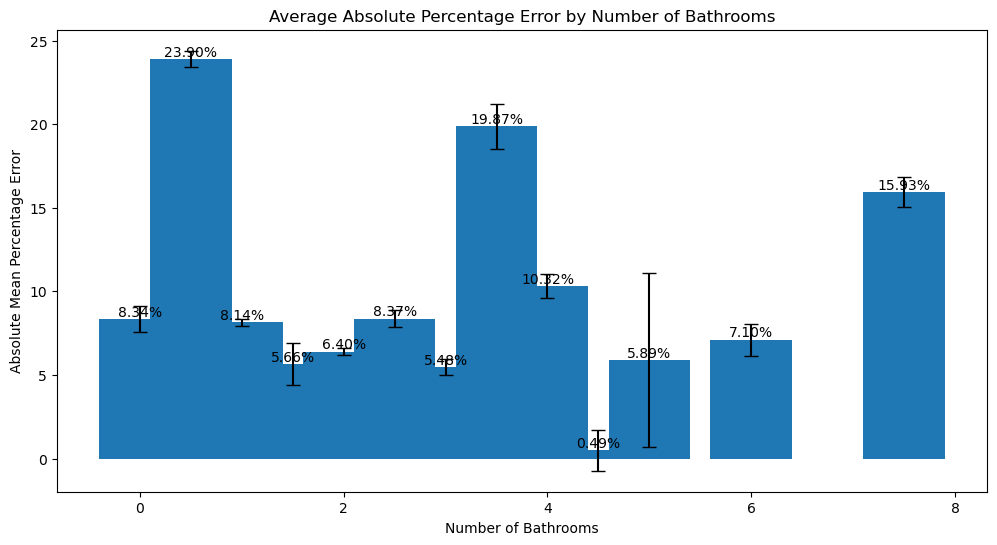


Summary for Bathrooms:
    Bathrooms       mean  count        std  Abs Mean Error  Std Error
1         0.5  23.897694     58   3.788317       23.897694   0.497430
7         3.5 -19.871587   1376  50.356061       19.871587   1.357508
12        7.5 -15.932492     58   6.754229       15.932492   0.886874
8         4.0  10.318542    767  19.286829       10.318542   0.696407
5         2.5  -8.370576   3593  31.569314        8.370576   0.526668
0         0.0  -8.341323   1334  28.390017        8.341323   0.777298
2         1.0  -8.142197  25575  33.430716        8.142197   0.209044
11        6.0   7.101509    160  12.194086        7.101509   0.964027
4         2.0  -6.396814  22949  30.142299        6.396814   0.198973
10        5.0  -5.888824      3   9.039849        5.888824   5.219160
3         1.5  -5.661131    638  31.411261        5.661131   1.243584
6         3.0  -5.482779   4255  32.007260        5.482779   0.490680
9         4.5   0.490204    224  18.233940        0.490204   1.218

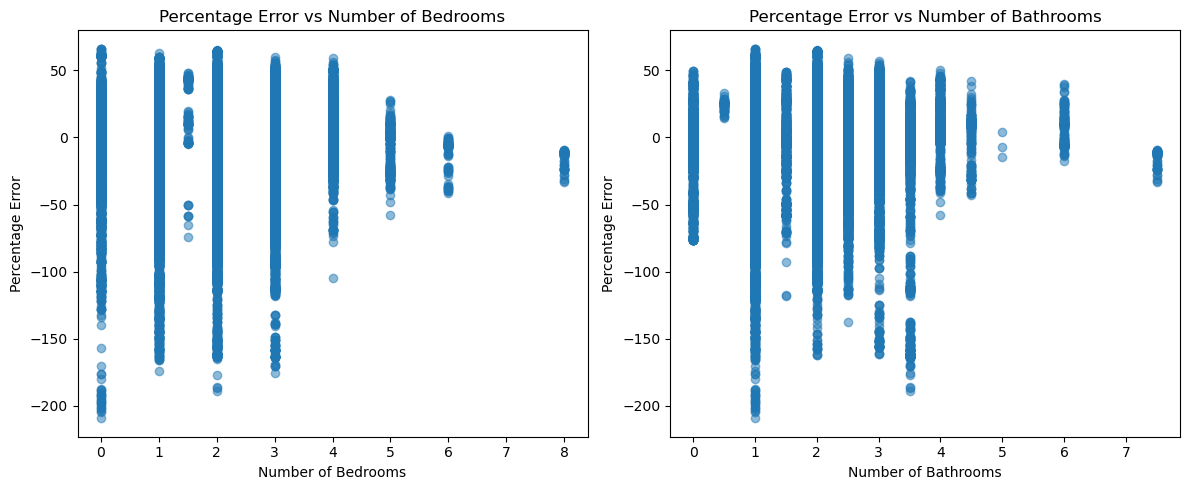

In [17]:


# Function to calculate and plot average error
def plot_average_error(feature_name):
    # Calculate average absolute percentage error
    avg_error = error_df.groupby(feature_name)['Percentage Error'].agg(['mean', 'count', 'std']).reset_index()
    avg_error['Abs Mean Error'] = avg_error['mean'].abs()
    avg_error['Std Error'] = avg_error['std'] / np.sqrt(avg_error['count'])  # Standard error

    # Sort by the feature value
    avg_error = avg_error.sort_values(feature_name)

    # Bar plot
    plt.figure(figsize=(12, 6))
    bars = plt.bar(avg_error[feature_name], avg_error['Abs Mean Error'], 
                   yerr=avg_error['Std Error'], capsize=5)
    plt.title(f'Average Absolute Percentage Error by Number of {feature_name}')
    plt.xlabel(f'Number of {feature_name}')
    plt.ylabel('Absolute Mean Percentage Error')
    
    # Add value labels on top of each bar
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                 f'{height:.2f}%',
                 ha='center', va='bottom')
    
    plt.show()

    # Print summary statistics
    print(f"\nSummary for {feature_name}:")
    print(avg_error.sort_values('Abs Mean Error', ascending=False))

# Plot for Bedrooms
plot_average_error('Bedrooms')

# Plot for Bathrooms
plot_average_error('Bathrooms')

# Additional analysis: Correlation with error
correlation_with_error = error_df[['Bedrooms', 'Bathrooms', 'Percentage Error']].corr()['Percentage Error'].drop('Percentage Error')
print("\nCorrelation of features with Percentage Error:")
print(correlation_with_error)

# Scatter plots
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(error_df['Bedrooms'], error_df['Percentage Error'], alpha=0.5)
plt.title('Percentage Error vs Number of Bedrooms')
plt.xlabel('Number of Bedrooms')
plt.ylabel('Percentage Error')

plt.subplot(1, 2, 2)
plt.scatter(error_df['Bathrooms'], error_df['Percentage Error'], alpha=0.5)
plt.title('Percentage Error vs Number of Bathrooms')
plt.xlabel('Number of Bathrooms')
plt.ylabel('Percentage Error')

plt.tight_layout()
plt.show()


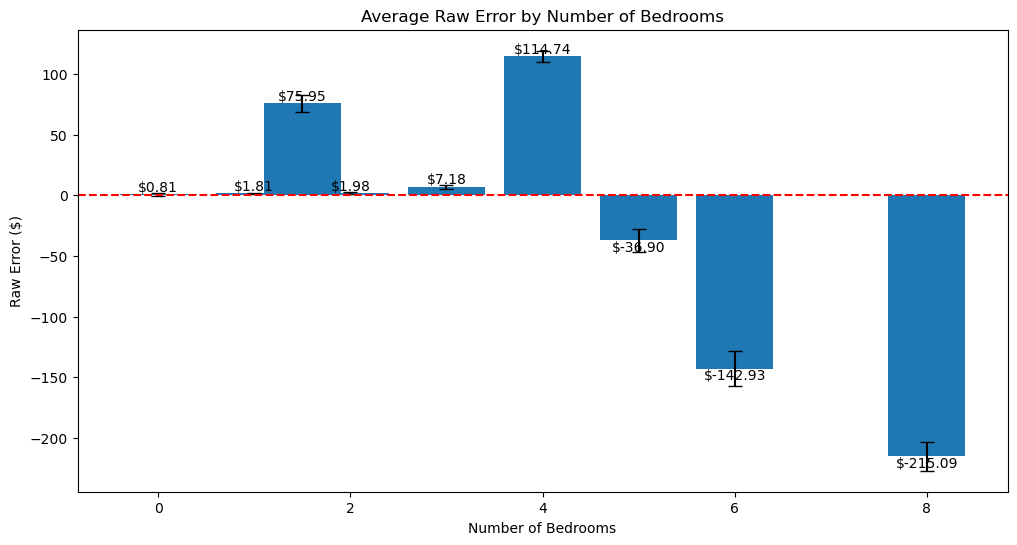


Summary for Bedrooms:
   Bedrooms        mean  count         std  Abs Mean Error  Std Error
8       8.0 -215.088638     58   91.182086      215.088638  11.972794
7       6.0 -142.932110     81  130.951186      142.932110  14.550132
5       4.0  114.739965   2257  215.432198      114.739965   4.534661
2       1.5   75.945721    120   76.884931       75.945721   7.018602
6       5.0  -36.904499    293  162.402246       36.904499   9.487641
4       3.0    7.182390   8393  153.329460        7.182390   1.673659
3       2.0    1.979873  25301  104.330482        1.979873   0.655907
1       1.0    1.813967  21397   65.717534        1.813967   0.449267
0       0.0    0.809799   3090   63.961531        0.809799   1.150640


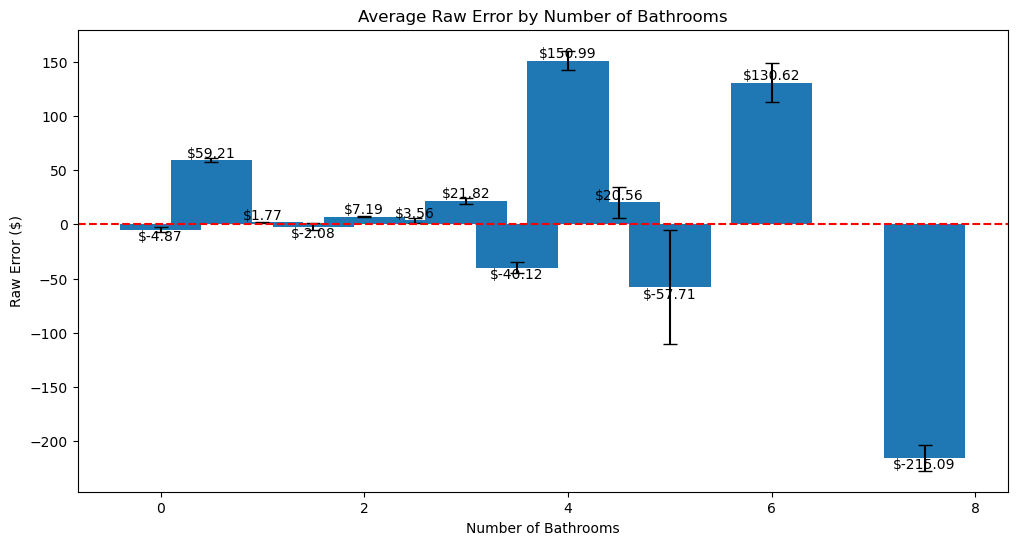


Summary for Bathrooms:
    Bathrooms        mean  count         std  Abs Mean Error  Std Error
12        7.5 -215.088638     58   91.182086      215.088638  11.972794
8         4.0  150.994957    767  250.165475      150.994957   9.032952
11        6.0  130.624139    160  225.133792      130.624139  17.798389
1         0.5   59.212568     58   12.094771       59.212568   1.588121
10        5.0  -57.710725      3   91.110442       57.710725  52.602638
7         3.5  -40.116533   1376  191.120886       40.116533   5.152274
6         3.0   21.824649   4255  171.246282       21.824649   2.625254
9         4.5   20.560481    224  213.712118       20.560481  14.279241
4         2.0    7.187801  22949  104.719574        7.187801   0.691267
0         0.0   -4.874809   1334   72.786028        4.874809   1.992829
5         2.5    3.556292   3593  148.270887        3.556292   2.473588
3         1.5   -2.077969    638   78.367806        2.077969   3.102611
2         1.0    1.768768  25575   67.45

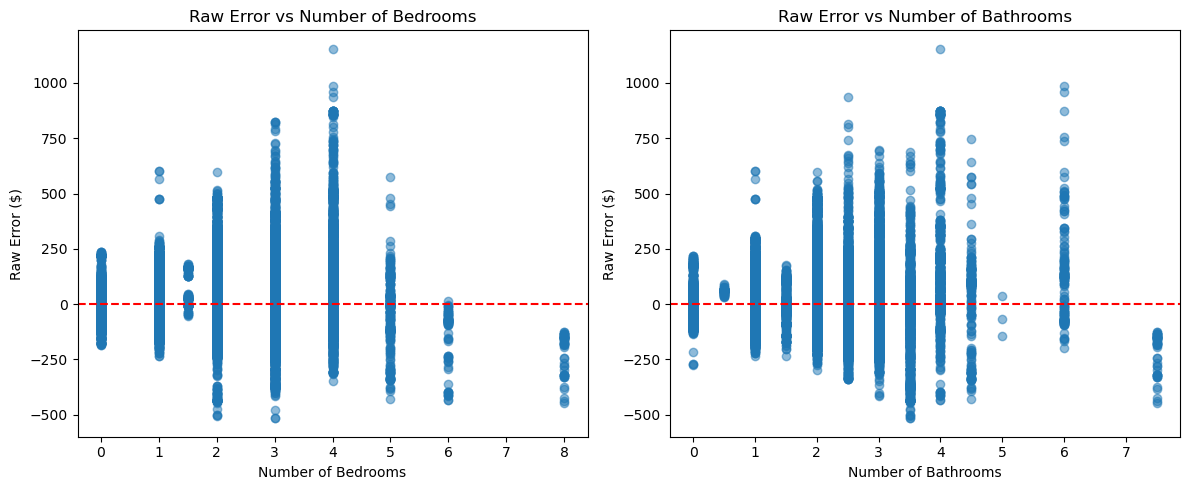


Overall Mean Absolute Error: $74.75


In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Calculate raw error
raw_error = y_test - y_pred_test_xgb

# Create a DataFrame with test data, predictions, and raw error
error_df = pd.DataFrame({
    'Actual Price': y_test,
    'Predicted Price': y_pred_test_xgb,
    'Raw Error': raw_error,
    'Bedrooms': test['bedrooms'],
    'Bathrooms': test['bathrooms'],
    'Accommodates': test['accommodates']
})

# Function to calculate and plot average raw error
def plot_average_raw_error(feature_name):
    # Calculate average raw error
    avg_error = error_df.groupby(feature_name)['Raw Error'].agg(['mean', 'count', 'std']).reset_index()
    avg_error['Abs Mean Error'] = avg_error['mean'].abs()
    avg_error['Std Error'] = avg_error['std'] / np.sqrt(avg_error['count'])  # Standard error

    # Sort by the feature value
    avg_error = avg_error.sort_values(feature_name)

    # Bar plot
    plt.figure(figsize=(12, 6))
    bars = plt.bar(avg_error[feature_name], avg_error['mean'], 
                   yerr=avg_error['Std Error'], capsize=5)
    plt.title(f'Average Raw Error by Number of {feature_name}')
    plt.xlabel(f'Number of {feature_name}')
    plt.ylabel('Raw Error ($)')
    
    # Add value labels on top of each bar
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                 f'${height:.2f}',
                 ha='center', va='bottom' if height > 0 else 'top')
    
    plt.axhline(y=0, color='r', linestyle='--')  # Add a horizontal line at y=0
    plt.show()

    # Print summary statistics
    print(f"\nSummary for {feature_name}:")
    print(avg_error.sort_values('Abs Mean Error', ascending=False))

# Plot for Bedrooms
plot_average_raw_error('Bedrooms')

# Plot for Bathrooms
plot_average_raw_error('Bathrooms')

# Additional analysis: Correlation with error
correlation_with_error = error_df[['Bedrooms', 'Bathrooms', 'Raw Error']].corr()['Raw Error'].drop('Raw Error')
print("\nCorrelation of features with Raw Error:")
print(correlation_with_error)

# Scatter plots
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(error_df['Bedrooms'], error_df['Raw Error'], alpha=0.5)
plt.title('Raw Error vs Number of Bedrooms')
plt.xlabel('Number of Bedrooms')
plt.ylabel('Raw Error ($)')
plt.axhline(y=0, color='r', linestyle='--')

plt.subplot(1, 2, 2)
plt.scatter(error_df['Bathrooms'], error_df['Raw Error'], alpha=0.5)
plt.title('Raw Error vs Number of Bathrooms')
plt.xlabel('Number of Bathrooms')
plt.ylabel('Raw Error ($)')
plt.axhline(y=0, color='r', linestyle='--')

plt.tight_layout()
plt.show()

# Calculate and print overall mean absolute error
mae = np.mean(np.abs(raw_error))
print(f"\nOverall Mean Absolute Error: ${mae:.2f}")


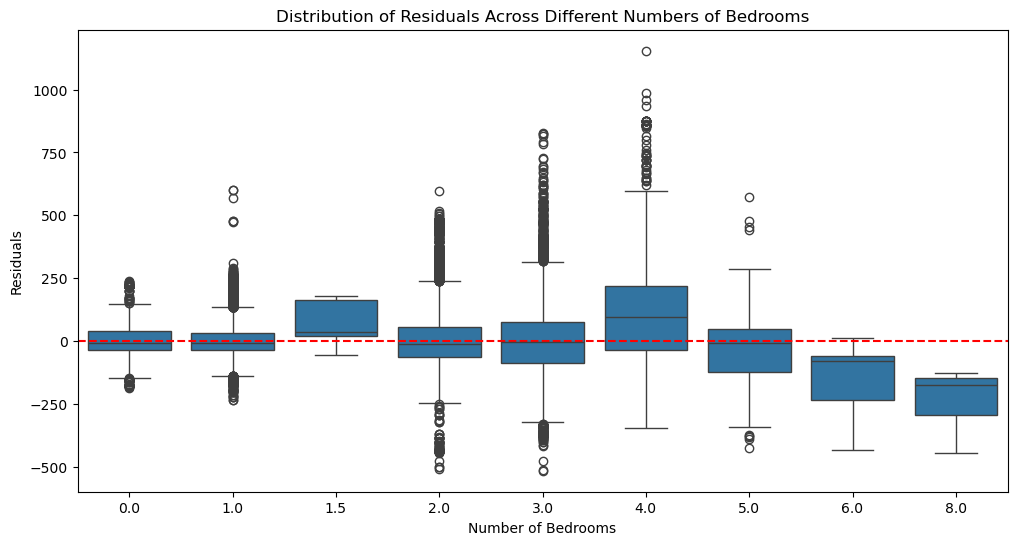

            count        mean         std         min         25%         50%  \
bedrooms                                                                        
0.0        3090.0    0.809799   63.961531 -186.309631  -35.938324   -8.514084   
1.0       21397.0    1.813967   65.717534 -235.347473  -36.728627   -6.330734   
1.5         120.0   75.945721   76.884931  -55.499542   20.429581   37.628189   
2.0       25301.0    1.979873  104.330482 -507.600159  -65.421967  -12.133301   
3.0        8393.0    7.182390  153.329460 -515.642151  -87.057922   -5.797516   
4.0        2257.0  114.739965  215.432198 -346.503113  -35.767578   96.590210   
5.0         293.0  -36.904499  162.402246 -426.688721 -121.764779   -7.051758   
6.0          81.0 -142.932110  130.951186 -433.319475 -234.416138  -79.120972   
8.0          58.0 -215.088638   91.182086 -446.212158 -292.261475 -173.377686   

                 75%          max  
bedrooms                           
0.0        38.814621   236.788864  


In [23]:


# Calculate residuals
residuals = raw_error
# Create a DataFrame with bedrooms and residuals
residual_df = pd.DataFrame({
    'bedrooms': test['bedrooms'],  # Assuming 'bedrooms' is in your test DataFrame
    'residuals': residuals
})

# Create the box plot
plt.figure(figsize=(12, 6))
sns.boxplot(x='bedrooms', y='residuals', data=residual_df)
plt.title('Distribution of Residuals Across Different Numbers of Bedrooms')
plt.xlabel('Number of Bedrooms')
plt.ylabel('Residuals')
plt.axhline(y=0, color='r', linestyle='--')
plt.show()

# If you want to see summary statistics
print(residual_df.groupby('bedrooms')['residuals'].describe())

/Users/johnprichard/anaconda3/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/y_/zdr3xmx13qz3pq6ct9kglm7h0000gn/T/ipykernel_2783/3343413954.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['error']=abs_errors
/var/folders/y_/zdr3xmx13qz3pq6ct9kglm7h0000gn/T/ipykernel_2783/3343413954.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['predicted_price']=y_pred_test_xgb

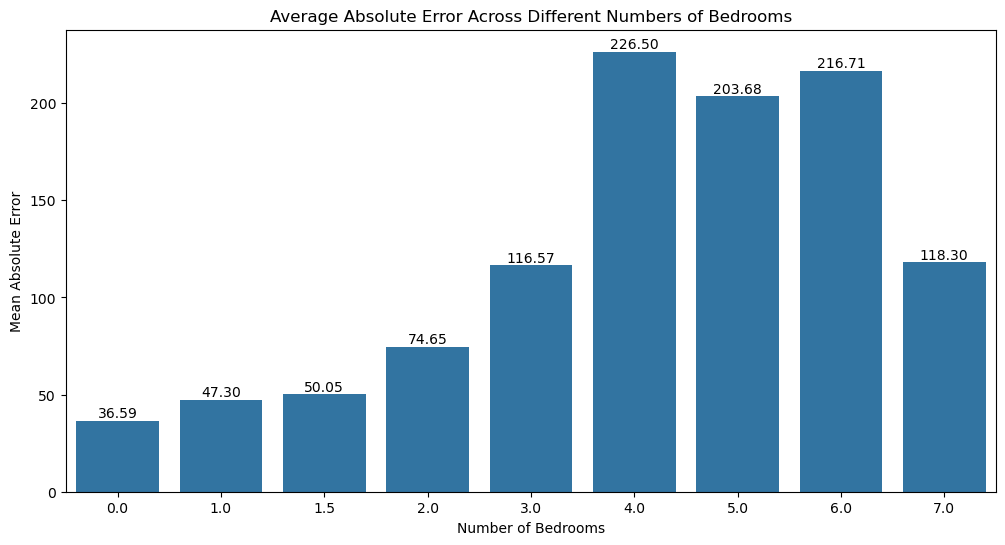

   bedrooms   abs_error
0       0.0   36.590151
1       1.0   47.302724
2       1.5   50.051072
3       2.0   74.650703
4       3.0  116.568160
5       4.0  226.496970
6       5.0  203.676000
7       6.0  216.705928
8       7.0  118.296461


In [16]:

# Calculate absolute errors
abs_errors = np.abs(y_test - y_pred_test_xgb )
rmse=np.sqrt(y_test-y_pred_test_xgb)**2
test['error']=abs_errors
test['predicted_price']=y_pred_test_xgb
# Create a DataFrame with bedrooms and absolute errors
error_df = pd.DataFrame({
    'bedrooms': test['bedrooms'],  # Assuming 'bedrooms' is in your test DataFrame
    'abs_error': abs_errors
})

# Calculate mean absolute error for each bedroom level
mean_errors = error_df.groupby('bedrooms')['abs_error'].mean().reset_index()

# Create the bar plot
plt.figure(figsize=(12, 6))
sns.barplot(x='bedrooms', y='abs_error', data=mean_errors)
plt.title('Average Absolute Error Across Different Numbers of Bedrooms')
plt.xlabel('Number of Bedrooms')
plt.ylabel('Mean Absolute Error')

# Add value labels on top of each bar
for i, v in enumerate(mean_errors['abs_error']):
    plt.text(i, v, f'{v:.2f}', ha='center', va='bottom')

plt.show()

# Print the mean errors for each bedroom level
print(mean_errors)

# Look for features and interactions that will help explain higher priced listings.

**Feature importances filtering for only 4 to 5 bedrooms**

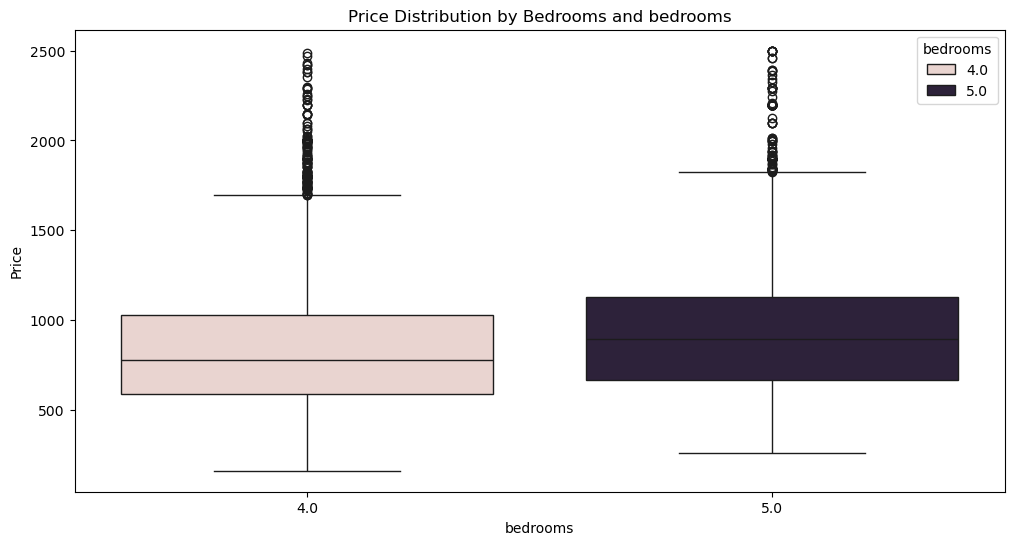


Mean Prices for bedrooms:
bedrooms        4.0         5.0
bedrooms                       
4.0       829.56784         NaN
5.0             NaN  954.596257

Price Difference (5 bed - 4 bed) for each bedrooms category:
bedrooms
4.0   NaN
5.0   NaN
dtype: float64


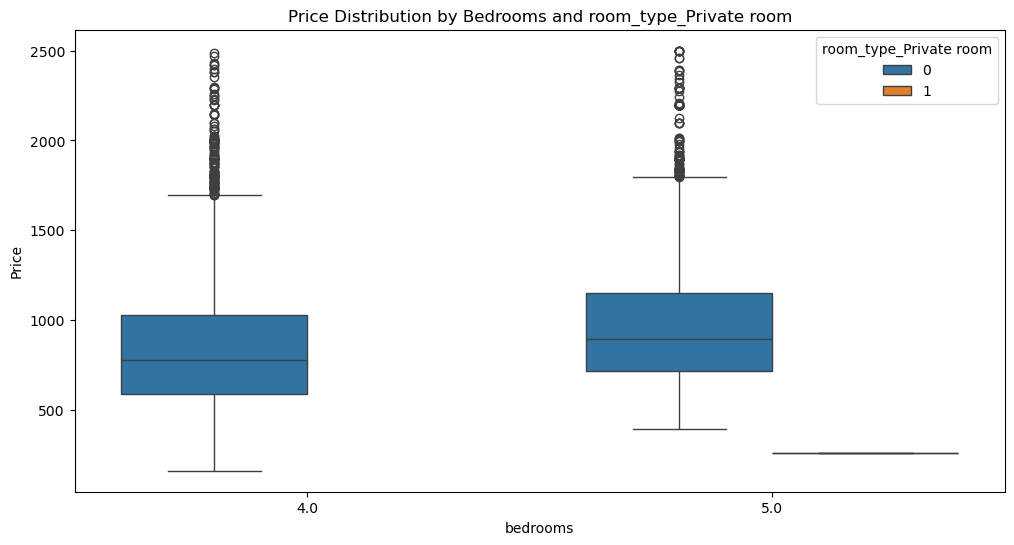


Mean Prices for room_type_Private room:
room_type_Private room           0      1
bedrooms                                 
4.0                     829.567840    NaN
5.0                     971.419785  257.0

Price Difference (5 bed - 4 bed) for each room_type_Private room category:
room_type_Private room
0    141.851944
1           NaN
dtype: float64


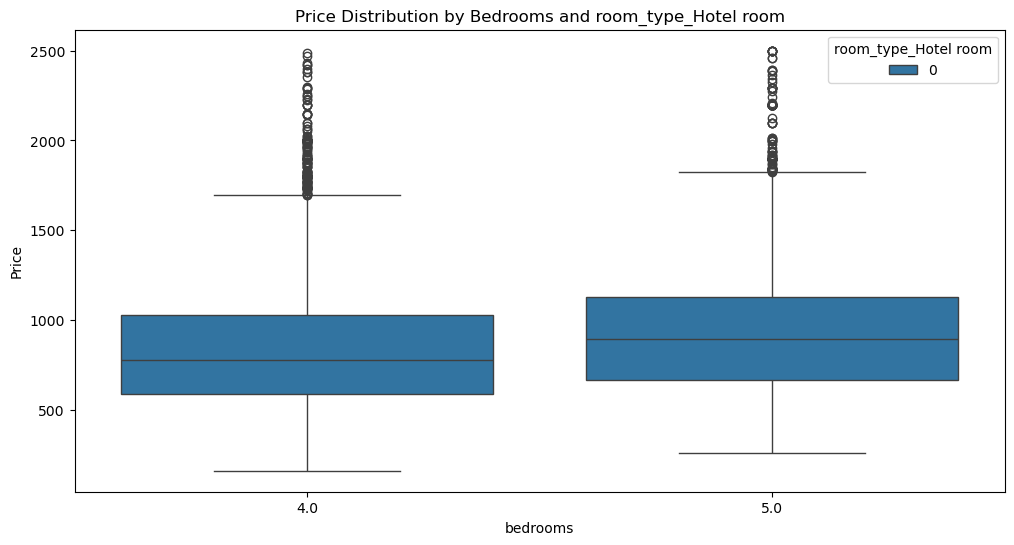


Mean Prices for room_type_Hotel room:
room_type_Hotel room           0
bedrooms                        
4.0                   829.567840
5.0                   954.596257

Price Difference (5 bed - 4 bed) for each room_type_Hotel room category:
room_type_Hotel room
0    125.028417
dtype: float64


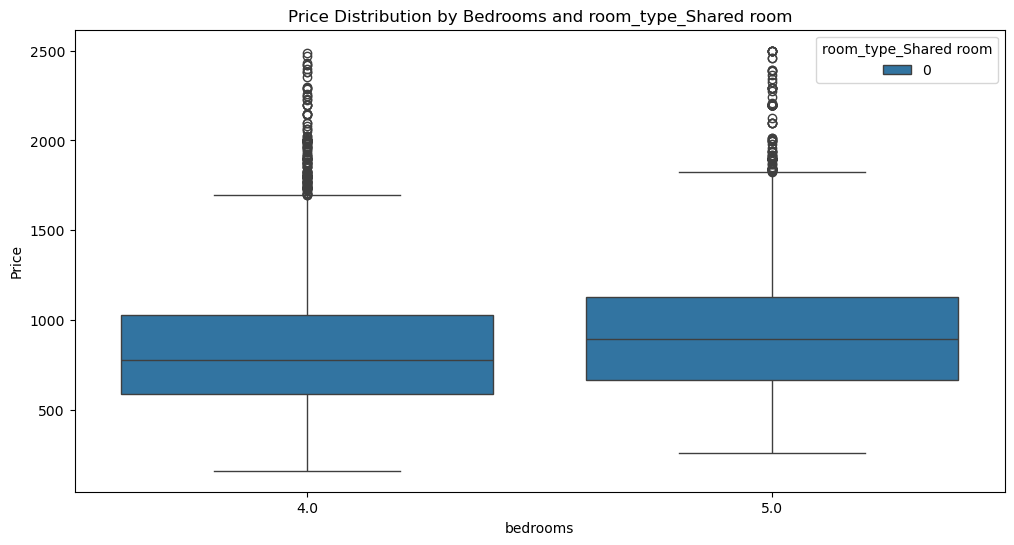


Mean Prices for room_type_Shared room:
room_type_Shared room           0
bedrooms                         
4.0                    829.567840
5.0                    954.596257

Price Difference (5 bed - 4 bed) for each room_type_Shared room category:
room_type_Shared room
0    125.028417
dtype: float64


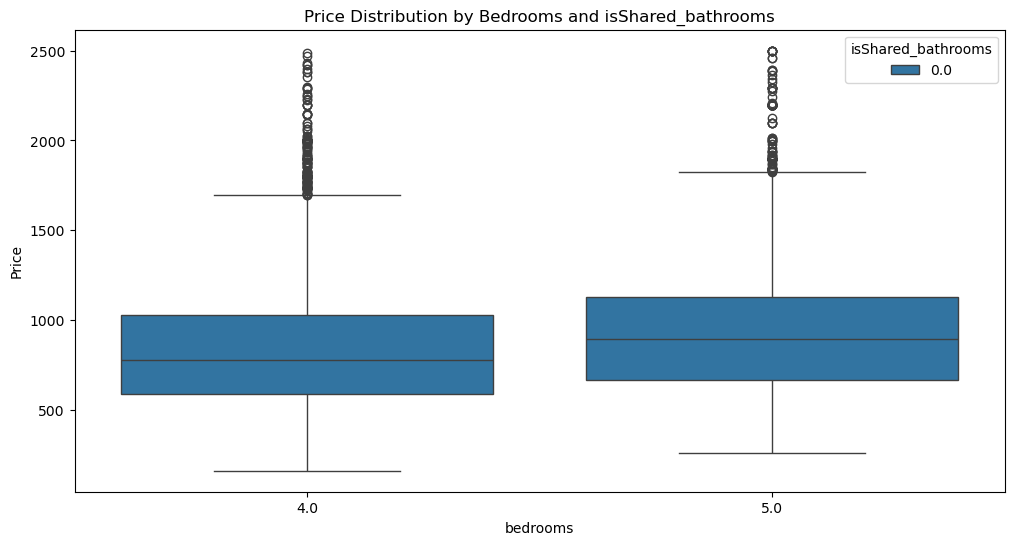


Mean Prices for isShared_bathrooms:
isShared_bathrooms         0.0
bedrooms                      
4.0                 829.567840
5.0                 954.596257

Price Difference (5 bed - 4 bed) for each isShared_bathrooms category:
isShared_bathrooms
0.0    125.028417
dtype: float64


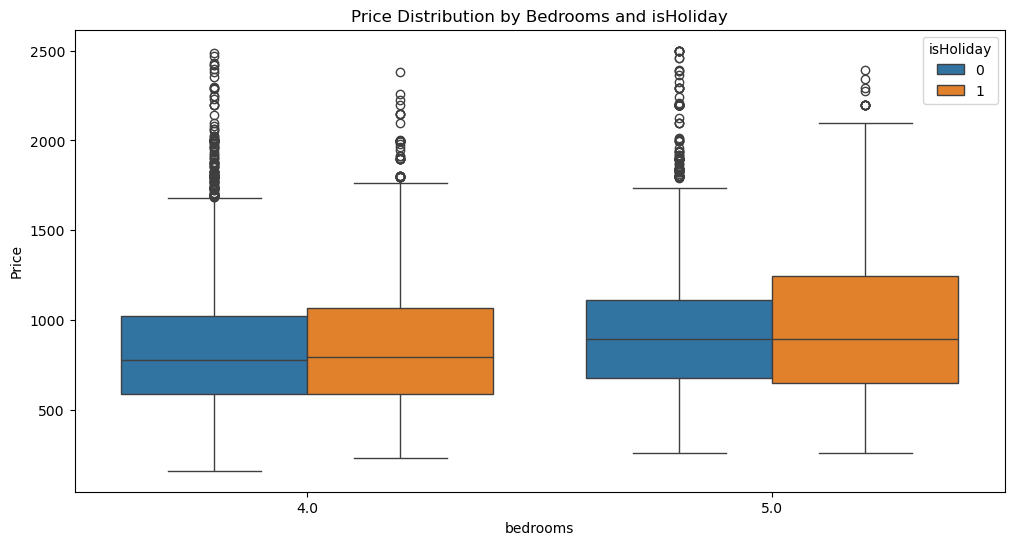


Mean Prices for isHoliday:
isHoliday           0           1
bedrooms                         
4.0        823.313084  879.605886
5.0        950.258440  988.145120

Price Difference (5 bed - 4 bed) for each isHoliday category:
isHoliday
0    126.945356
1    108.539234
dtype: float64


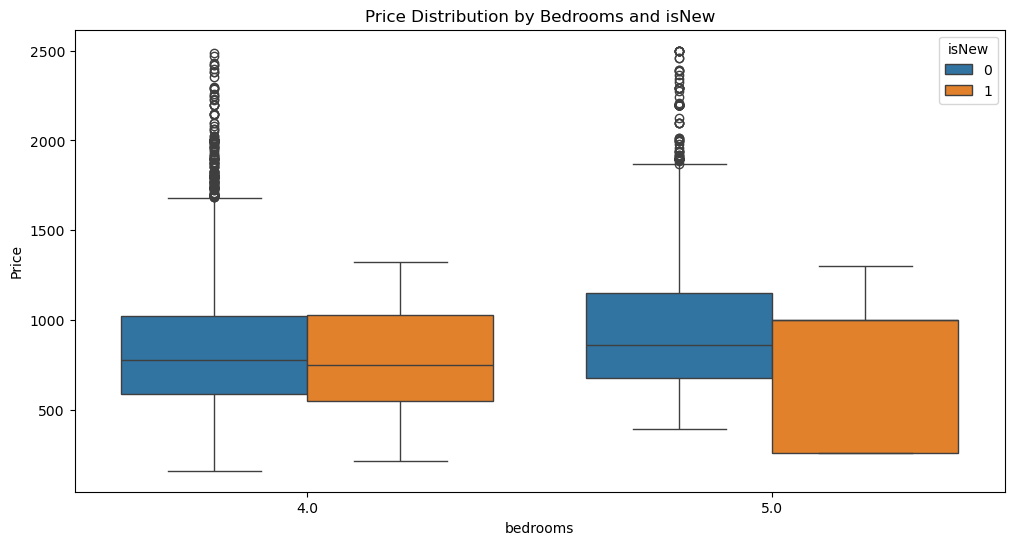


Mean Prices for isNew:
isNew              0           1
bedrooms                        
4.0       831.691063  796.313583
5.0       967.940247  812.910782

Price Difference (5 bed - 4 bed) for each isNew category:
isNew
0    136.249184
1     16.597198
dtype: float64


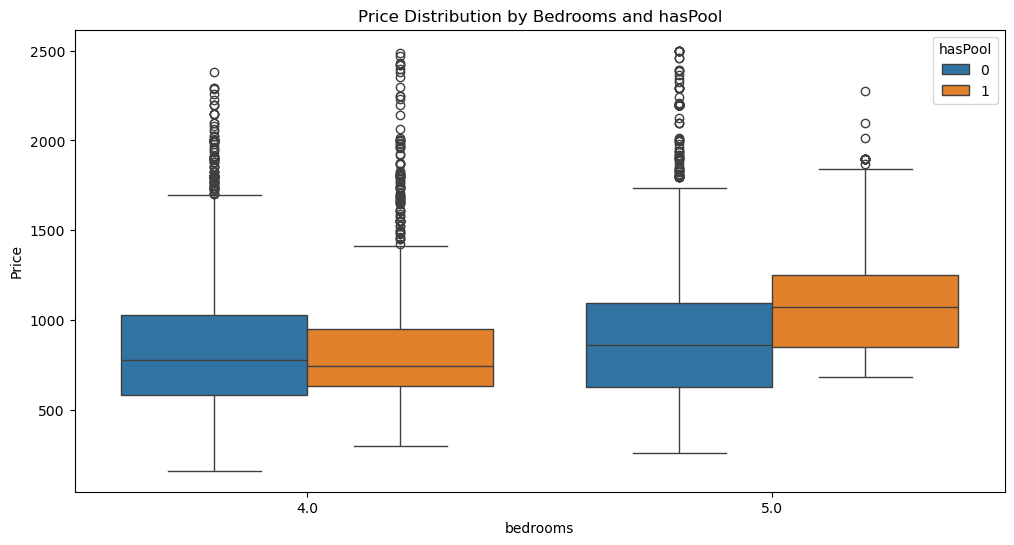


Mean Prices for hasPool:
hasPool            0            1
bedrooms                         
4.0       826.530801   856.408483
5.0       932.430859  1134.628549

Price Difference (5 bed - 4 bed) for each hasPool category:
hasPool
0    105.900058
1    278.220066
dtype: float64


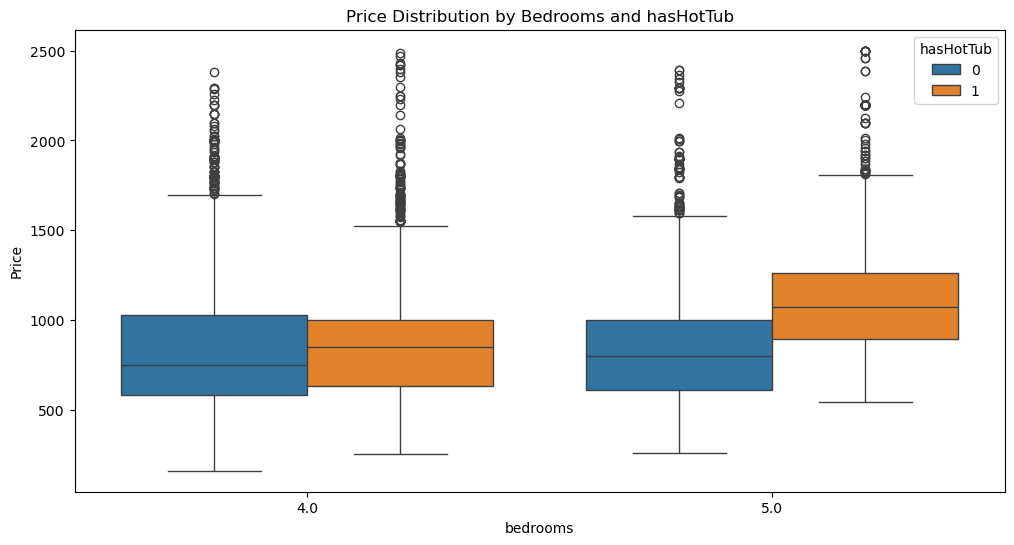


Mean Prices for hasHotTub:
hasHotTub           0            1
bedrooms                          
4.0        821.694246   875.495523
5.0        854.031139  1148.551813

Price Difference (5 bed - 4 bed) for each hasHotTub category:
hasHotTub
0     32.336893
1    273.056291
dtype: float64


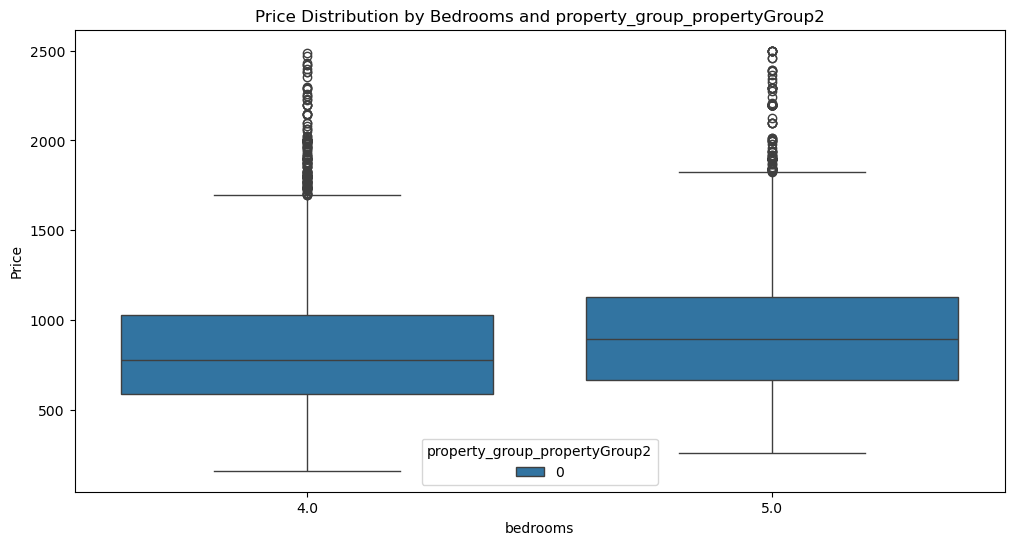


Mean Prices for property_group_propertyGroup2:
property_group_propertyGroup2           0
bedrooms                                 
4.0                            829.567840
5.0                            954.596257

Price Difference (5 bed - 4 bed) for each property_group_propertyGroup2 category:
property_group_propertyGroup2
0    125.028417
dtype: float64


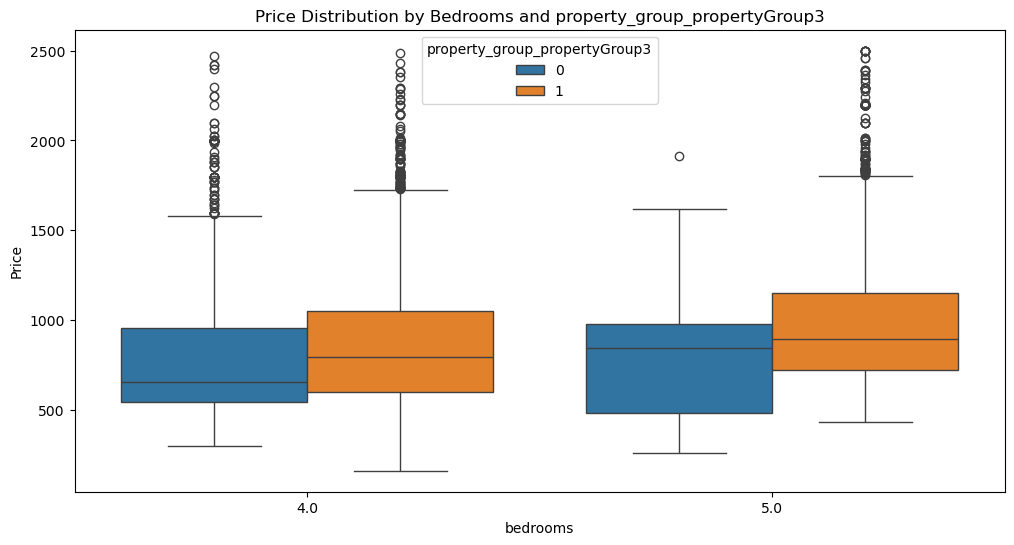


Mean Prices for property_group_propertyGroup3:
property_group_propertyGroup3           0           1
bedrooms                                             
4.0                            754.054179  848.071356
5.0                            771.717713  990.585475

Price Difference (5 bed - 4 bed) for each property_group_propertyGroup3 category:
property_group_propertyGroup3
0     17.663534
1    142.514119
dtype: float64


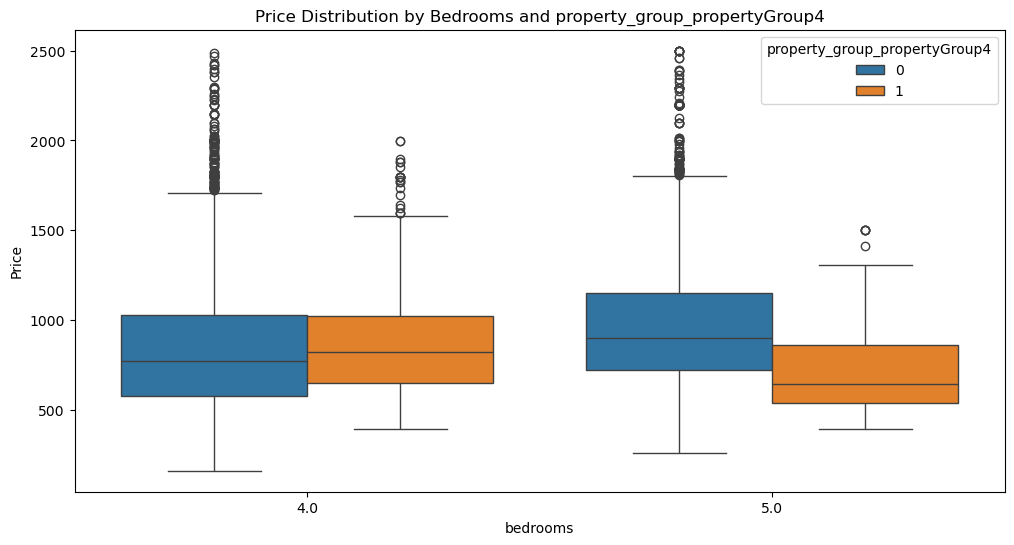


Mean Prices for property_group_propertyGroup4:
property_group_propertyGroup4           0           1
bedrooms                                             
4.0                            829.169542  834.080556
5.0                            980.156039  708.803705

Price Difference (5 bed - 4 bed) for each property_group_propertyGroup4 category:
property_group_propertyGroup4
0    150.986497
1   -125.276851
dtype: float64


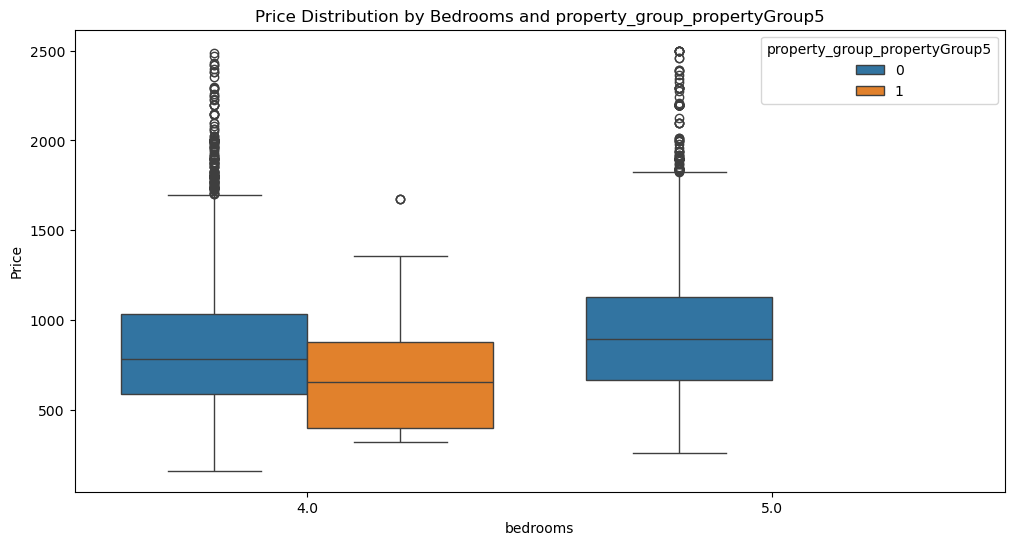


Mean Prices for property_group_propertyGroup5:
property_group_propertyGroup5           0           1
bedrooms                                             
4.0                            838.973345  681.785261
5.0                            954.596257         NaN

Price Difference (5 bed - 4 bed) for each property_group_propertyGroup5 category:
property_group_propertyGroup5
0    115.622912
1           NaN
dtype: float64


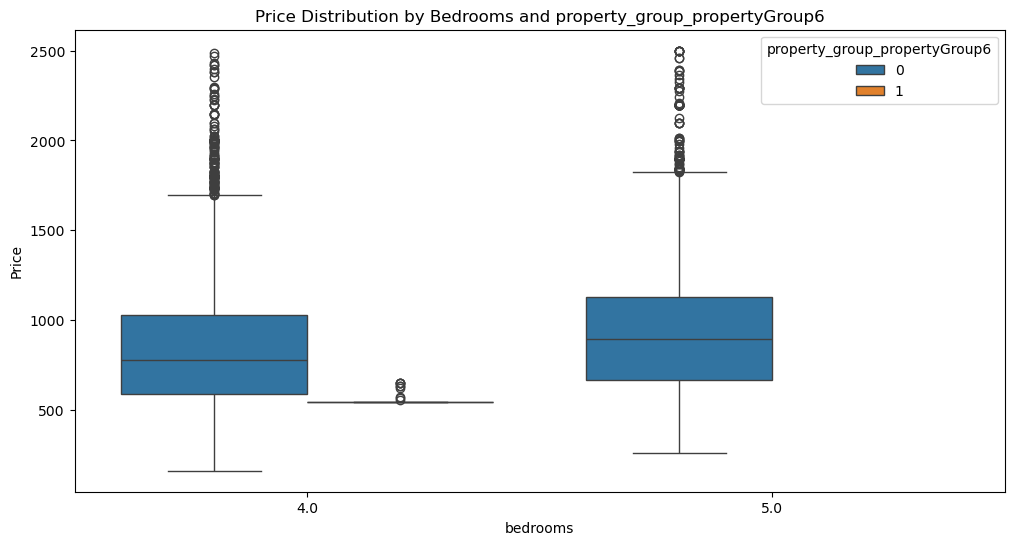


Mean Prices for property_group_propertyGroup6:
property_group_propertyGroup6           0           1
bedrooms                                             
4.0                            831.014557  554.217816
5.0                            954.596257         NaN

Price Difference (5 bed - 4 bed) for each property_group_propertyGroup6 category:
property_group_propertyGroup6
0    123.581701
1           NaN
dtype: float64


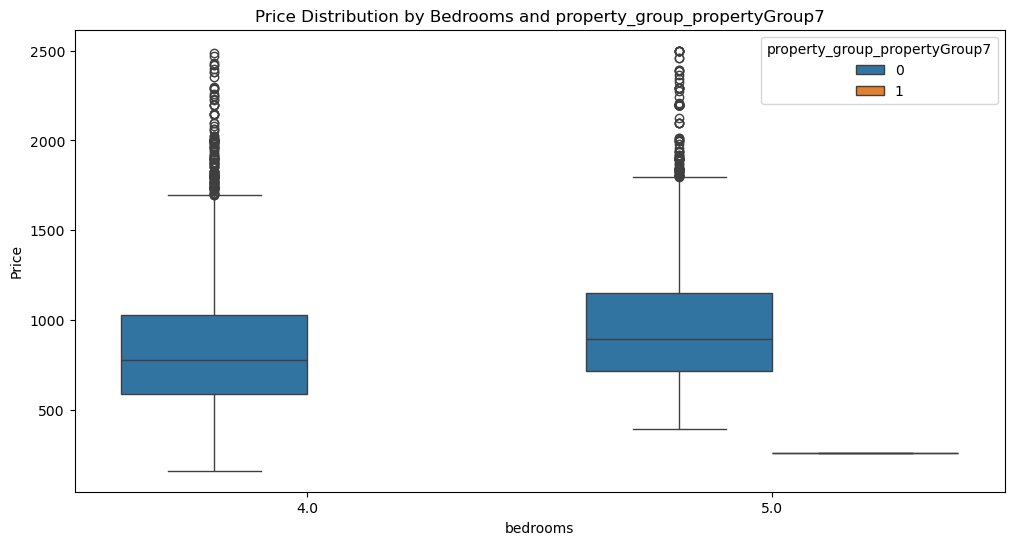


Mean Prices for property_group_propertyGroup7:
property_group_propertyGroup7           0      1
bedrooms                                        
4.0                            829.567840    NaN
5.0                            971.419785  257.0

Price Difference (5 bed - 4 bed) for each property_group_propertyGroup7 category:
property_group_propertyGroup7
0    141.851944
1           NaN
dtype: float64


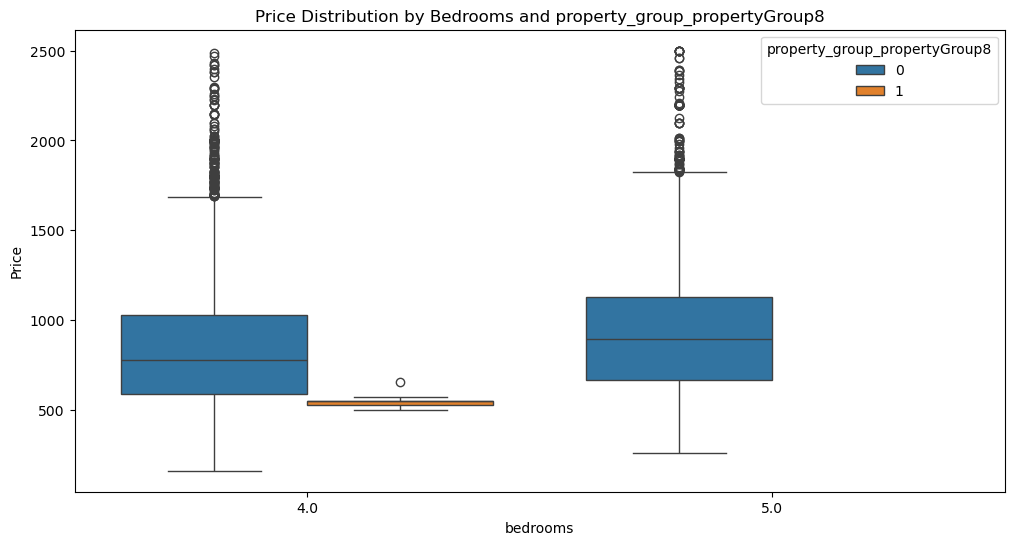


Mean Prices for property_group_propertyGroup8:
property_group_propertyGroup8           0           1
bedrooms                                             
4.0                            832.632508  539.454731
5.0                            954.596257         NaN

Price Difference (5 bed - 4 bed) for each property_group_propertyGroup8 category:
property_group_propertyGroup8
0    121.963749
1           NaN
dtype: float64


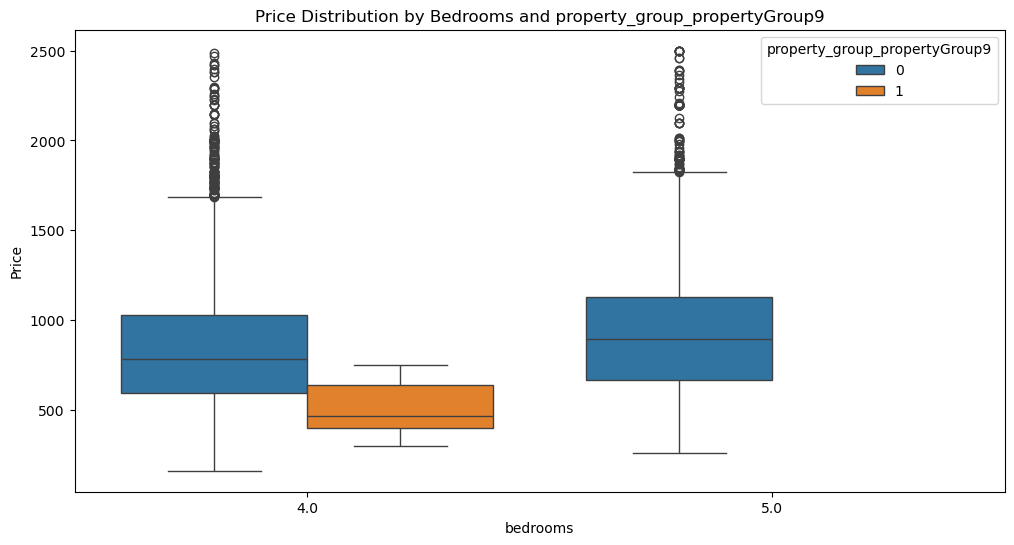


Mean Prices for property_group_propertyGroup9:
property_group_propertyGroup9           0           1
bedrooms                                             
4.0                            836.434292  507.998876
5.0                            954.596257         NaN

Price Difference (5 bed - 4 bed) for each property_group_propertyGroup9 category:
property_group_propertyGroup9
0    118.161965
1           NaN
dtype: float64


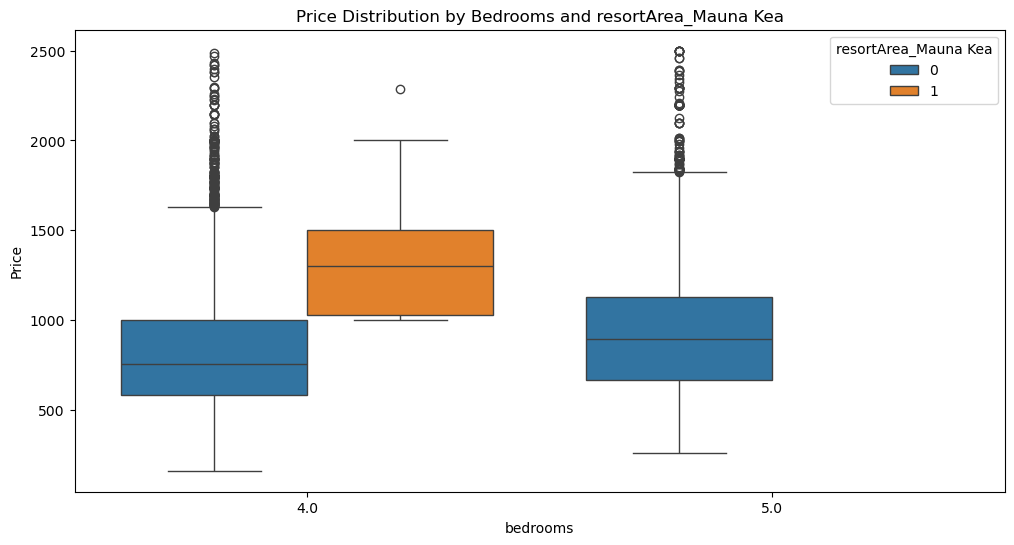


Mean Prices for resortArea_Mauna Kea:
resortArea_Mauna Kea           0            1
bedrooms                                     
4.0                   816.394883  1322.209095
5.0                   954.596257          NaN

Price Difference (5 bed - 4 bed) for each resortArea_Mauna Kea category:
resortArea_Mauna Kea
0    138.201375
1           NaN
dtype: float64


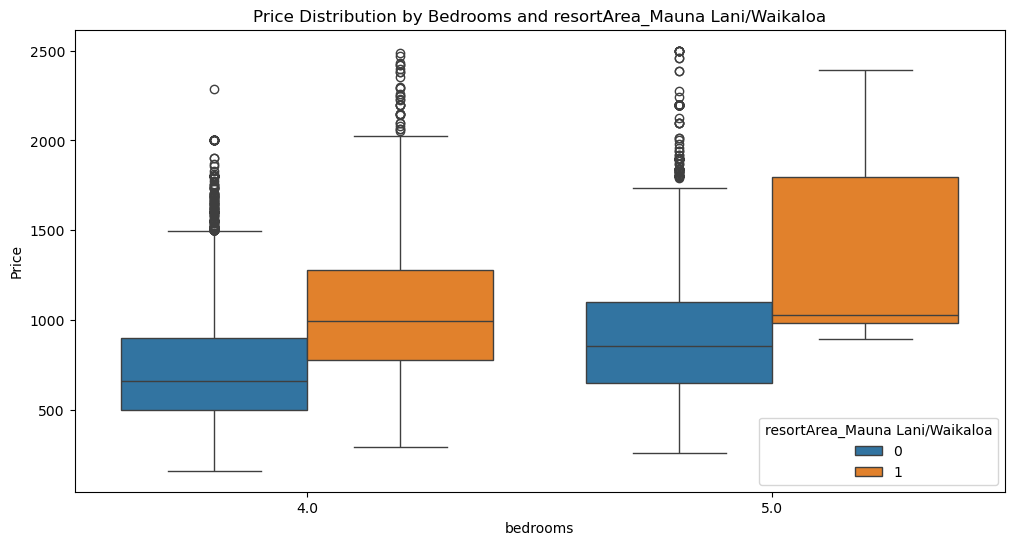


Mean Prices for resortArea_Mauna Lani/Waikaloa:
resortArea_Mauna Lani/Waikaloa           0            1
bedrooms                                               
4.0                             724.245409  1040.726054
5.0                             935.092506  1356.476190

Price Difference (5 bed - 4 bed) for each resortArea_Mauna Lani/Waikaloa category:
resortArea_Mauna Lani/Waikaloa
0    210.847097
1    315.750137
dtype: float64


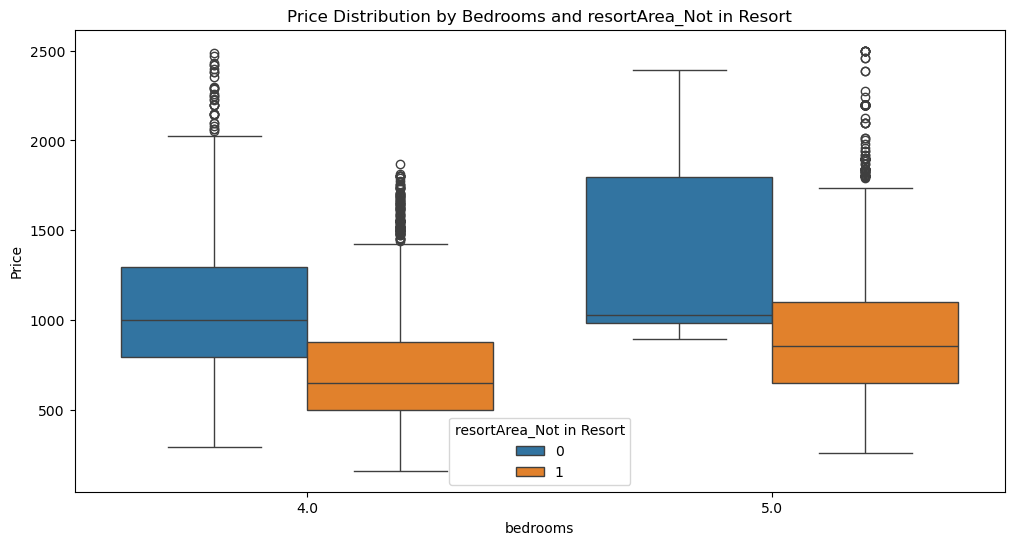


Mean Prices for resortArea_Not in Resort:
resortArea_Not in Resort            0           1
bedrooms                                         
4.0                       1061.155134  699.957073
5.0                       1356.476190  935.092506

Price Difference (5 bed - 4 bed) for each resortArea_Not in Resort category:
resortArea_Not in Resort
0    295.321056
1    235.135433
dtype: float64


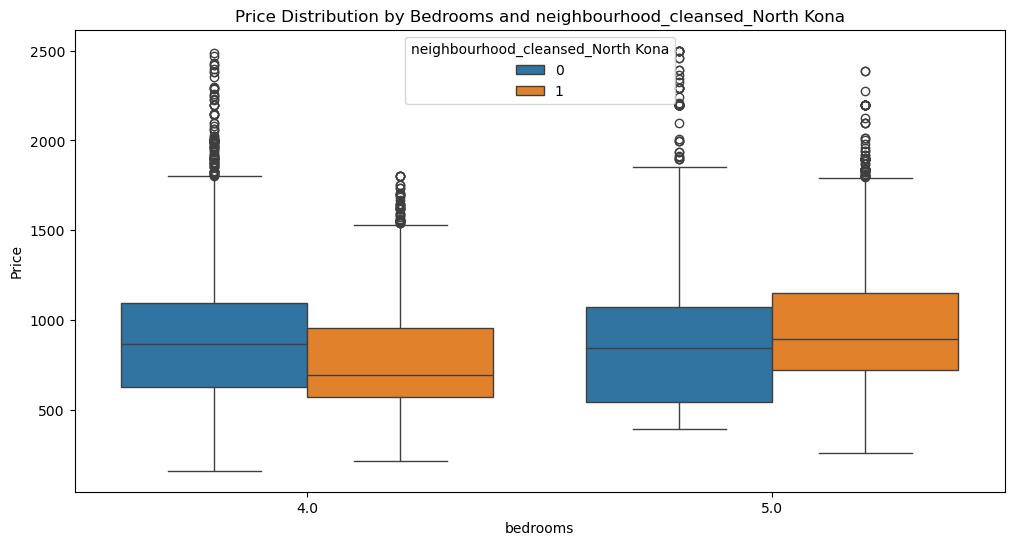


Mean Prices for neighbourhood_cleansed_North Kona:
neighbourhood_cleansed_North Kona           0           1
bedrooms                                                 
4.0                                892.298660  755.481855
5.0                                985.290327  943.660650

Price Difference (5 bed - 4 bed) for each neighbourhood_cleansed_North Kona category:
neighbourhood_cleansed_North Kona
0     92.991668
1    188.178795
dtype: float64


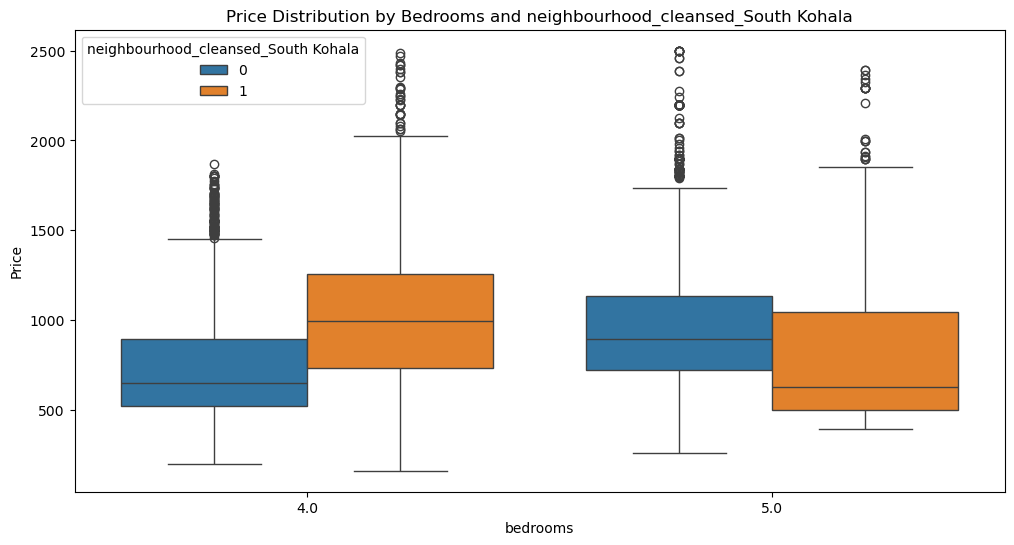


Mean Prices for neighbourhood_cleansed_South Kohala:
neighbourhood_cleansed_South Kohala          0           1
bedrooms                                                  
4.0                                  715.47602  994.839861
5.0                                  962.28562  901.192392

Price Difference (5 bed - 4 bed) for each neighbourhood_cleansed_South Kohala category:
neighbourhood_cleansed_South Kohala
0    246.809600
1    -93.647469
dtype: float64


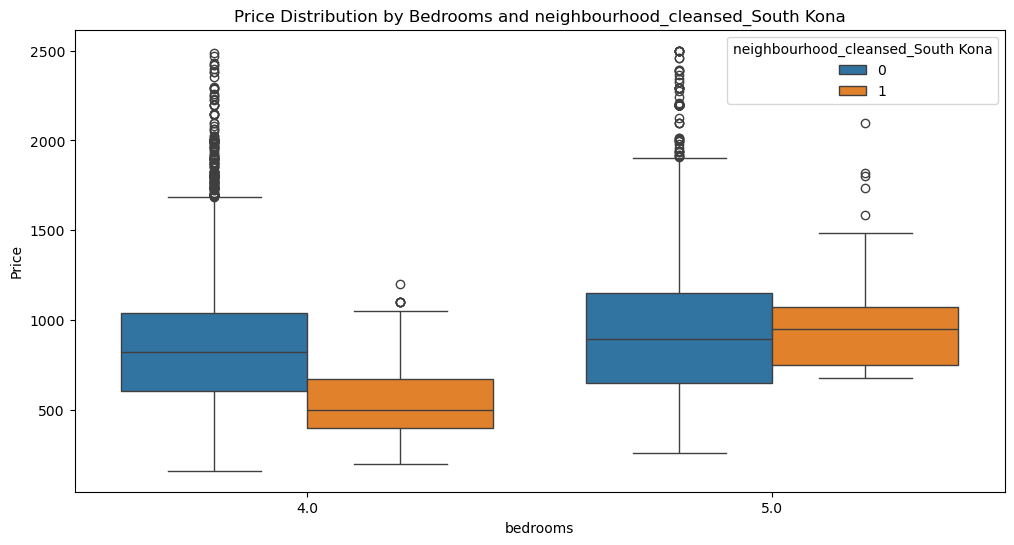


Mean Prices for neighbourhood_cleansed_South Kona:
neighbourhood_cleansed_South Kona           0           1
bedrooms                                                 
4.0                                860.589589  542.135989
5.0                                954.846151  949.540230

Price Difference (5 bed - 4 bed) for each neighbourhood_cleansed_South Kona category:
neighbourhood_cleansed_South Kona
0     94.256562
1    407.404241
dtype: float64


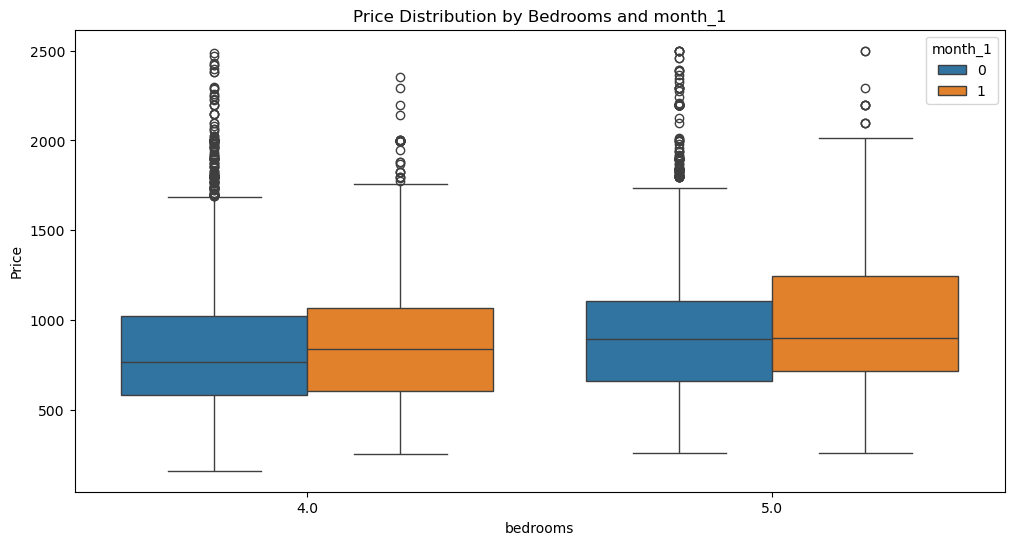


Mean Prices for month_1:
month_1            0           1
bedrooms                        
4.0       823.758297  882.958022
5.0       950.527608  990.452248

Price Difference (5 bed - 4 bed) for each month_1 category:
month_1
0    126.769310
1    107.494226
dtype: float64


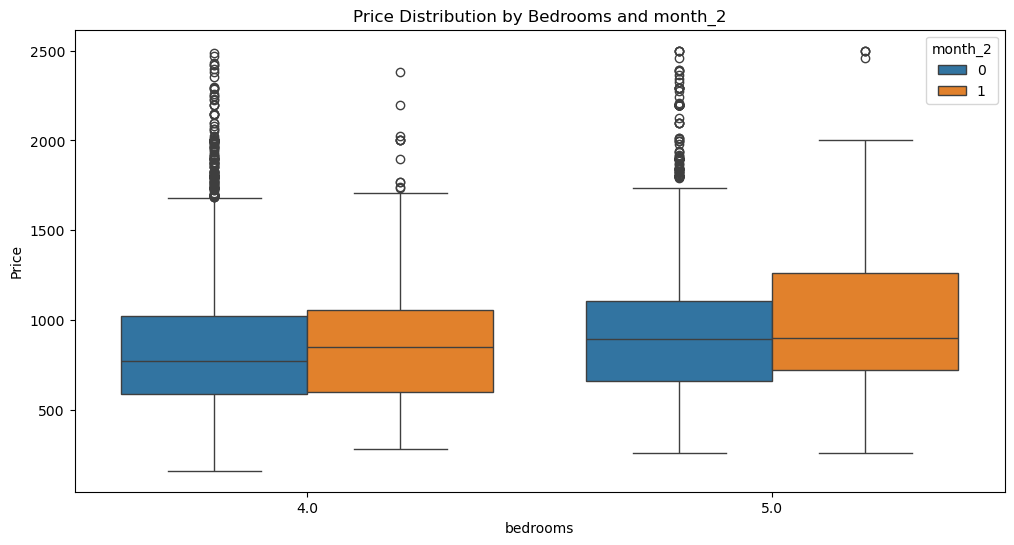


Mean Prices for month_2:
month_2            0            1
bedrooms                         
4.0       826.982305   865.288957
5.0       949.946885  1017.706678

Price Difference (5 bed - 4 bed) for each month_2 category:
month_2
0    122.964580
1    152.417721
dtype: float64


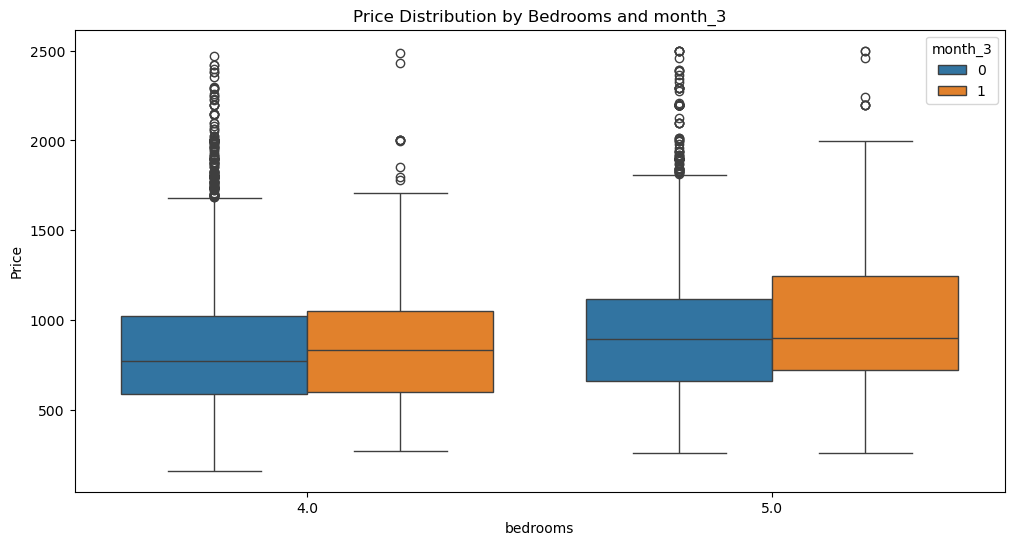


Mean Prices for month_3:
month_3            0            1
bedrooms                         
4.0       827.060163   864.015936
5.0       951.100951  1002.041420

Price Difference (5 bed - 4 bed) for each month_3 category:
month_3
0    124.040789
1    138.025484
dtype: float64


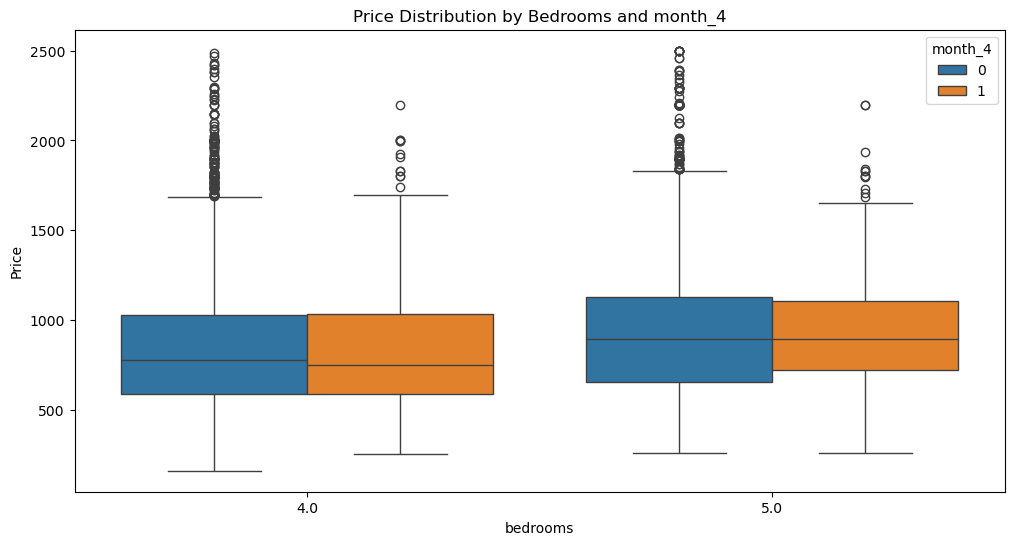


Mean Prices for month_4:
month_4            0           1
bedrooms                        
4.0       830.259025  822.448356
5.0       957.789525  920.514557

Price Difference (5 bed - 4 bed) for each month_4 category:
month_4
0    127.5305
1     98.0662
dtype: float64


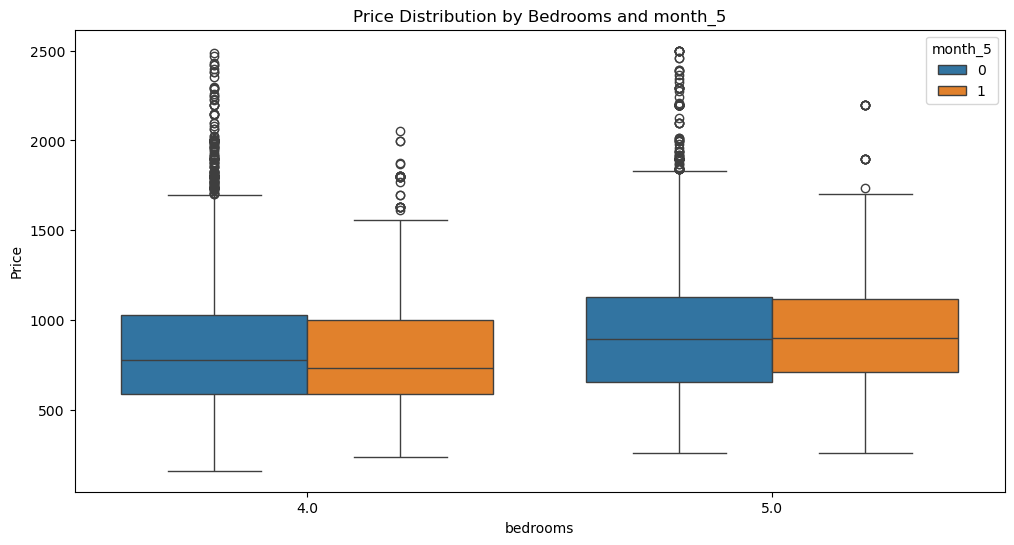


Mean Prices for month_5:
month_5            0           1
bedrooms                        
4.0       832.602327  804.281297
5.0       955.839347  943.832568

Price Difference (5 bed - 4 bed) for each month_5 category:
month_5
0    123.237019
1    139.551271
dtype: float64


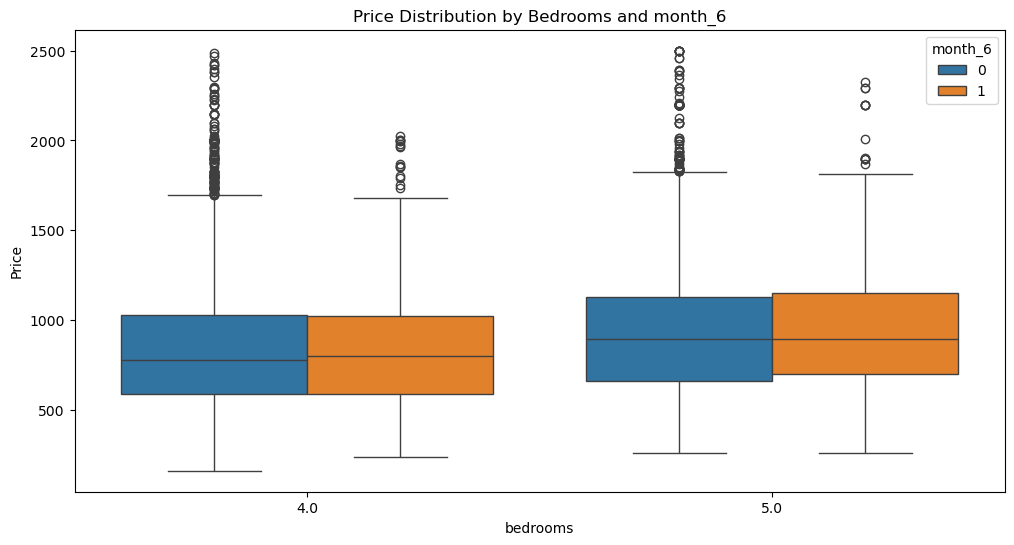


Mean Prices for month_6:
month_6            0           1
bedrooms                        
4.0       828.454796  844.330701
5.0       953.441410  970.173109

Price Difference (5 bed - 4 bed) for each month_6 category:
month_6
0    124.986614
1    125.842408
dtype: float64


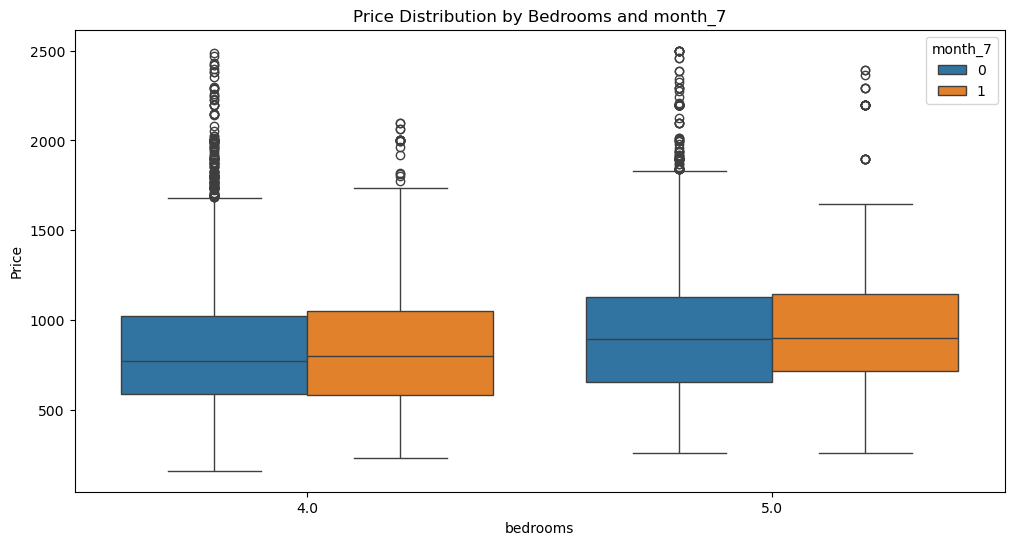


Mean Prices for month_7:
month_7            0           1
bedrooms                        
4.0       827.020556  851.388842
5.0       950.979933  986.466022

Price Difference (5 bed - 4 bed) for each month_7 category:
month_7
0    123.959376
1    135.077179
dtype: float64


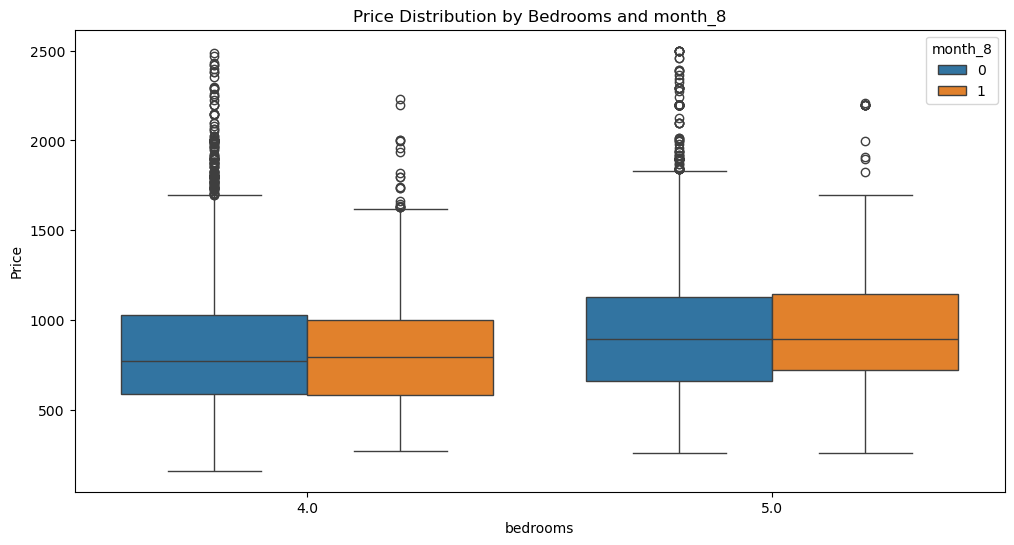


Mean Prices for month_8:
month_8            0           1
bedrooms                        
4.0       829.744062  827.224043
5.0       953.101120  974.763025

Price Difference (5 bed - 4 bed) for each month_8 category:
month_8
0    123.357058
1    147.538983
dtype: float64


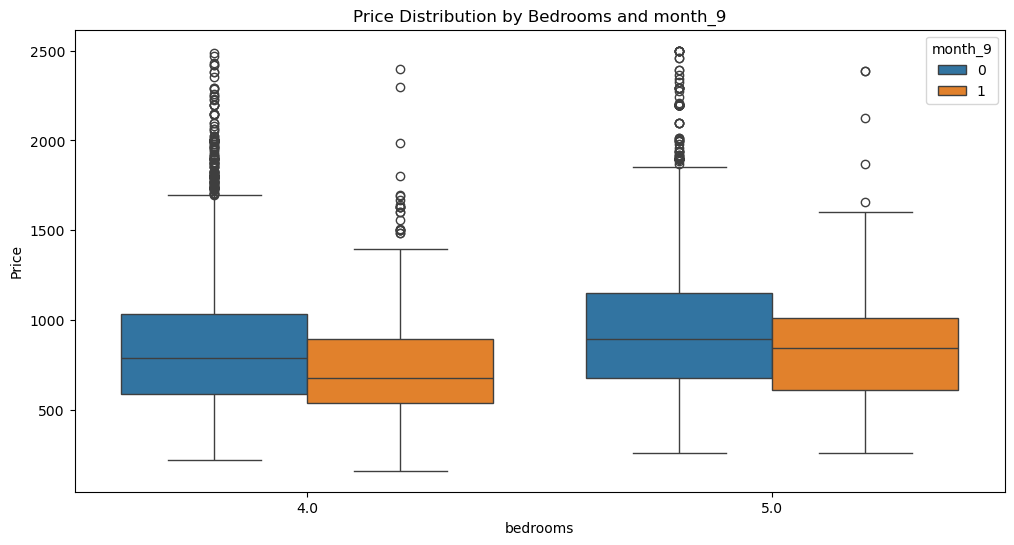


Mean Prices for month_9:
month_9            0           1
bedrooms                        
4.0       837.545403  727.300058
5.0       961.306990  865.210860

Price Difference (5 bed - 4 bed) for each month_9 category:
month_9
0    123.761587
1    137.910802
dtype: float64


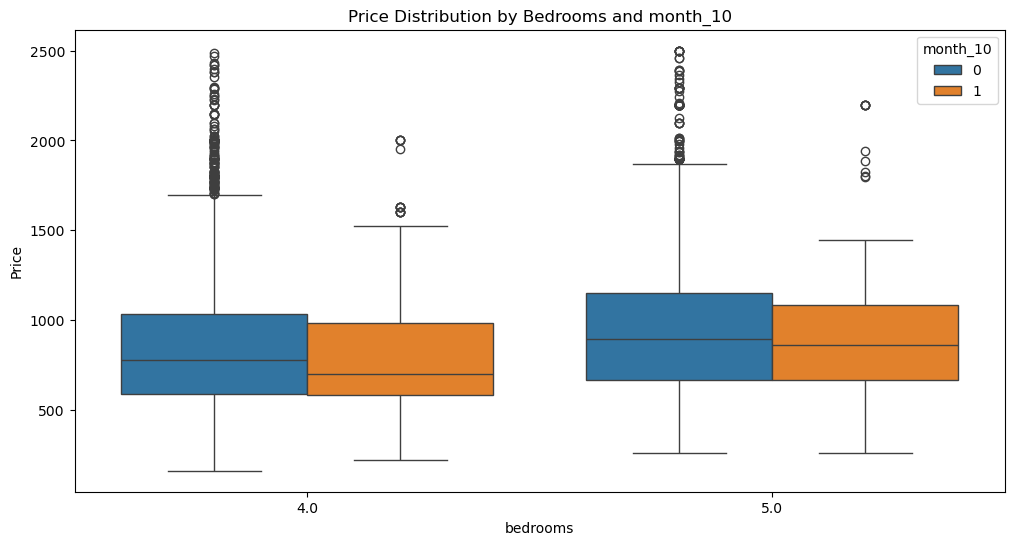


Mean Prices for month_10:
month_10           0           1
bedrooms                        
4.0       835.406487  769.828080
5.0       959.284505  908.415985

Price Difference (5 bed - 4 bed) for each month_10 category:
month_10
0    123.878018
1    138.587905
dtype: float64


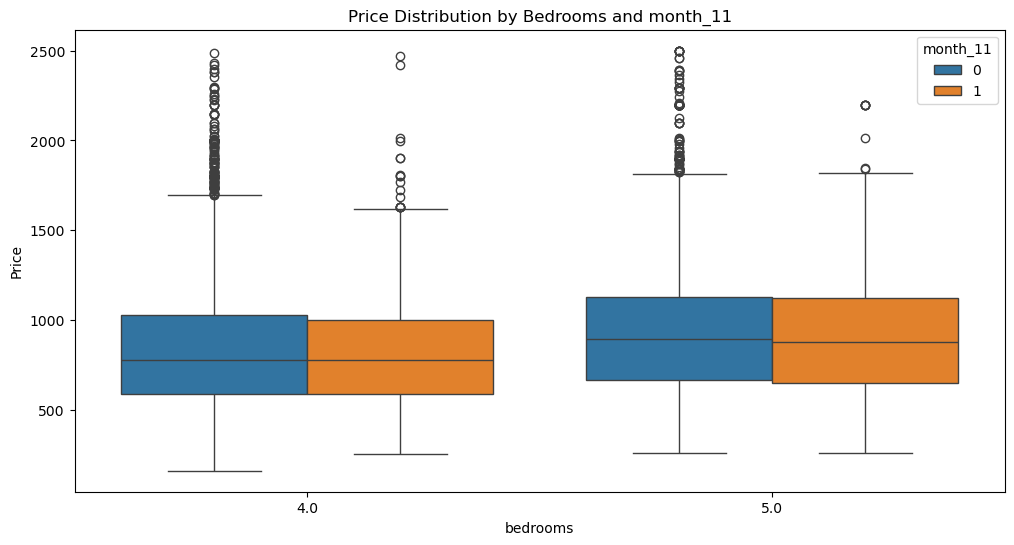


Mean Prices for month_11:
month_11           0           1
bedrooms                        
4.0       831.539293  808.510652
5.0       955.943550  940.928248

Price Difference (5 bed - 4 bed) for each month_11 category:
month_11
0    124.404257
1    132.417597
dtype: float64


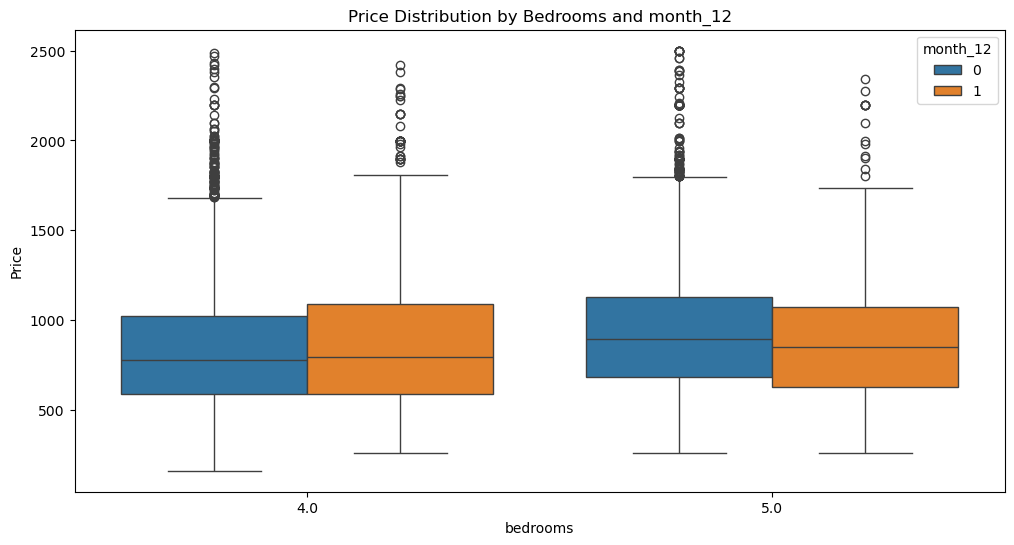


Mean Prices for month_12:
month_12           0           1
bedrooms                        
4.0       824.440136  889.101650
5.0       955.896193  939.643703

Price Difference (5 bed - 4 bed) for each month_12 category:
month_12
0    131.456057
1     50.542053
dtype: float64


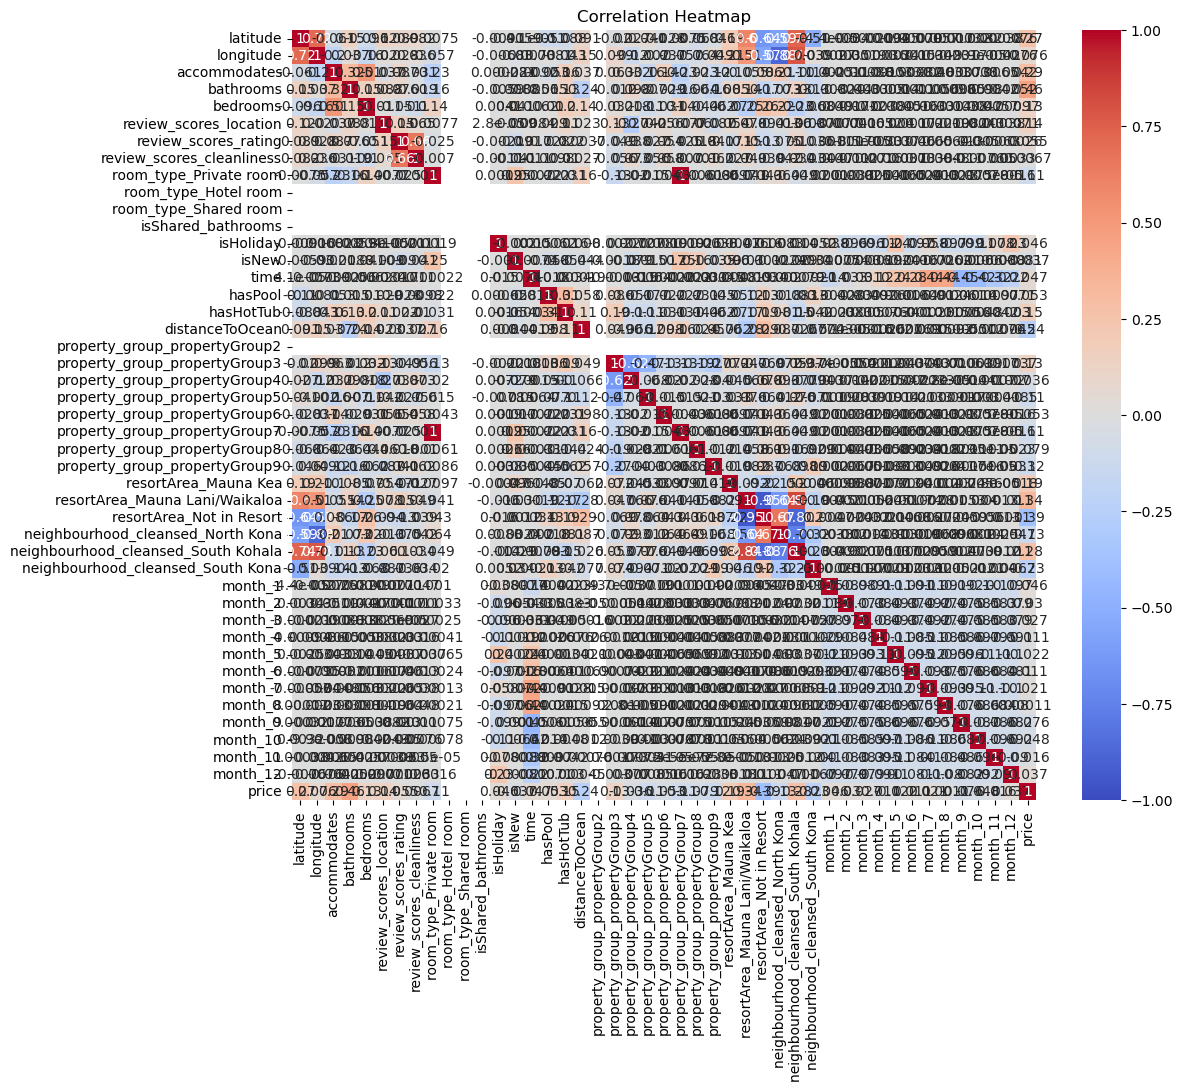

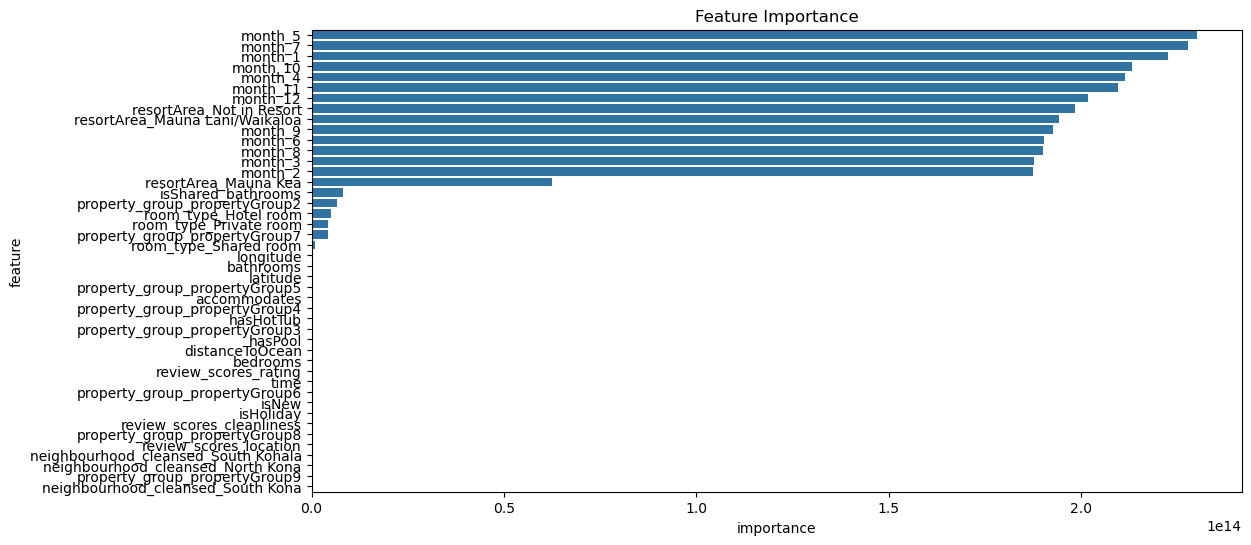


Top 10 Most Important Features:
                           feature    importance
36                         month_5  2.301098e+14
38                         month_7  2.277748e+14
32                         month_1  2.226178e+14
41                        month_10  2.130618e+14
35                         month_4  2.113121e+14
42                        month_11  2.095408e+14
43                        month_12  2.017155e+14
28        resortArea_Not in Resort  1.984579e+14
27  resortArea_Mauna Lani/Waikaloa  1.942278e+14
40                         month_9  1.927085e+14


In [28]:

# Filter for 4 and 5 bedroom listings
df_45 = df[df['bedrooms'].isin([4, 5])]

# Use the existing 'features' variable for analysis
features_to_analyze=features
# Function to analyze and plot feature interactions
def analyze_feature_interaction(feature):
    plt.figure(figsize=(12, 6))
    sns.boxplot(x='bedrooms', y='price', hue=feature, data=df_45)
    plt.title(f'Price Distribution by Bedrooms and {feature}')
    plt.ylabel('Price')
    plt.show()
    
    # Calculate mean price for each combination
    mean_prices = df_45.groupby(['bedrooms', feature])['price'].mean().unstack()
    print(f"\nMean Prices for {feature}:")
    print(mean_prices)
    
    # Calculate price difference between 4 and 5 bedrooms for each category
    price_diff = mean_prices.loc[5] - mean_prices.loc[4]
    print(f"\nPrice Difference (5 bed - 4 bed) for each {feature} category:")
    print(price_diff)

# Analyze interactions for each feature in the 'features' list
for feature in features_to_analyze:
    if df_45[feature].nunique() < 10:  # Only for features with less than 10 unique values
        analyze_feature_interaction(feature)

# Correlation analysis
correlation_matrix = df_45[features_to_analyze + ['price']].corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title('Correlation Heatmap')
plt.show()

# Feature importance (using a simple linear regression)
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

X = df_45[features_to_analyze]
y = df_45['price']

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Fit linear regression
model = LinearRegression()
model.fit(X_scaled, y)

# Get feature importance
feature_importance = pd.DataFrame({
    'feature': features_to_analyze,
    'importance': np.abs(model.coef_)
})
feature_importance = feature_importance.sort_values('importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(12, 6))
sns.barplot(x='importance', y='feature', data=feature_importance)
plt.title('Feature Importance')
plt.show()

print("\nTop 10 Most Important Features:")
print(feature_importance.head(10))


# addedAmenityFeatures.csv is a csv that contains other features that were not used in the model

In [30]:
added_features_df=pd.read_csv('addedAmenityFeatures.csv')

In [32]:
added_columns=['elevation',
    "availability_365",
    "IsOcean_view",
    "IsPrivate_patio_or_balcony",
    "IsMountain_view",
    "IsBeach_access",
    "IsGolf_course_view",
    "IsBay_view",
    "IsSea_view",
    "IsResort_access",
    "IsResort_view",
    "IsHarbor_view",
    "IsValley_view",
    "IsLake_access",
    "Issea_view",
    "IsHarbor_View",
    "IsBeach_access_–_Beachfront",
    "IsFree_beach_club",
    "IsPrivate_beach_access_–_Beachfront",
    "IsPrivate_beach_access",
    "IsMarina_view",
    "IsFree_resort_access",
    "IsGolf_course_access",
    "IsBeach_access___Beachfront",
    "IsPrivate_beach_access___Beachfront"
]
D={}
for item in added_columns:
    D[item]='first'

added_features_df=added_features_df.groupby('listing_id').agg(D)

In [24]:
joined=pd.merge(df,added_features_df,on='listing_id',how='inner')

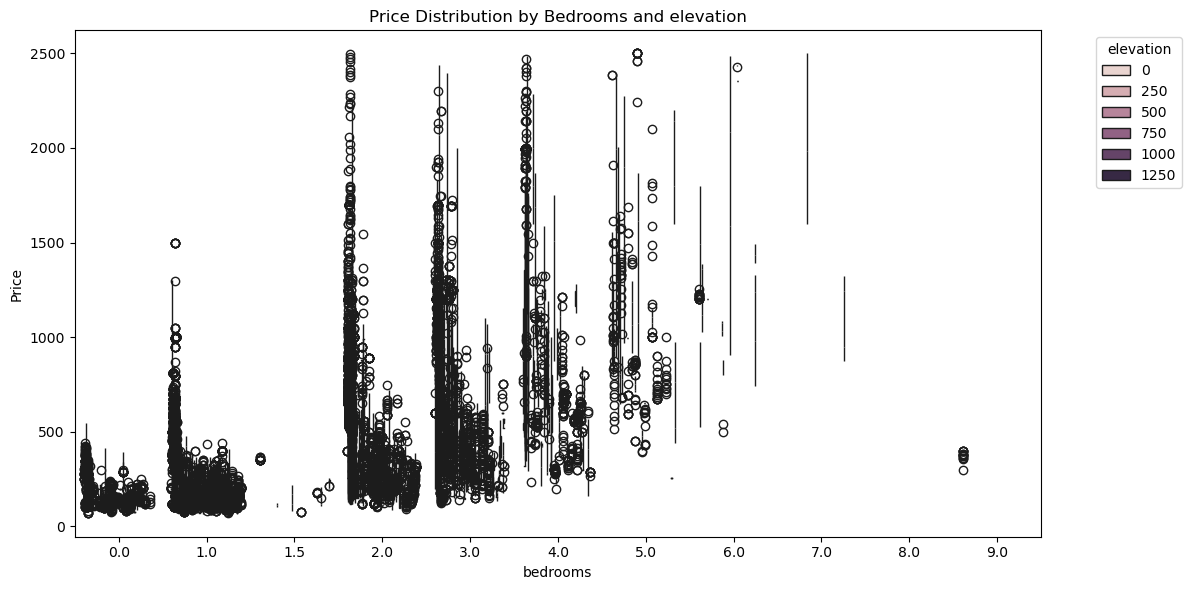


Mean Prices for elevation:
elevation     -3.0         -2.0     -1.0         0.0         1.0     \
bedrooms                                                              
0.0               NaN          NaN      NaN  153.831759         NaN   
1.0        200.089245   122.361915      NaN  232.802926  255.000000   
1.5               NaN          NaN      NaN         NaN         NaN   
2.0               NaN   379.713362    255.0  363.845765         NaN   
3.0               NaN  1121.046003      NaN  919.107087         NaN   
4.0               NaN          NaN      NaN  761.053649  731.043534   
5.0               NaN          NaN      NaN         NaN         NaN   
6.0               NaN          NaN      NaN         NaN         NaN   
7.0               NaN          NaN      NaN         NaN         NaN   
8.0               NaN          NaN      NaN         NaN         NaN   
9.0               NaN          NaN      NaN         NaN         NaN   

elevation       2.0         3.0          4.0    

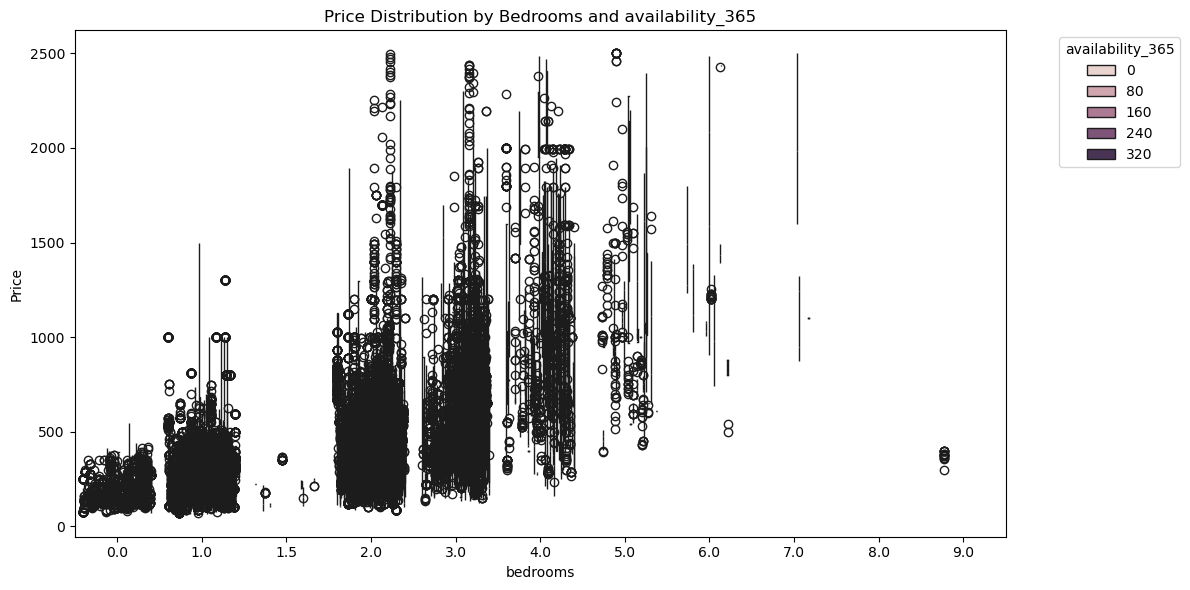


Mean Prices for availability_365:
availability_365         0           1           2           3           4    \
bedrooms                                                                       
0.0               161.097783   95.250575  155.000000  136.533498  168.822674   
1.0               227.914056  180.000000  157.716287  299.310037  379.948892   
1.5                      NaN         NaN         NaN         NaN         NaN   
2.0               319.777919  242.224138  550.273810  485.000000  308.068776   
3.0               667.937591  325.003448         NaN         NaN         NaN   
4.0               933.297841  548.187192         NaN         NaN  325.554187   
5.0                      NaN         NaN         NaN         NaN         NaN   
6.0               972.000000         NaN         NaN         NaN         NaN   
7.0                      NaN         NaN         NaN         NaN         NaN   
8.0                      NaN         NaN         NaN         NaN         NaN   
9.0  

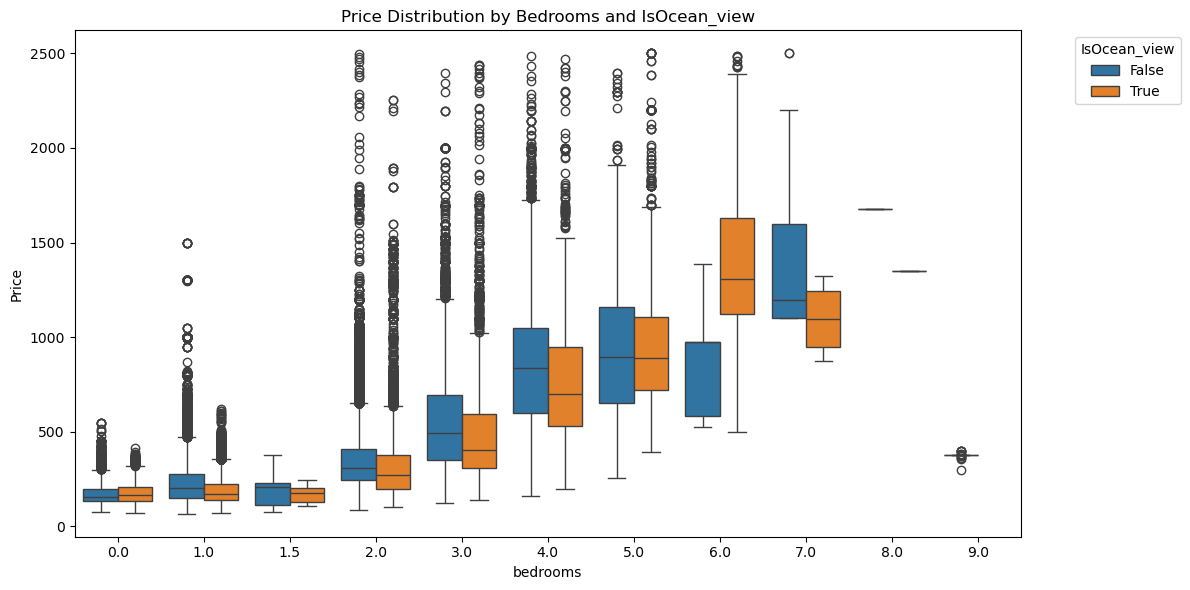


Mean Prices for IsOcean_view:
IsOcean_view        False        True 
bedrooms                              
0.0            174.227996   181.316469
1.0            230.845549   190.347142
1.5            192.912481   174.540483
2.0            347.192279   319.507391
3.0            559.965176   481.836199
4.0            868.278123   761.659110
5.0            942.852760   966.406697
6.0            835.705518  1451.972417
7.0           1319.113570  1096.959184
8.0           1675.000000  1350.000000
9.0            377.724754          NaN


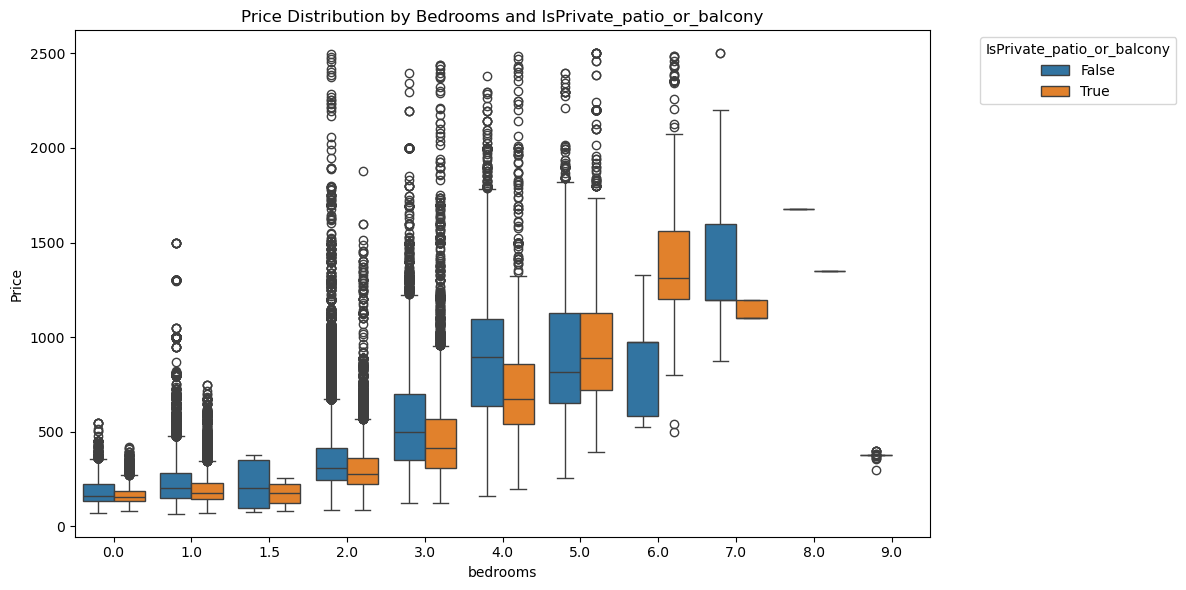


Mean Prices for IsPrivate_patio_or_balcony:
IsPrivate_patio_or_balcony        False        True 
bedrooms                                            
0.0                          182.521634   167.598130
1.0                          231.033420   197.760563
1.5                          207.975615   178.470305
2.0                          352.335624   309.767156
3.0                          568.935290   471.348928
4.0                          896.313070   715.749487
5.0                          928.620584   988.920381
6.0                          791.717851  1449.072738
7.0                         1448.348819  1139.206186
8.0                         1675.000000  1350.000000
9.0                          377.724754          NaN


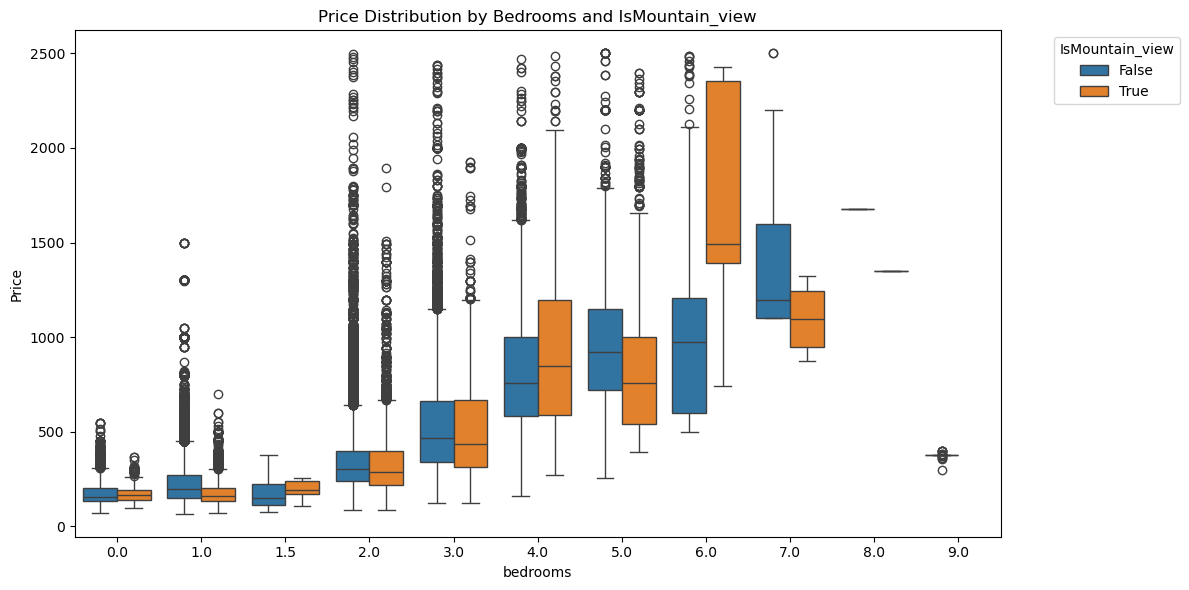


Mean Prices for IsMountain_view:
IsMountain_view        False        True 
bedrooms                                 
0.0               176.254113   170.930162
1.0               224.801440   178.618357
1.5               184.761112   191.536212
2.0               342.894810   341.265577
3.0               542.992652   515.129009
4.0               811.090804   892.812474
5.0               966.325888   918.573689
6.0              1012.211494  1726.570079
7.0              1319.113570  1096.959184
8.0              1675.000000  1350.000000
9.0               377.724754          NaN


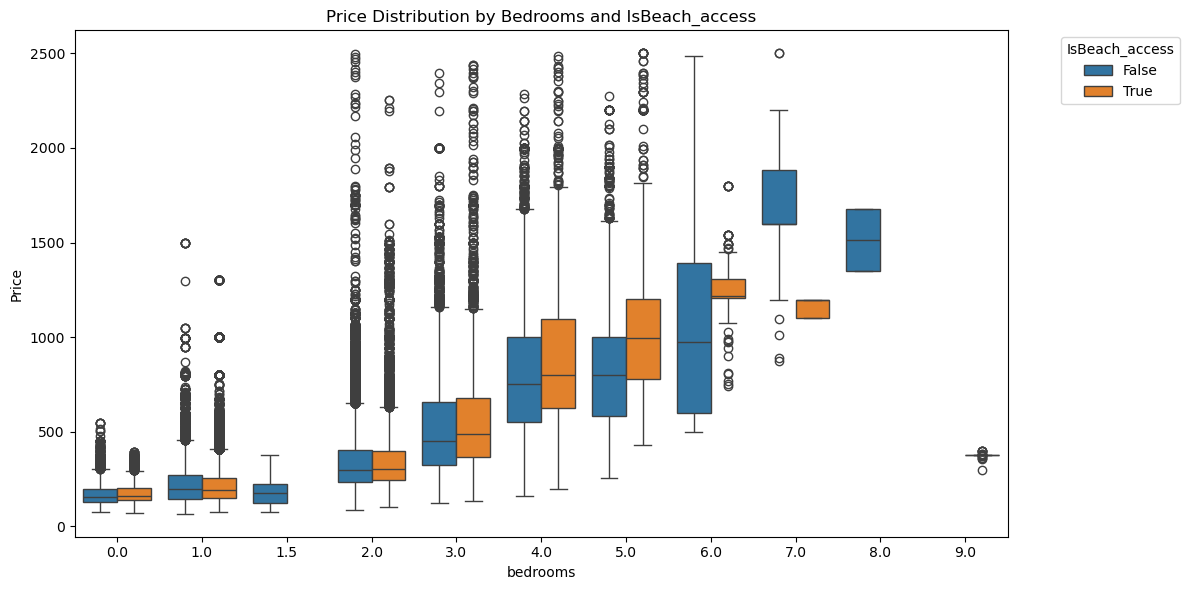


Mean Prices for IsBeach_access:
IsBeach_access        False        True 
bedrooms                                
0.0              176.236133   175.283055
1.0              218.115287   229.784086
1.5              187.447989          NaN
2.0              341.481836   347.258617
3.0              536.806916   547.765786
4.0              813.346867   868.377175
5.0              869.603346  1063.614042
6.0             1120.952864  1260.432071
7.0             1670.844689  1161.580645
8.0             1512.500000          NaN
9.0                     NaN   377.724754


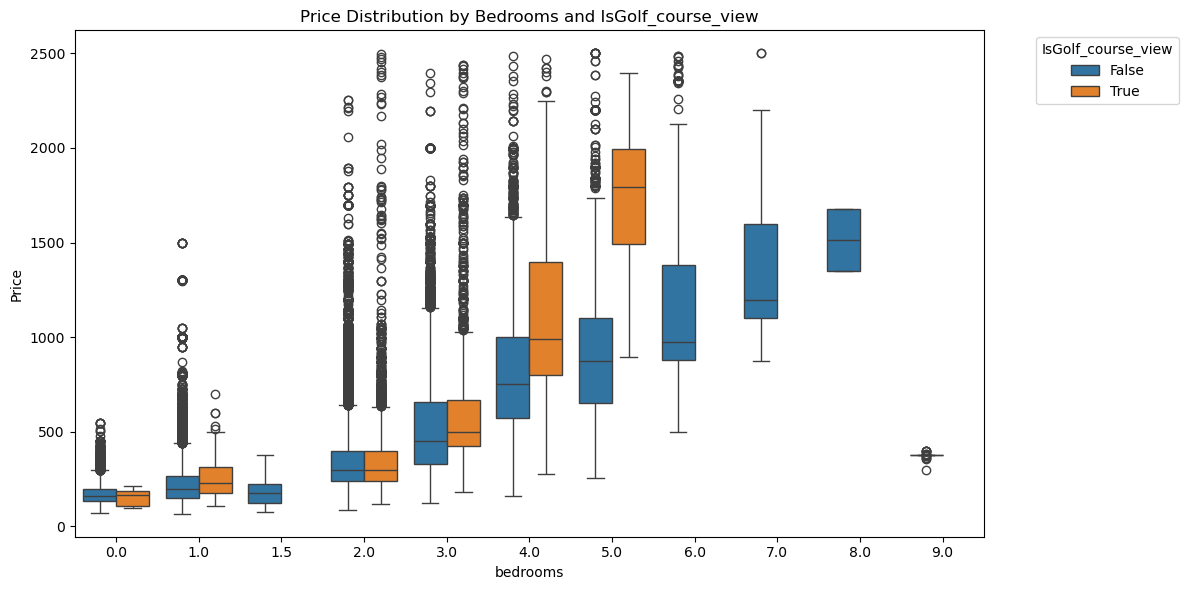


Mean Prices for IsGolf_course_view:
IsGolf_course_view        False        True 
bedrooms                                    
0.0                  176.016101   153.628561
1.0                  220.902817   260.079541
1.5                  187.447989          NaN
2.0                  342.209400   356.191366
3.0                  535.082821   597.368846
4.0                  809.121399  1101.134467
5.0                  936.744393  1708.132832
6.0                 1147.336069          NaN
7.0                 1312.045022          NaN
8.0                 1512.500000          NaN
9.0                  377.724754          NaN


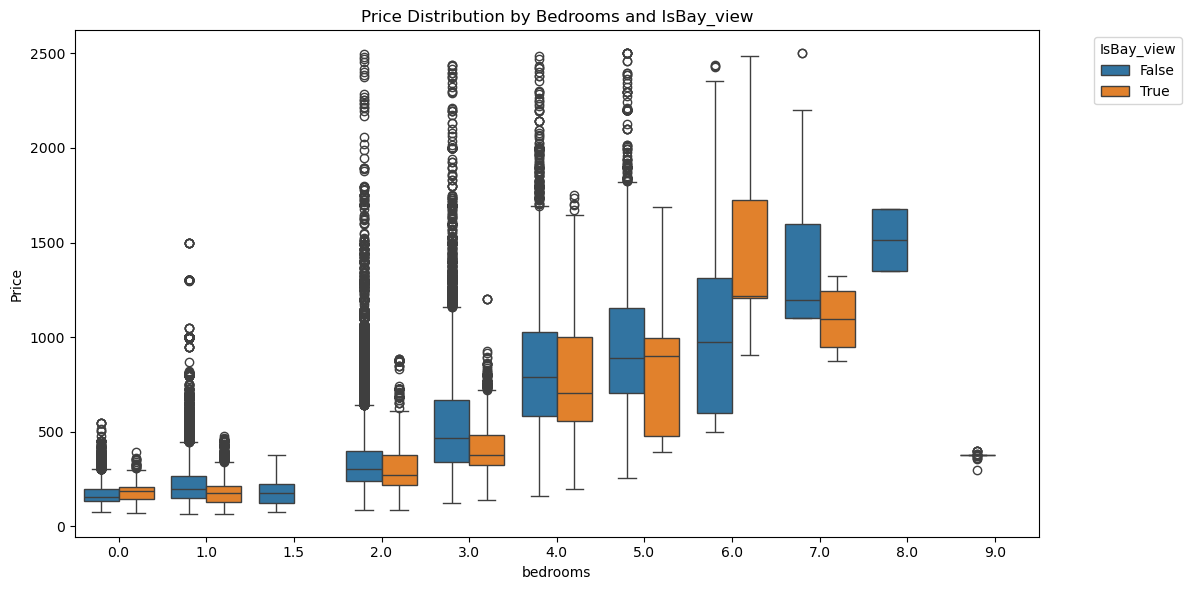


Mean Prices for IsBay_view:
IsBay_view        False        True 
bedrooms                            
0.0          175.393729   186.927662
1.0          223.226392   184.694153
1.5          187.447989          NaN
2.0          343.922927   305.341714
3.0          543.749229   420.451725
4.0          836.783575   762.778941
5.0          968.357273   768.984447
6.0         1092.441745  1488.179913
7.0         1319.113570  1096.959184
8.0         1512.500000          NaN
9.0          377.724754          NaN


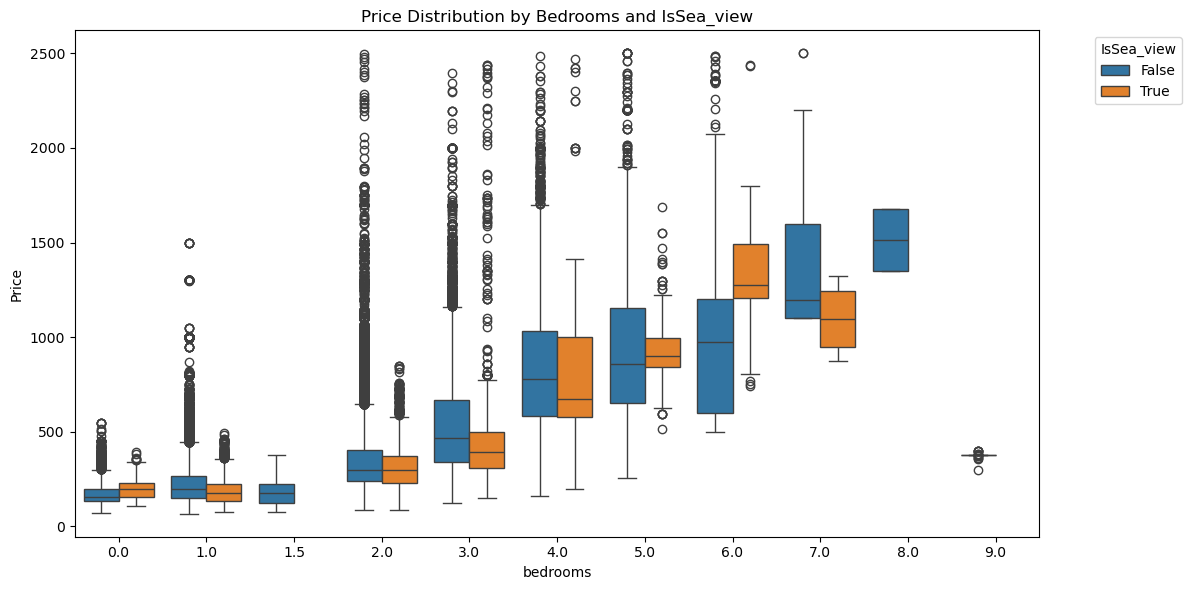


Mean Prices for IsSea_view:
IsSea_view        False        True 
bedrooms                            
0.0          174.930286   201.185997
1.0          222.928554   193.892036
1.5          187.447989          NaN
2.0          343.902141   315.003740
3.0          543.546312   452.816465
4.0          833.898353   773.526868
5.0          954.813534   952.324457
6.0         1082.250022  1328.027330
7.0         1319.113570  1096.959184
8.0         1512.500000          NaN
9.0          377.724754          NaN


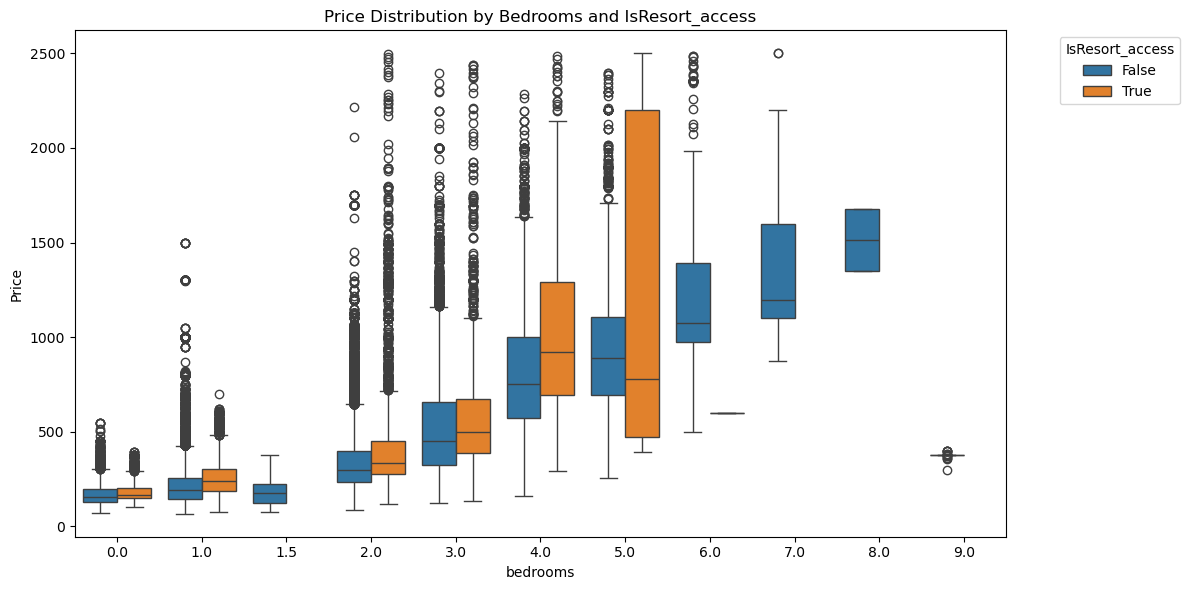


Mean Prices for IsResort_access:
IsResort_access        False        True 
bedrooms                                 
0.0               174.044712   194.016223
1.0               218.388162   256.638890
1.5               187.447989          NaN
2.0               336.750489   395.256214
3.0               536.866690   555.139754
4.0               808.622264  1004.933971
5.0               941.284218  1151.460844
6.0              1190.527214   600.000000
7.0              1312.045022          NaN
8.0              1512.500000          NaN
9.0               377.724754          NaN


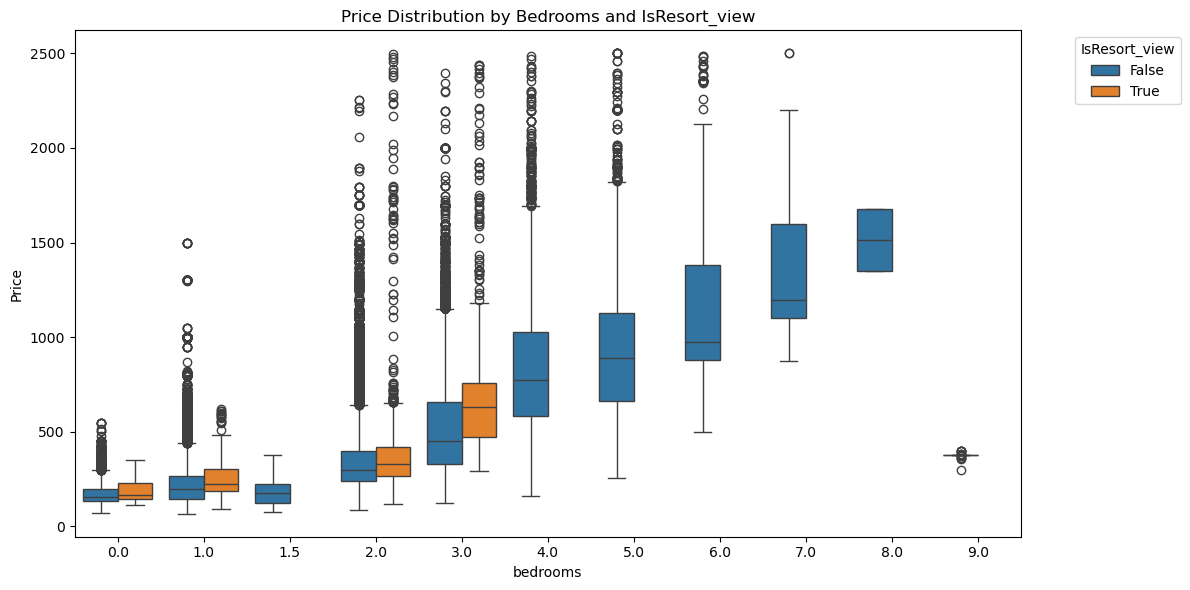


Mean Prices for IsResort_view:
IsResort_view        False       True 
bedrooms                              
0.0             175.750256  181.760812
1.0             221.054600  248.780931
1.5             187.447989         NaN
2.0             342.078761  374.176875
3.0             535.218403  684.687483
4.0             829.567840         NaN
5.0             954.596257         NaN
6.0            1147.336069         NaN
7.0            1312.045022         NaN
8.0            1512.500000         NaN
9.0             377.724754         NaN


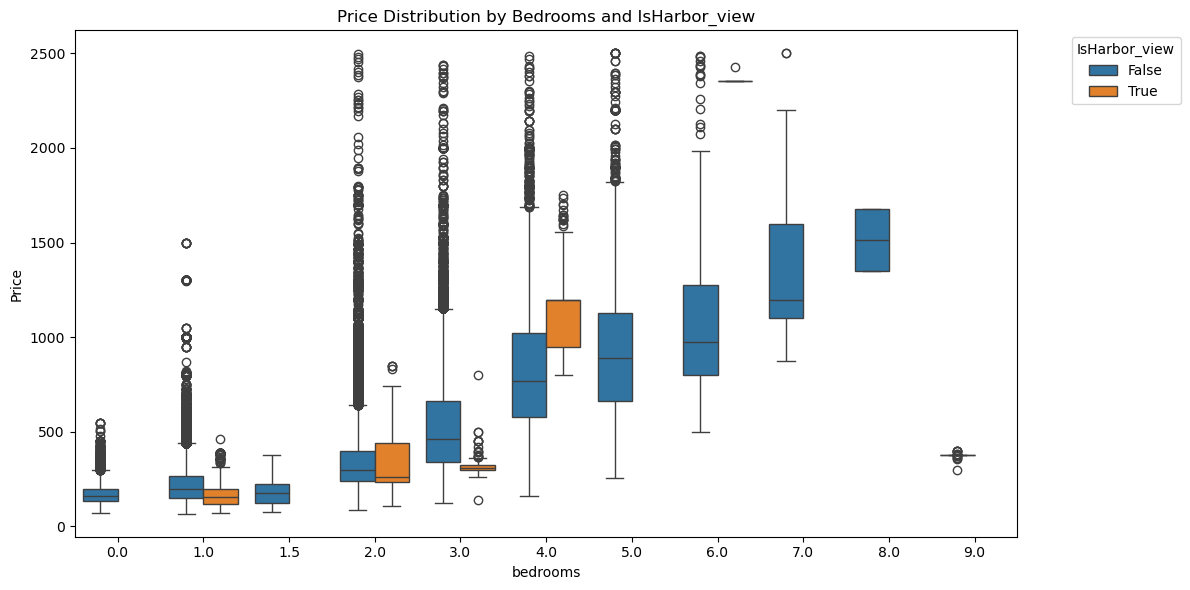


Mean Prices for IsHarbor_view:
IsHarbor_view        False        True 
bedrooms                               
0.0             175.843133          NaN
1.0             221.839708   173.693865
1.5             187.447989          NaN
2.0             342.881891   331.841183
3.0             540.184291   319.452629
4.0             825.194064  1144.508490
5.0             954.596257          NaN
6.0            1051.939653  2356.238916
7.0            1312.045022          NaN
8.0            1512.500000          NaN
9.0             377.724754          NaN


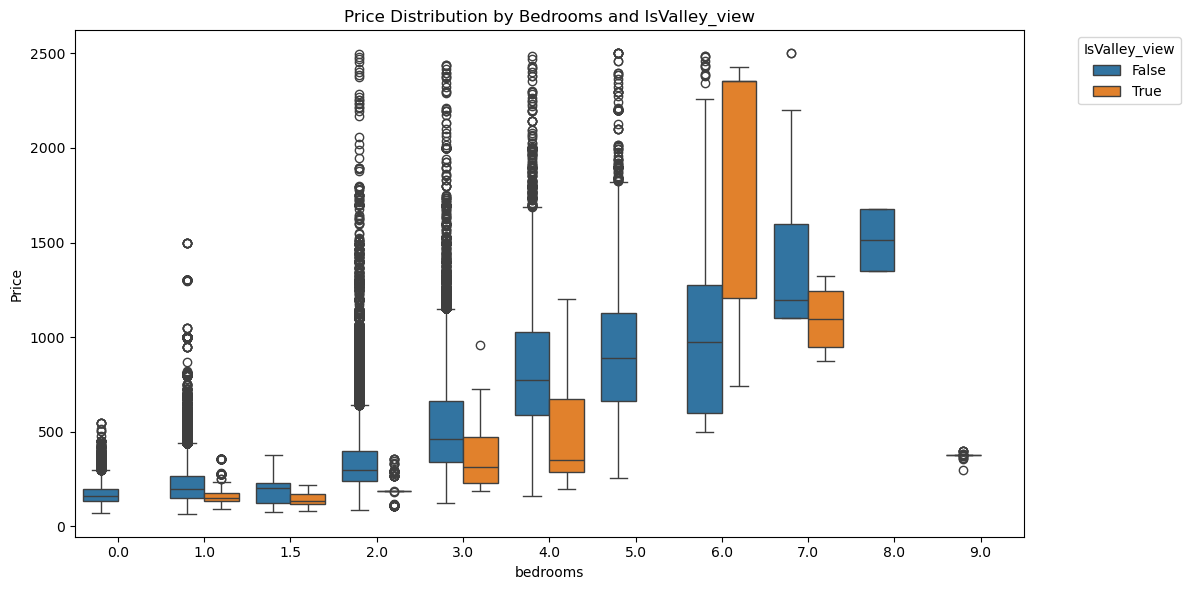


Mean Prices for IsValley_view:
IsValley_view        False        True 
bedrooms                               
0.0             175.843133          NaN
1.0             221.753812   168.693670
1.5             192.496587   141.575390
2.0             343.152240   194.832028
3.0             540.724654   362.225104
4.0             835.879346   524.595862
5.0             954.596257          NaN
6.0            1049.646716  1891.686465
7.0            1319.113570  1096.959184
8.0            1512.500000          NaN
9.0             377.724754          NaN


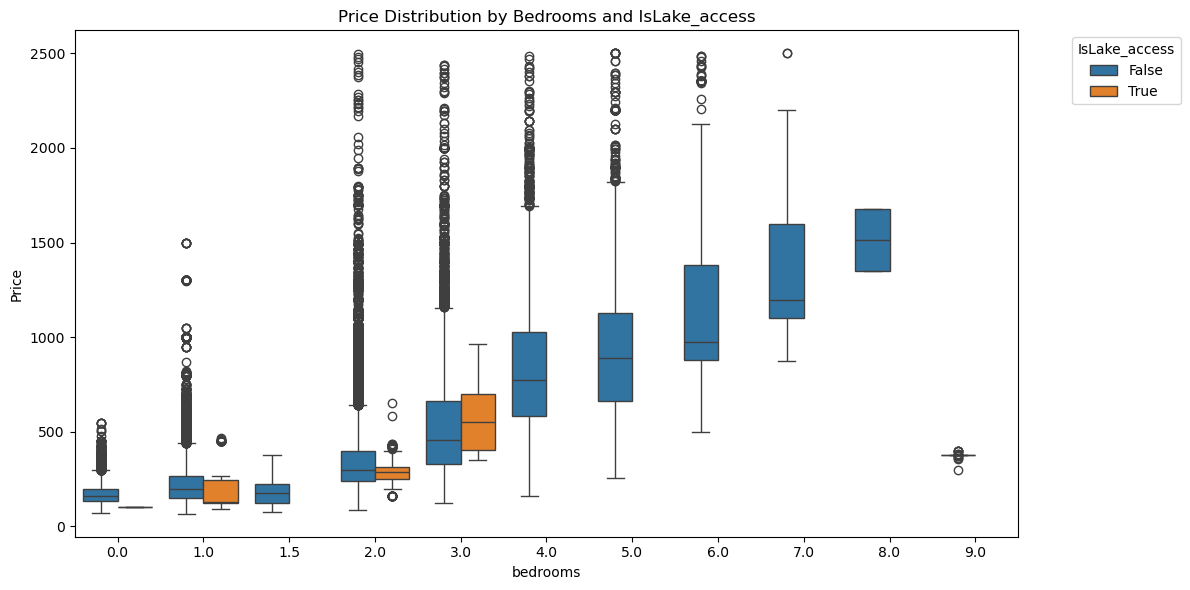


Mean Prices for IsLake_access:
IsLake_access        False       True 
bedrooms                              
0.0             176.137255  100.000000
1.0             221.414338  209.493158
1.5             187.447989         NaN
2.0             342.974316  295.588048
3.0             539.172338  562.185228
4.0             829.567840         NaN
5.0             954.596257         NaN
6.0            1147.336069         NaN
7.0            1312.045022         NaN
8.0            1512.500000         NaN
9.0             377.724754         NaN


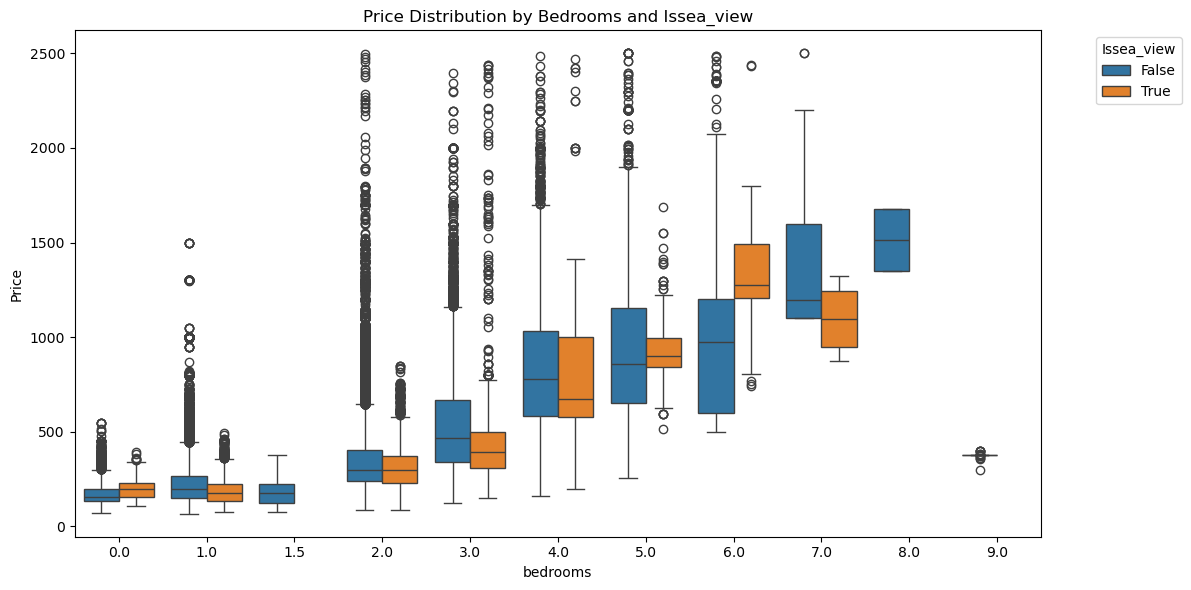


Mean Prices for Issea_view:
Issea_view        False        True 
bedrooms                            
0.0          174.930286   201.185997
1.0          222.928554   193.892036
1.5          187.447989          NaN
2.0          343.902141   315.003740
3.0          543.546312   452.816465
4.0          833.898353   773.526868
5.0          954.813534   952.324457
6.0         1082.250022  1328.027330
7.0         1319.113570  1096.959184
8.0         1512.500000          NaN
9.0          377.724754          NaN


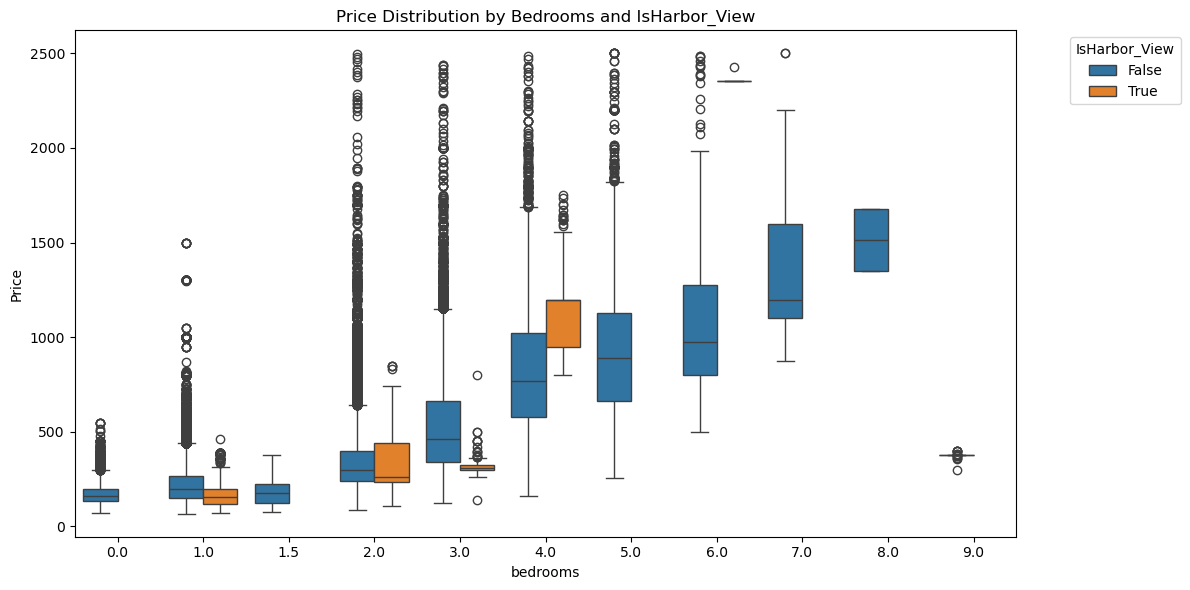


Mean Prices for IsHarbor_View:
IsHarbor_View        False        True 
bedrooms                               
0.0             175.843133          NaN
1.0             221.839708   173.693865
1.5             187.447989          NaN
2.0             342.881891   331.841183
3.0             540.184291   319.452629
4.0             825.194064  1144.508490
5.0             954.596257          NaN
6.0            1051.939653  2356.238916
7.0            1312.045022          NaN
8.0            1512.500000          NaN
9.0             377.724754          NaN


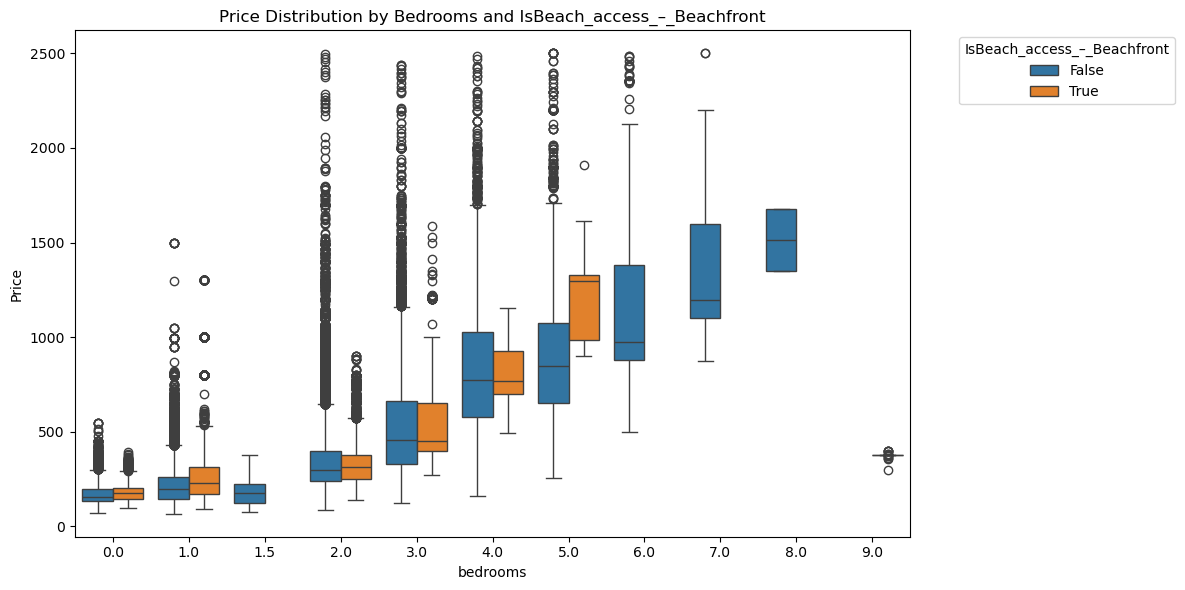


Mean Prices for IsBeach_access_–_Beachfront:
IsBeach_access_–_Beachfront        False        True 
bedrooms                                             
0.0                           174.703471   187.795192
1.0                           215.769431   301.508225
1.5                           187.447989          NaN
2.0                           342.925113   340.811406
3.0                           538.590628   565.656523
4.0                           829.879684   820.372740
5.0                           939.283477  1214.578206
6.0                          1147.336069          NaN
7.0                          1312.045022          NaN
8.0                          1512.500000          NaN
9.0                                  NaN   377.724754


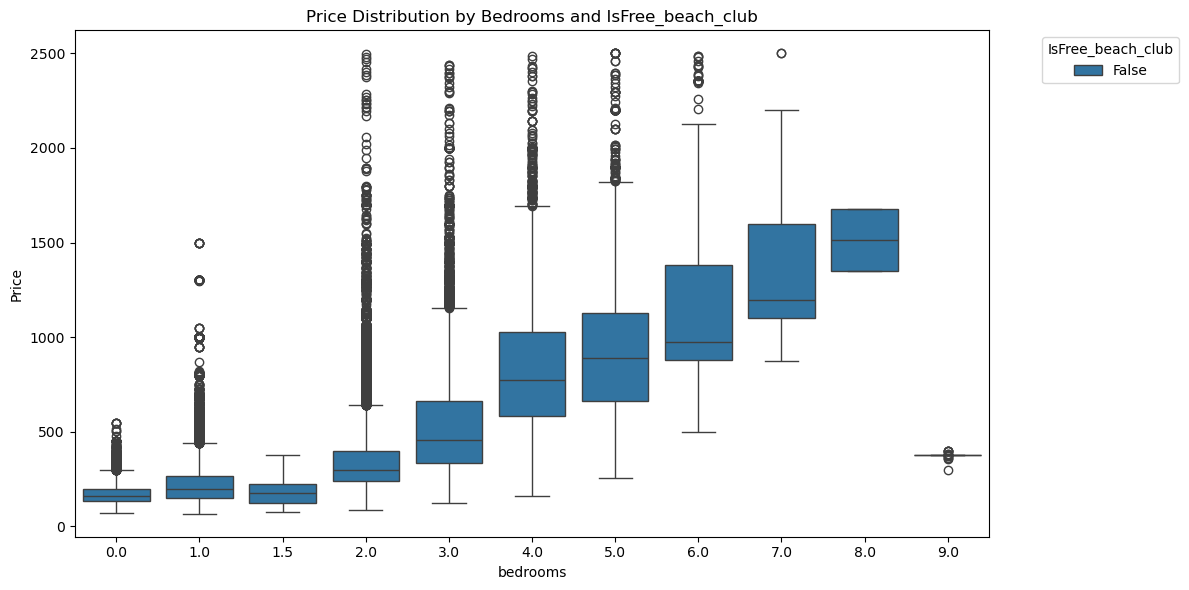


Mean Prices for IsFree_beach_club:
IsFree_beach_club        False
bedrooms                      
0.0                 175.843133
1.0                 221.386329
1.5                 187.447989
2.0                 342.813452
3.0                 539.295528
4.0                 829.567840
5.0                 954.596257
6.0                1147.336069
7.0                1312.045022
8.0                1512.500000
9.0                 377.724754


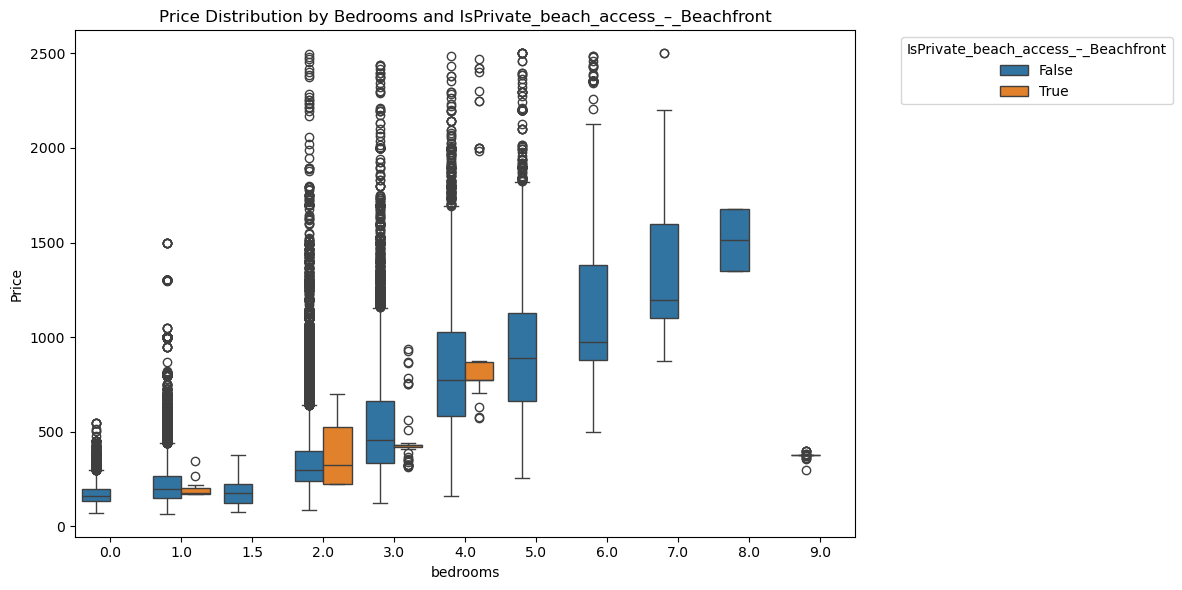


Mean Prices for IsPrivate_beach_access_–_Beachfront:
IsPrivate_beach_access_–_Beachfront        False        True 
bedrooms                                                     
0.0                                   175.843133          NaN
1.0                                   221.424541   186.513444
1.5                                   187.447989          NaN
2.0                                   342.766021   395.130435
3.0                                   539.413543   462.586021
4.0                                   828.309960  1027.719898
5.0                                   954.596257          NaN
6.0                                  1147.336069          NaN
7.0                                  1312.045022          NaN
8.0                                  1512.500000          NaN
9.0                                   377.724754          NaN


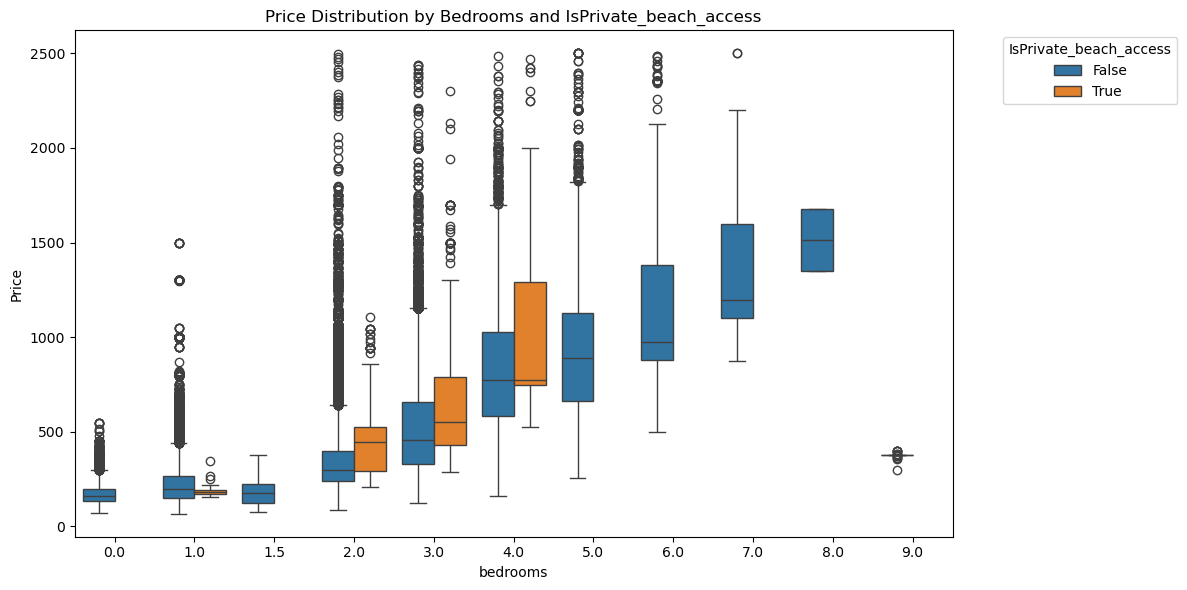


Mean Prices for IsPrivate_beach_access:
IsPrivate_beach_access        False       True 
bedrooms                                       
0.0                      175.843133         NaN
1.0                      221.472670  182.030973
1.5                      187.447989         NaN
2.0                      342.494147  443.589746
3.0                      537.769709  677.552972
4.0                      827.750422  953.799740
5.0                      954.596257         NaN
6.0                     1147.336069         NaN
7.0                     1312.045022         NaN
8.0                     1512.500000         NaN
9.0                      377.724754         NaN


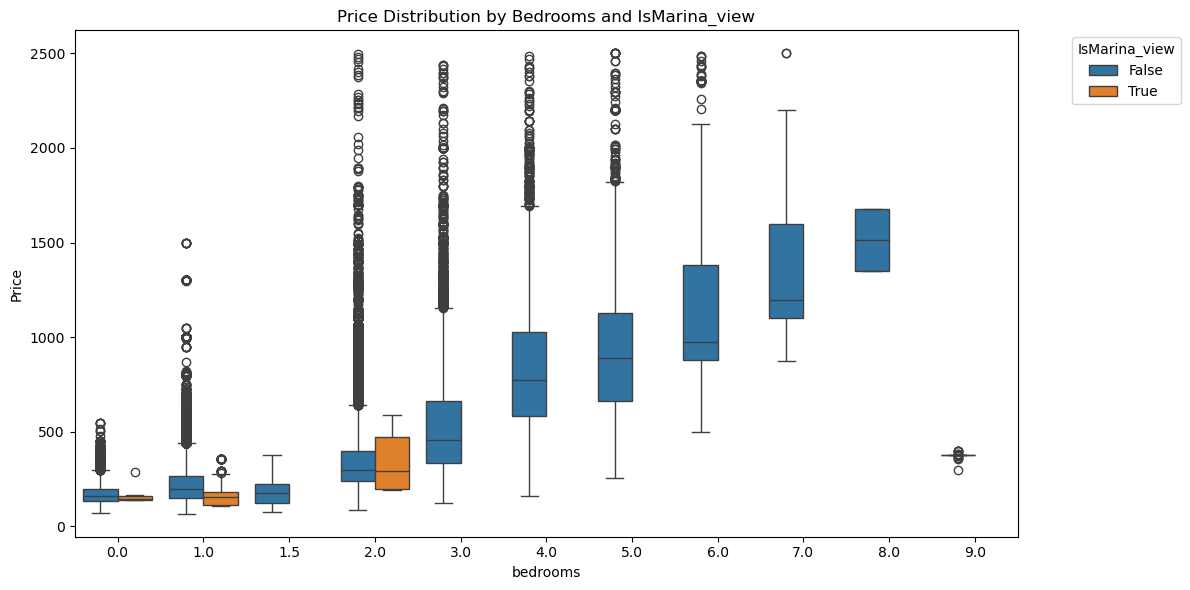


Mean Prices for IsMarina_view:
IsMarina_view        False       True 
bedrooms                              
0.0             175.942287  150.275041
1.0             221.592101  172.252944
1.5             187.447989         NaN
2.0             342.814307  342.322851
3.0             539.295528         NaN
4.0             829.567840         NaN
5.0             954.596257         NaN
6.0            1147.336069         NaN
7.0            1312.045022         NaN
8.0            1512.500000         NaN
9.0             377.724754         NaN


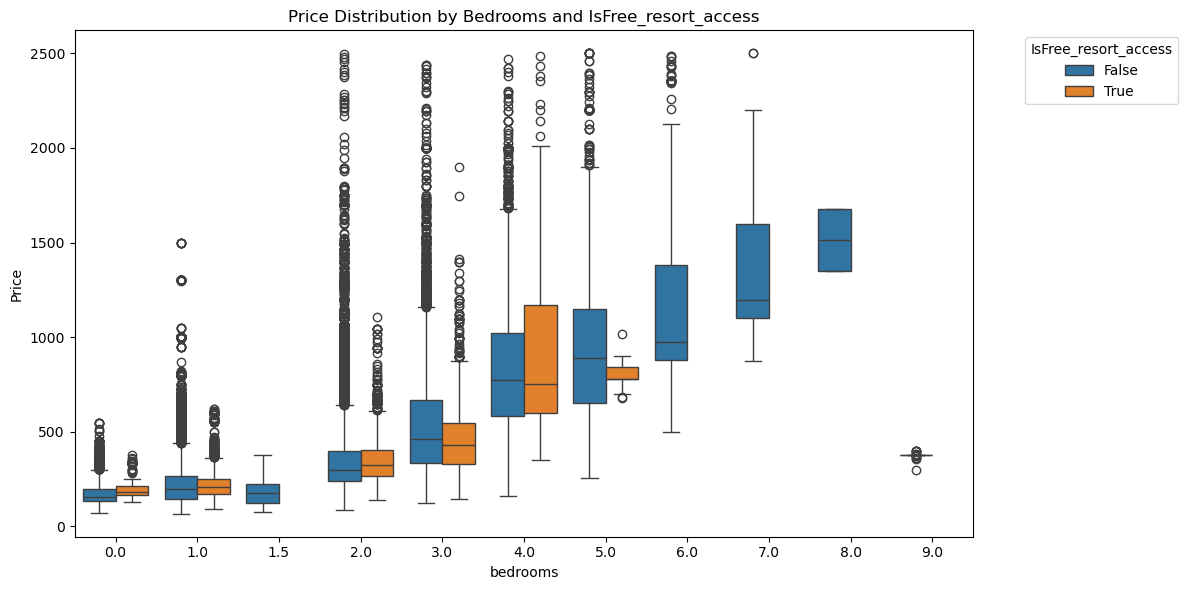


Mean Prices for IsFree_resort_access:
IsFree_resort_access        False       True 
bedrooms                                     
0.0                    175.333990  199.073950
1.0                    221.383566  221.490083
1.5                    187.447989         NaN
2.0                    342.677789  347.209195
3.0                    542.093740  467.603040
4.0                    827.761286  893.490246
5.0                    957.510367  804.798632
6.0                   1147.336069         NaN
7.0                   1312.045022         NaN
8.0                   1512.500000         NaN
9.0                    377.724754         NaN


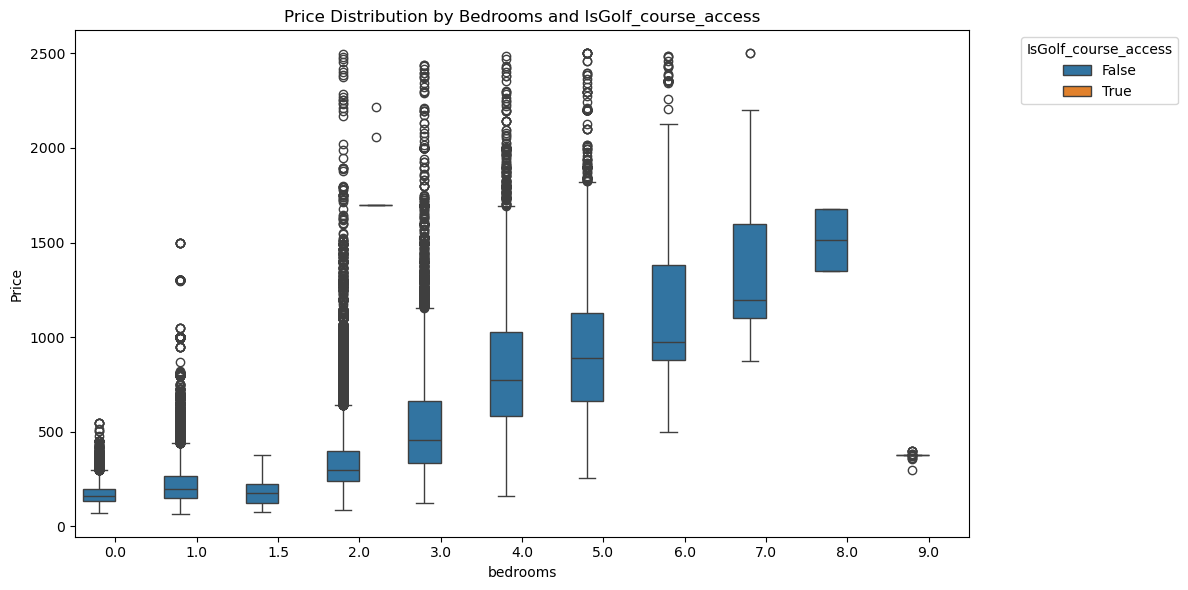


Mean Prices for IsGolf_course_access:
IsGolf_course_access        False        True 
bedrooms                                      
0.0                    175.843133          NaN
1.0                    221.386329          NaN
1.5                    187.447989          NaN
2.0                    342.229068  1716.190476
3.0                    539.295528          NaN
4.0                    829.567840          NaN
5.0                    954.596257          NaN
6.0                   1147.336069          NaN
7.0                   1312.045022          NaN
8.0                   1512.500000          NaN
9.0                    377.724754          NaN


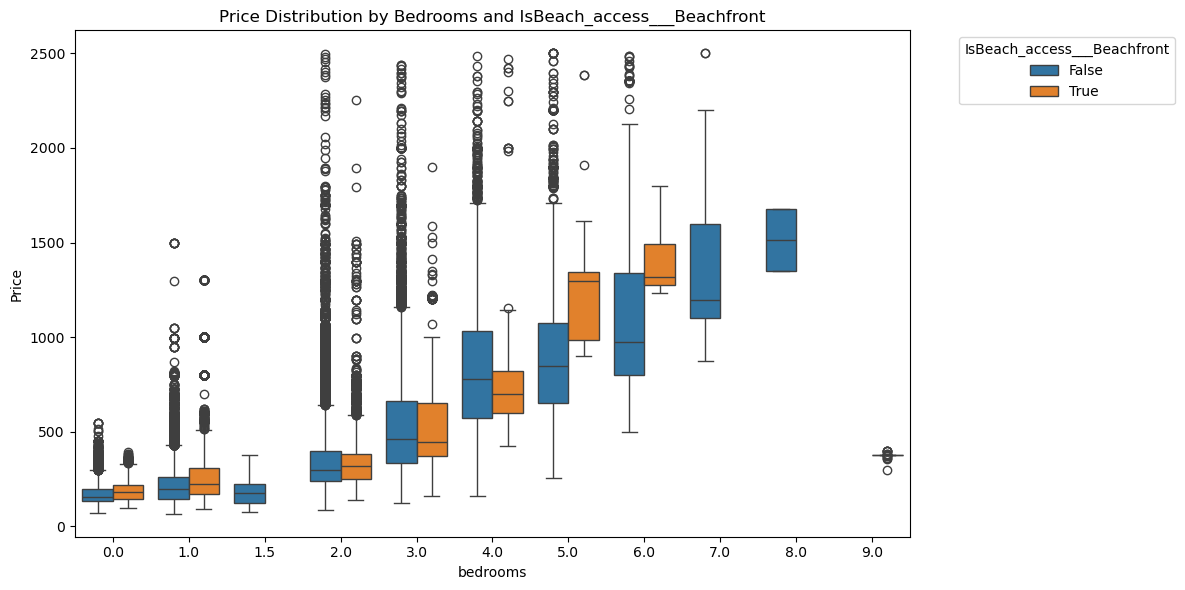


Mean Prices for IsBeach_access___Beachfront:
IsBeach_access___Beachfront        False        True 
bedrooms                                             
0.0                           173.412902   192.456476
1.0                           215.402508   292.580471
1.5                           187.447989          NaN
2.0                           342.595392   345.983189
3.0                           540.191482   516.846704
4.0                           833.802926   762.917931
5.0                           938.036733  1231.461973
6.0                          1126.923167  1406.016810
7.0                          1312.045022          NaN
8.0                          1512.500000          NaN
9.0                                  NaN   377.724754


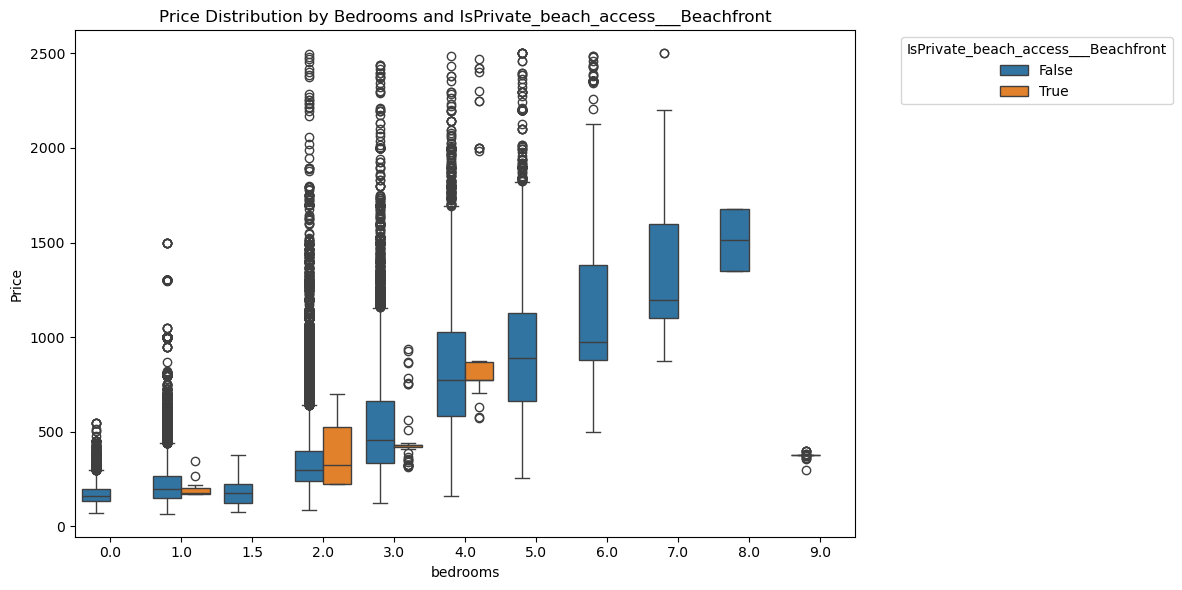


Mean Prices for IsPrivate_beach_access___Beachfront:
IsPrivate_beach_access___Beachfront        False        True 
bedrooms                                                     
0.0                                   175.843133          NaN
1.0                                   221.424541   186.513444
1.5                                   187.447989          NaN
2.0                                   342.766021   395.130435
3.0                                   539.413543   462.586021
4.0                                   828.309960  1027.719898
5.0                                   954.596257          NaN
6.0                                  1147.336069          NaN
7.0                                  1312.045022          NaN
8.0                                  1512.500000          NaN
9.0                                   377.724754          NaN


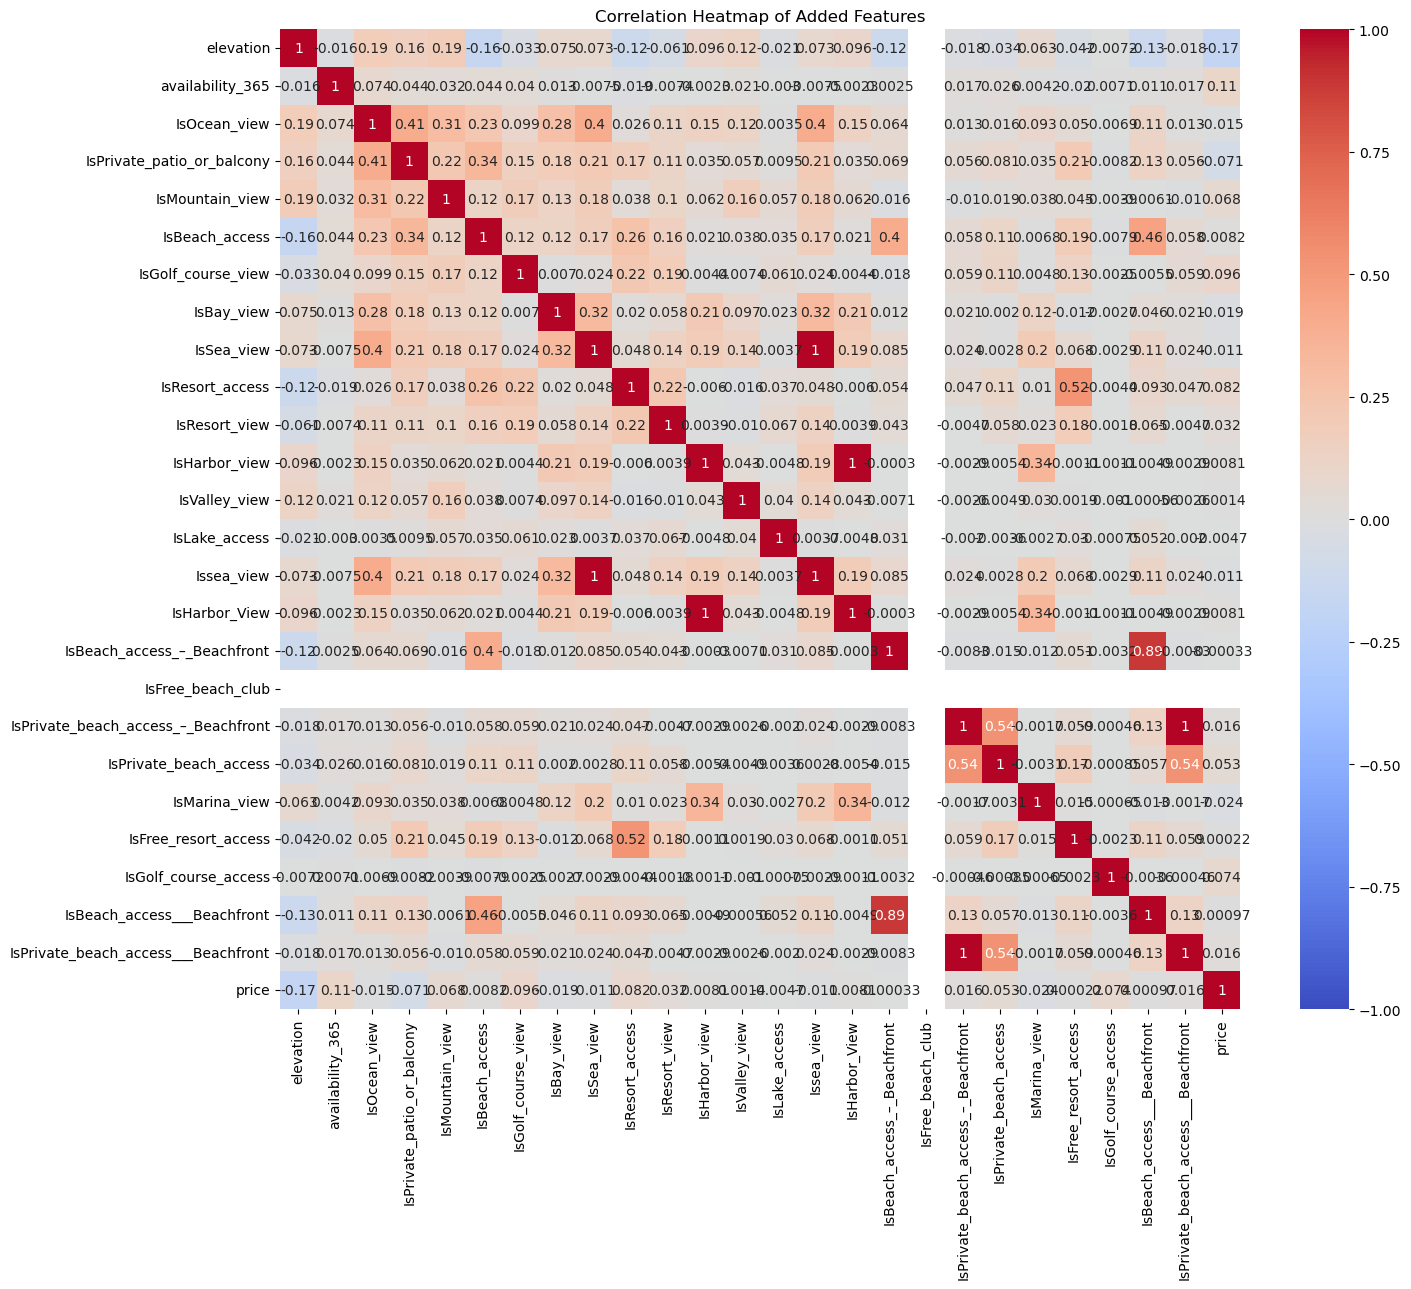

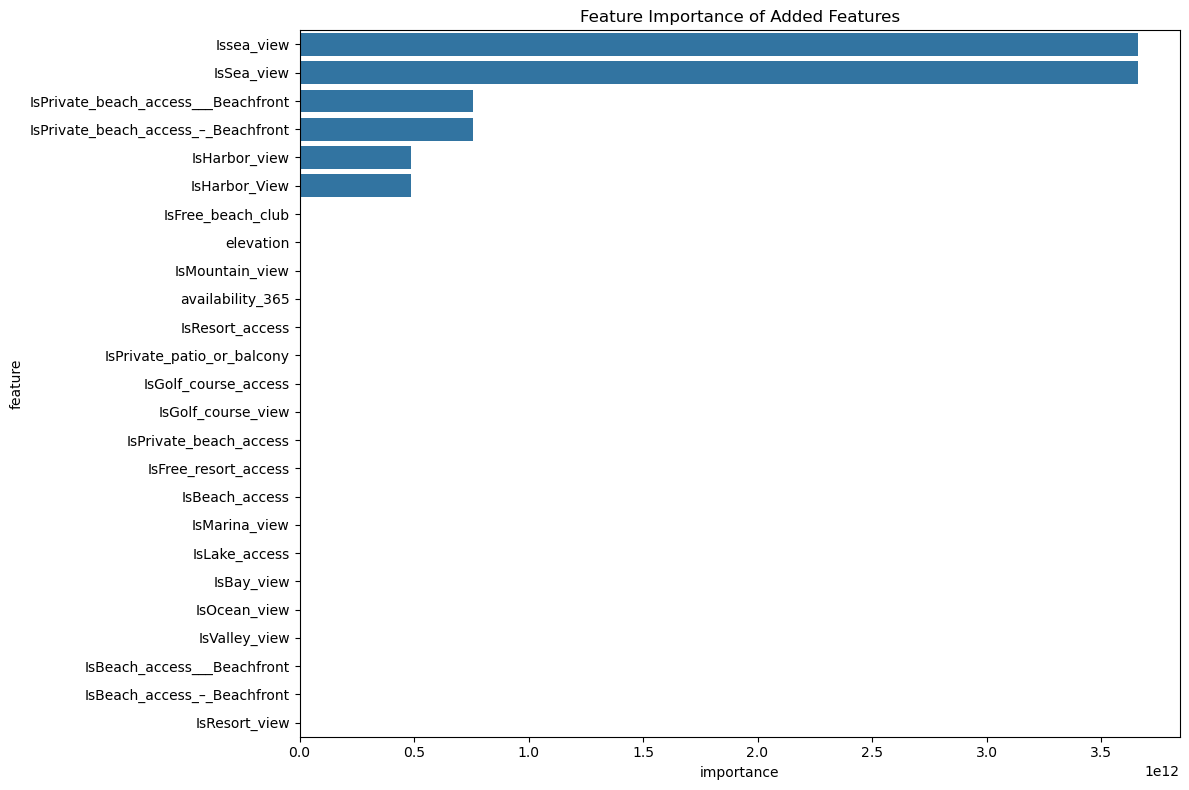


Top 10 Most Important Added Features:
                                feature    importance
14                           Issea_view  3.661589e+12
8                            IsSea_view  3.661589e+12
24  IsPrivate_beach_access___Beachfront  7.586010e+11
18  IsPrivate_beach_access_–_Beachfront  7.586010e+11
11                        IsHarbor_view  4.885588e+11
15                        IsHarbor_View  4.885588e+11
17                    IsFree_beach_club  6.240006e+09
0                             elevation  4.350390e+01
4                       IsMountain_view  2.506159e+01
1                      availability_365  2.470246e+01


In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Filter for 4 and 5 bedroom listings

# Function to analyze and plot feature interactions
def analyze_feature_interaction(df,feature):
    plt.figure(figsize=(12, 6))
    sns.boxplot(x='bedrooms', y='price', hue=feature, data=df)
    plt.title(f'Price Distribution by Bedrooms and {feature}')
    plt.ylabel('Price')
    #plt.xticks([0, 1], ['4 Bedrooms', '5 Bedrooms'])
    plt.legend(title=feature, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()
    
    # Calculate mean price for each combination
    mean_prices = df.groupby(['bedrooms', feature])['price'].mean().unstack()
    print(f"\nMean Prices for {feature}:")
    print(mean_prices)


# Analyze interactions for each added feature
for feature in added_columns:
    analyze_feature_interaction(joined,feature)

# Correlation analysis
correlation_matrix = joined[added_columns + ['price']].corr()
plt.figure(figsize=(15, 13))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title('Correlation Heatmap of Added Features')
plt.tight_layout()
plt.show()

# Feature importance (using a simple linear regression)
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

X = joined[added_columns]
y = joined['price']

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Fit linear regression
model = LinearRegression()
model.fit(X_scaled, y)

# Get feature importance
feature_importance = pd.DataFrame({
    'feature': added_columns,
    'importance': np.abs(model.coef_)
})
feature_importance = feature_importance.sort_values('importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='feature', data=feature_importance)
plt.title('Feature Importance of Added Features')
plt.tight_layout()
plt.show()

print("\nTop 10 Most Important Added Features:")
print(feature_importance.head(10))




# I chose some of the features that may help explain some of the price variance at larger listing sizes.


Feature: IsResort_access
Mean Price (True): $406.66 (Count: 29925)
Mean Price (False): $339.06 (Count: 276329)
Difference: $67.60
Percentage Difference: 19.94%

Feature: IsBeach_access
Mean Price (True): $349.07 (Count: 79636)
Mean Price (False): $344.47 (Count: 226618)
Difference: $4.60
Percentage Difference: 1.34%

Feature: IsGolf_course_view
Mean Price (True): $469.59 (Count: 10649)
Mean Price (False): $341.20 (Count: 295605)
Difference: $128.39
Percentage Difference: 37.63%

Feature: IsBeach_access_–_Beachfront
Mean Price (True): $345.33 (Count: 16635)
Mean Price (False): $345.68 (Count: 289619)
Difference: $-0.35
Percentage Difference: -0.10%

Feature: IsResort_view
Mean Price (True): $402.91 (Count: 5578)
Mean Price (False): $344.60 (Count: 300676)
Difference: $58.31
Percentage Difference: 16.92%


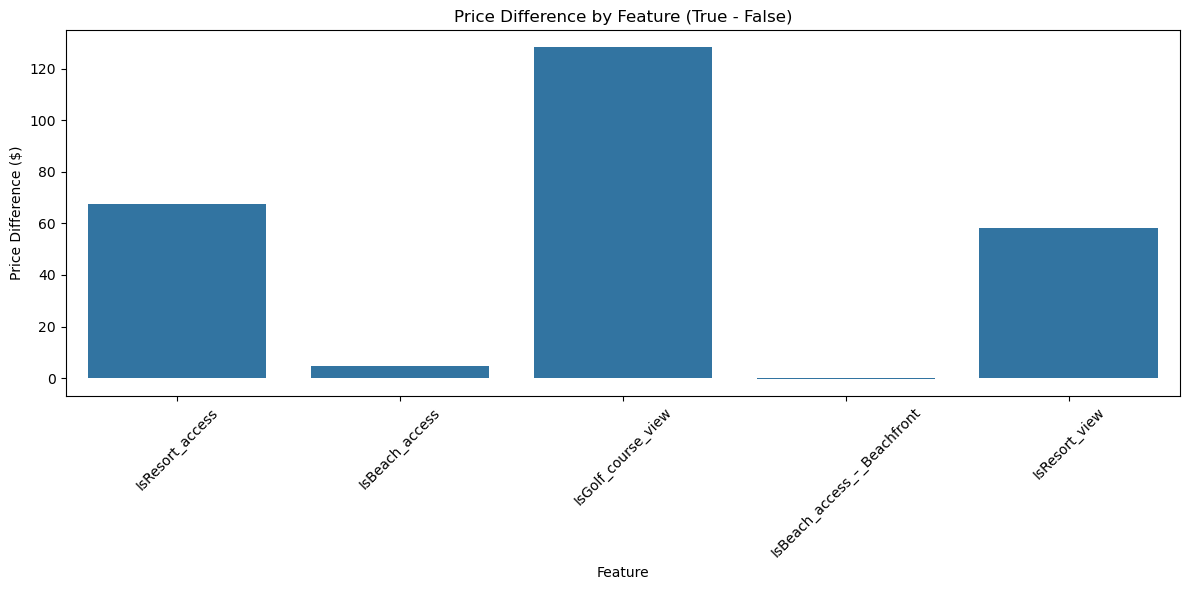

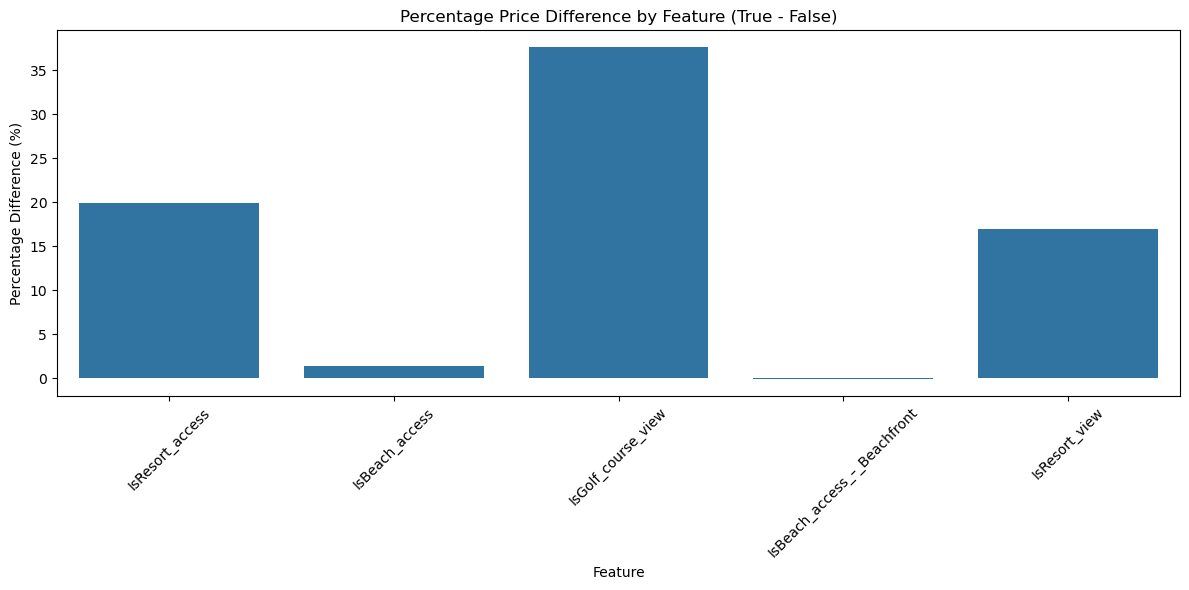


Summary Table:
                    Feature  Mean Price (True)  Mean Price (False)  Count (True)  Count (False)  Difference  Percentage Difference
            IsResort_access         406.658916          339.057005         29925         276329   67.601911              19.938214
             IsBeach_access         349.067926          344.465919         79636         226618    4.602007               1.335983
         IsGolf_course_view         469.585268          341.198348         10649         295605  128.386920              37.628236
IsBeach_access_–_Beachfront         345.328079          345.681804         16635         289619   -0.353725              -0.102327
              IsResort_view         402.910444          344.600556          5578         300676   58.309889              16.921008


In [28]:

# List of features to analyze
features_to_analyze = ['IsResort_access', 'IsBeach_access', 'IsGolf_course_view', 'IsBeach_access_–_Beachfront','IsResort_view']

# Function to calculate and display mean prices and counts
def analyze_feature_impact(feature):
    # Calculate mean prices
    mean_true = joined[joined[feature] == True]['price'].mean()
    mean_false = joined[joined[feature] == False]['price'].mean()
    
    # Count the number of rows in each category
    count_true = joined[joined[feature] == True].shape[0]
    count_false = joined[joined[feature] == False].shape[0]
    
    difference = mean_true - mean_false
    percentage_difference = (difference / mean_false) * 100 if mean_false != 0 else np.nan  # Avoid division by zero
    
    print(f"\nFeature: {feature}")
    print(f"Mean Price (True): ${mean_true:.2f} (Count: {count_true})")
    print(f"Mean Price (False): ${mean_false:.2f} (Count: {count_false})")
    print(f"Difference: ${difference:.2f}")
    print(f"Percentage Difference: {percentage_difference:.2f}%")
    
    return {
        'Feature': feature,
        'Mean Price (True)': mean_true,
        'Mean Price (False)': mean_false,
        'Count (True)': count_true,
        'Count (False)': count_false,
        'Difference': difference,
        'Percentage Difference': percentage_difference
    }

# Analyze each feature
results = []
for feature in features_to_analyze:
    results.append(analyze_feature_impact(feature))

# Create a DataFrame with the results
results_df = pd.DataFrame(results)

# Plotting
plt.figure(figsize=(12, 6))
sns.barplot(x='Feature', y='Difference', data=results_df)
plt.title('Price Difference by Feature (True - False)')
plt.ylabel('Price Difference ($)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plotting percentage difference
plt.figure(figsize=(12, 6))
sns.barplot(x='Feature', y='Percentage Difference', data=results_df)
plt.title('Percentage Price Difference by Feature (True - False)')
plt.ylabel('Percentage Difference (%)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Print summary table
print("\nSummary Table:")
print(results_df.to_string(index=False))


**IsGolf_course_view, isResort_view, and isResort_access have different mean prices for True and False**


Feature: IsResort_access
Mean Price (True): $1004.48 (Count: 1398)
Mean Price (False): $865.12 (Count: 13349)
Difference: $139.37
Percentage Difference: 16.11%

Feature: IsBeach_access
Mean Price (True): $929.16 (Count: 4713)
Mean Price (False): $854.46 (Count: 10034)
Difference: $74.70
Percentage Difference: 8.74%

Feature: IsGolf_course_view
Mean Price (True): $1142.62 (Count: 834)
Mean Price (False): $862.49 (Count: 13913)
Difference: $280.13
Percentage Difference: 32.48%

Feature: IsBeach_access_–_Beachfront
Mean Price (True): $871.06 (Count: 559)
Mean Price (False): $878.62 (Count: 14188)
Difference: $-7.56
Percentage Difference: -0.86%

Feature: IsResort_view
Mean Price (True): $nan (Count: 0)
Mean Price (False): $878.33 (Count: 14747)
Difference: $nan
Percentage Difference: nan%


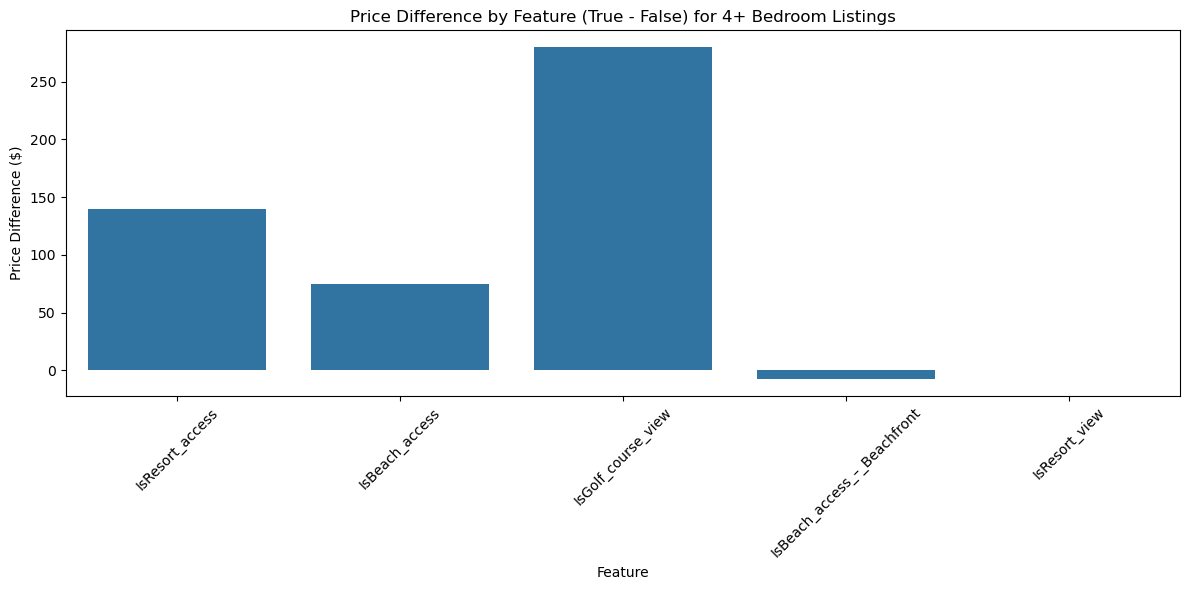

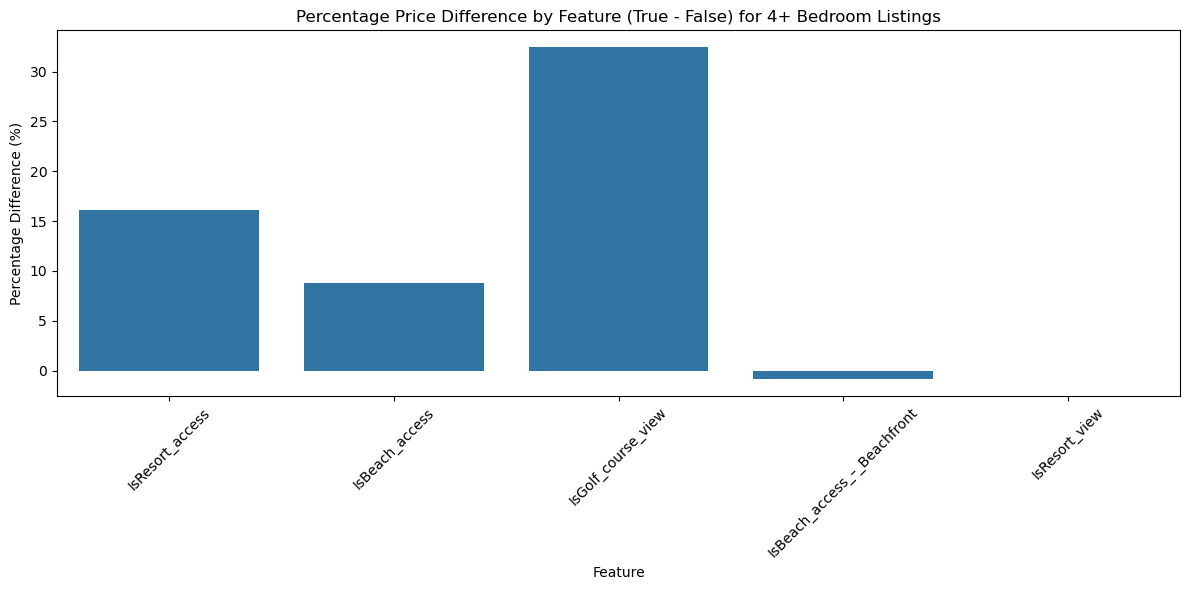


Summary Table for 4+ Bedroom Listings:
                    Feature  Mean Price (True)  Mean Price (False)  Count (True)  Count (False)  Difference  Percentage Difference
            IsResort_access        1004.484773          865.118034          1398          13349  139.366739              16.109564
             IsBeach_access         929.157466          854.455971          4713          10034   74.701495               8.742580
         IsGolf_course_view        1142.619967          862.487263           834          13913  280.132704              32.479634
IsBeach_access_–_Beachfront         871.057115          878.616396           559          14188   -7.559280              -0.860362
              IsResort_view                NaN          878.329853             0          14747         NaN                    NaN


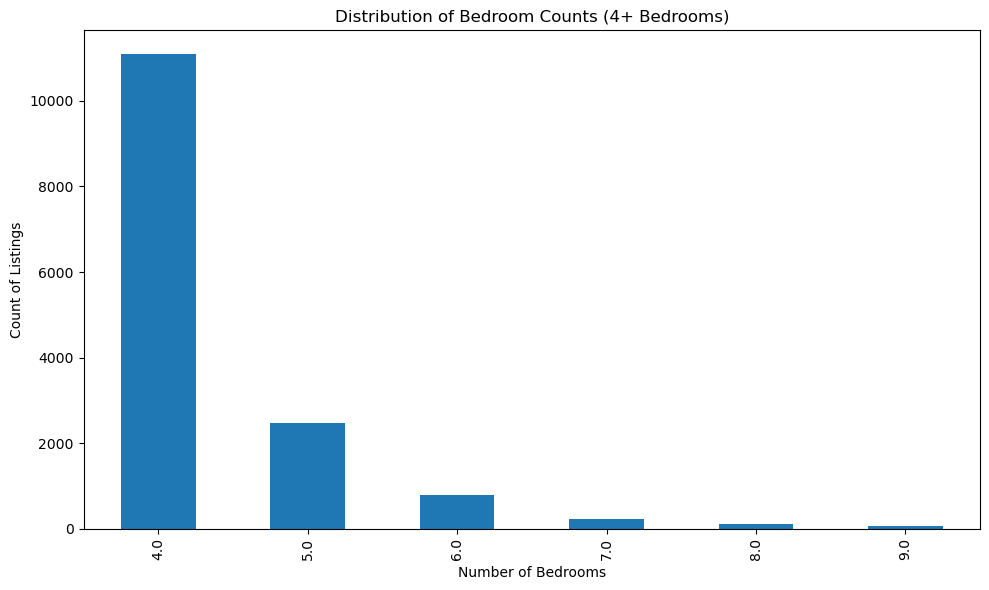


Distribution of Bedroom Counts:
bedrooms
4.0    11097
5.0     2463
6.0      793
7.0      220
8.0      116
9.0       58
Name: count, dtype: int64


In [30]:


# Filter for listings with 4 or more bedrooms
joined_4plus = joined[joined['bedrooms'] >= 4]

# List of features to analyze
features_to_analyze = ['IsResort_access', 'IsBeach_access', 'IsGolf_course_view', 'IsBeach_access_–_Beachfront','IsResort_view']

# Function to calculate and display mean prices and counts
def analyze_feature_impact(feature):
    # Calculate mean prices
    mean_true = joined_4plus[joined_4plus[feature] == True]['price'].mean()
    mean_false = joined_4plus[joined_4plus[feature] == False]['price'].mean()
    
    # Count the number of rows in each category
    count_true = joined_4plus[joined_4plus[feature] == True].shape[0]
    count_false = joined_4plus[joined_4plus[feature] == False].shape[0]
    
    difference = mean_true - mean_false
    percentage_difference = (difference / mean_false) * 100 if mean_false != 0 else np.nan  # Avoid division by zero
    
    print(f"\nFeature: {feature}")
    print(f"Mean Price (True): ${mean_true:.2f} (Count: {count_true})")
    print(f"Mean Price (False): ${mean_false:.2f} (Count: {count_false})")
    print(f"Difference: ${difference:.2f}")
    print(f"Percentage Difference: {percentage_difference:.2f}%")
    
    return {
        'Feature': feature,
        'Mean Price (True)': mean_true,
        'Mean Price (False)': mean_false,
        'Count (True)': count_true,
        'Count (False)': count_false,
        'Difference': difference,
        'Percentage Difference': percentage_difference
    }

# Analyze each feature
results = []
for feature in features_to_analyze:
    results.append(analyze_feature_impact(feature))

# Create a DataFrame with the results
results_df = pd.DataFrame(results)

# Plotting
plt.figure(figsize=(12, 6))
sns.barplot(x='Feature', y='Difference', data=results_df)
plt.title('Price Difference by Feature (True - False) for 4+ Bedroom Listings')
plt.ylabel('Price Difference ($)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plotting percentage difference
plt.figure(figsize=(12, 6))
sns.barplot(x='Feature', y='Percentage Difference', data=results_df)
plt.title('Percentage Price Difference by Feature (True - False) for 4+ Bedroom Listings')
plt.ylabel('Percentage Difference (%)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Print summary table
print("\nSummary Table for 4+ Bedroom Listings:")
print(results_df.to_string(index=False))

# Additional analysis: Distribution of bedroom counts
bedroom_counts = joined_4plus['bedrooms'].value_counts().sort_index()
plt.figure(figsize=(10, 6))
bedroom_counts.plot(kind='bar')
plt.title('Distribution of Bedroom Counts (4+ Bedrooms)')
plt.xlabel('Number of Bedrooms')
plt.ylabel('Count of Listings')
plt.tight_layout()
plt.show()

print("\nDistribution of Bedroom Counts:")
print(bedroom_counts)


# Add the features to the data to see if it impacts the model performance.  
**I created two new features 'isBeachAccess' and 'isResortAmenities'. isResortAmenities includeds IsResort_access, IsResort_view and IsGolf_course_view.**

In [32]:
import pandas as pd

# Create the new features
joined['isBeachAccess'] = (
     (joined['IsBeach_access'])
)

joined['isResortAmenities'] = (
      
    (joined['IsResort_access'] | joined['IsGolf_course_view']|(joined['IsResort_view']))
)

# List of columns to remove
added_columns = ["availability_365", "IsOcean_view", "IsPrivate_patio_or_balcony",
    "IsMountain_view", "IsBeach_access", "IsGolf_course_view", "IsBay_view",
    "IsSea_view", "IsResort_access", "IsResort_view", "IsHarbor_view",
    "IsValley_view", "IsLake_access", "Issea_view", "IsHarbor_View",
    "IsBeach_access_–_Beachfront", "IsFree_beach_club",
    "IsPrivate_beach_access_–_Beachfront", "IsPrivate_beach_access",
    "IsMarina_view", "IsFree_resort_access", "IsGolf_course_access",
    "IsBeach_access___Beachfront", "IsPrivate_beach_access___Beachfront"
]

# Create a list of columns to keep
columns_to_keep = [col for col in joined.columns if col not in added_columns]

# Create the final DataFrame
df_final = joined[columns_to_keep]

# Display info about the new DataFrame
print(df_final.info())

# Display the first few rows of the new DataFrame
print(df_final.head())

# Check the counts of True values in our new features
print("\nCounts of True values in new features:")
print("isBeachAccess:", df_final['isBeachAccess'].sum())
print("isResortAmenities:", df_final['isResortAmenities'].sum())

# Optional: Save the new DataFrame to a CSV file
# df_final.to_csv('processed_listings.csv', index=False)

# Print the list of columns in the final DataFrame
print("\nColumns in the final DataFrame:")
print(df_final.columns.tolist())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306254 entries, 0 to 306253
Data columns (total 57 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   listing_id                           306254 non-null  int64  
 1   price                                306254 non-null  float64
 2   latitude                             306254 non-null  float64
 3   longitude                            306254 non-null  float64
 4   property_type                        306254 non-null  object 
 5   accommodates                         306254 non-null  int64  
 6   bathrooms                            306254 non-null  float64
 7   bedrooms                             306254 non-null  float64
 8   review_scores_location               306254 non-null  float64
 9   review_scores_rating                 306254 non-null  float64
 10  review_scores_cleanliness            306254 non-null  float64
 11  room_type_Pri

In [33]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306254 entries, 0 to 306253
Data columns (total 57 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   listing_id                           306254 non-null  int64  
 1   price                                306254 non-null  float64
 2   latitude                             306254 non-null  float64
 3   longitude                            306254 non-null  float64
 4   property_type                        306254 non-null  object 
 5   accommodates                         306254 non-null  int64  
 6   bathrooms                            306254 non-null  float64
 7   bedrooms                             306254 non-null  float64
 8   review_scores_location               306254 non-null  float64
 9   review_scores_rating                 306254 non-null  float64
 10  review_scores_cleanliness            306254 non-null  float64
 11  room_type_Pri

In [34]:
train, test=apf.train_test_split_airbnb(df_final,0.8)
non_features=['price','inResort','number_of_reviews','geometry','week','listing_id','log_price','listing_url','missing_rating','price_per_accommodation','price_per_bedroom','price_per_review','property_type','geometry','anomaly_score','price_per_accommodation','price_per_bedroom','price_per_review','amenities_length']

features=[col for col in df_final.columns if col not in non_features]
X_train=train[features]
y_train=train['price']
X_test=test[features]
y_test=test['price']

# Retrain model on data with added features

In [36]:

xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [37]:
y_pred_train_xgb = xgb_model.predict(X_train)
y_pred_test_xgb = xgb_model.predict(X_test)
# Fit the model

# Calculate metrics
rmse_train_xgb = np.sqrt(mean_squared_error(y_train, y_pred_train_xgb))
rmse_test_xgb = np.sqrt(mean_squared_error(y_test, y_pred_test_xgb))
r2_train_xgb = r2_score(y_train, y_pred_train_xgb)
r2_test_xgb = r2_score(y_test, y_pred_test_xgb)

print("XGBoost Results:")
print(f"Train RMSE: {rmse_train_xgb}")
print(f"Test RMSE: {rmse_test_xgb}")
print(f"Train R2: {r2_train_xgb}")
print(f"Test R2: {r2_test_xgb}")

XGBoost Results:
Train RMSE: 71.65321394273991
Test RMSE: 104.26670728241852
Train R2: 0.9168902087324682
Test R2: 0.7918644589153803


# Permutation Feature Importance

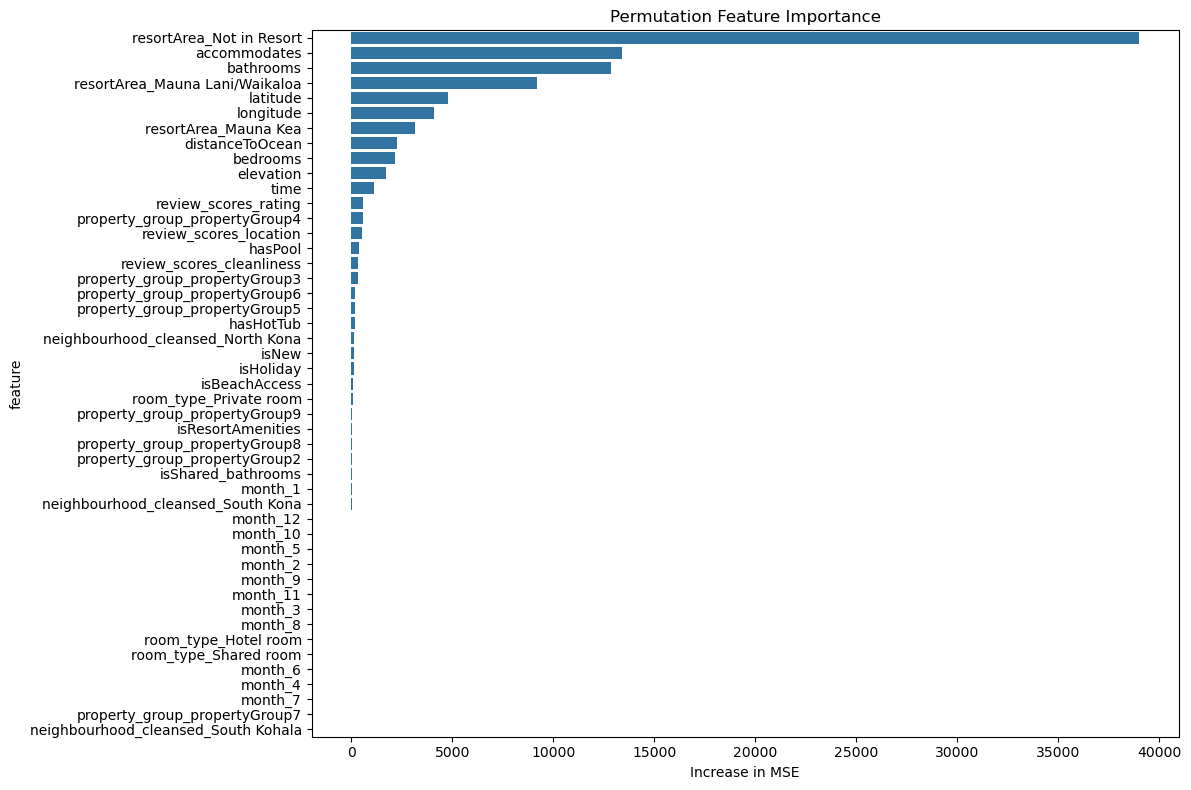

Feature Importances:
                            feature   importance  relative_importance
           resortArea_Not in Resort 39020.103618           358.919538
                       accommodates 13411.668795           123.364869
                          bathrooms 12870.440038           118.386472
     resortArea_Mauna Lani/Waikaloa  9216.804174            84.779147
                           latitude  4787.133209            44.033600
                          longitude  4105.565943            37.764324
               resortArea_Mauna Kea  3134.260922            28.829946
                    distanceToOcean  2257.953106            20.769383
                           bedrooms  2149.796784            19.774526
                          elevation  1701.235367            15.648513
                               time  1118.249567            10.286021
               review_scores_rating   570.662668             5.249140
      property_group_propertyGroup4   555.229844             5.107184

In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import seaborn as sns
def single_feature_importance(model, X, y, feature):
    np.random.seed(42)
    baseline_mse = mean_squared_error(y, model.predict(X))
    X_permuted = X.copy()
    X_permuted[feature] = np.random.permutation(X_permuted[feature])
    permuted_mse = mean_squared_error(y, model.predict(X_permuted))
    return permuted_mse - baseline_mse

# Assuming your model is called 'xgb_model' and is already fitted

# Calculate baseline MSE
baseline_mse = mean_squared_error(y_test, xgb_model.predict(X_test))

# Calculate importance for each feature
feature_importance = []
for feature in X_test.columns:
    importance = single_feature_importance(xgb_model, X_test, y_test, feature)
    feature_importance.append({'feature': feature, 'importance': importance})

# Convert to DataFrame and sort
feature_importance_df = pd.DataFrame(feature_importance)
feature_importance_df = feature_importance_df.sort_values('importance', ascending=False)

# Calculate relative importance
feature_importance_df['relative_importance'] = (feature_importance_df['importance'] / baseline_mse) * 100

# Plot feature importances
plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='feature', data=feature_importance_df)
plt.title('Permutation Feature Importance')
plt.xlabel('Increase in MSE')
plt.tight_layout()
plt.show()

# Print feature importances
print("Feature Importances:")
print(feature_importance_df.to_string(index=False))

print(f"\nBaseline MSE: {baseline_mse:.4f}")

print("\nRelative Feature Importances (% of baseline MSE):")
print(feature_importance_df[['feature', 'relative_importance']].to_string(index=False))


**Results tend to vary.  The feature importance will be cross validated in other notebooks.  In this iteration the added features had a slight positive impact on the models performance (may be negligible).**